# Surrogate analysis for the daily mean LST at all points

## Setting up

### Import packages here

In [1]:
import pickle
from xarray import open_dataset
from numpy import (sqrt, append, isnan, datetime64, arange, linspace, zeros, sum, array, dot, stack
    ,maximum, minimum, fmax, fmin, ceil, sign)
from sklearn.decomposition import PCA
#from numpoly import ndpoly

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors
#from matplotlib.tri import Triangulation
#from cartopy.crs import PlateCarree
#from cartopy.feature import NaturalEarthFeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# some parameters
plt.rcParams.update({'font.size': 14})
#dpi = 200

In [2]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.nn_regression import make_nn_surrogate_model
from surrogate.pc_regression import make_pc_surrogate_model
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens

### Set the variables to analyze and get list of filenames

In [3]:
# time start and end 
ts = datetime64('2018-06-01')
te = datetime64('2018-09-01')

# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [4]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
train_output_filename = '../output/wfv_global_daily_temperature_training_set.pkl'
test_output_filename = '../output/wfv_global_daily_temperature_test_set.pkl'

# fvcom grid
# directories
proj_dir = '/lus/grand/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/'
fvcom_grid_file = proj_dir + 'fvcom_grid.nc' 

## Load inputs 

In [5]:
# fvcom grid
fvcom = open_dataset(fvcom_grid_file,decode_times=False, drop_variables=['siglay', 'siglev'])

In [6]:
## parameter info

# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [7]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

In [8]:
## data info

#load the training data
with open(train_output_filename, 'rb') as fp:
    train_dict = pickle.load(fp)
    print('Done loading training data from binary file')
    
with open(test_output_filename, 'rb') as fp:
    test_dict = pickle.load(fp)
    print('Done loading test data from binary file')

Done loading training data from binary file
Done loading test data from binary file


In [9]:
# Get and check train sizes
nens = len(train_dict['runs'])
ntime = train_dict['LST'][0][0].shape[0]
ntime_, ngrid = train_dict['LST'][0][1].shape
nens_ = len(train_dict['LST'])
nens__, ndim = variable_matrix_train.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {ngrid}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
Timeseries size : 112
Spatial size: 35749


In [10]:
# Get and check train sizes
nens = len(test_dict['runs'])
ntime = test_dict['LST'][0][0].shape[0]
ntime_, ngrid = test_dict['LST'][0][1].shape
nens_ = len(test_dict['LST'])
nens__, ndim = variable_matrix_test.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {ngrid}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
Timeseries size : 112
Spatial size: 35749


In [11]:
# construct the training data into right dimensions
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2 = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        trainY = value_temp
    else:
        trainY = append(trainY,value_temp,axis=0)
display(trainY.shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        testY = value_temp
    else:
        testY = append(testY,value_temp,axis=0)
        
display(testY.shape)

(18, 3288908)

(5, 3288908)

##  Construct surrogate models

In [12]:
# some variables for surrogate
var_explained = 0.99 #len(variables) #for PCA

# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
if hot_encode:
    train_x = variable_matrix_train
    test_x = variable_matrix_test
else:
    train_x = ptrain
    test_x = ptest

# PC surrogate model parameters
polynomial_order = 2
regression_type = 'ElasticNet'

# NN surrogate model parameters
batch_size = nens_train // 3 #5 K-Fold
hidden_layers = 1
learn_rate = 0.0005
nepochs=1000

# randomization
random_seeds = range(111,999+111,111)
#seed = 666 # val_loss = 0.71 , BO gives ??
#seed = 111 # val_loss = 0.67,  BO gives BO1 parameters
#seed = 99 # val_loss = 0.73 , BO gives BO1 except COARE, GOTM k-eps
#seed = 222 # val_loss = 0.66, BO gives BO1 except COARE, GOTM k-eps
#seed = None

# initialize the surrogate dictionary
kl_surrogate = dict()

### Decompose the time series

In [13]:
# Decompose the spatiotemporal series using PCA/KL
pca_obj = PCA(n_components=var_explained, 
              random_state=random_seeds[0], 
              whiten=True)
pca_obj.fit(trainY)

PCA(n_components=0.99, random_state=111, whiten=True)

In [14]:
# get the outputs from the PCA
klxi_train = pca_obj.transform(trainY)
klxi_test  = pca_obj.transform(testY)
eigenratio = pca_obj.explained_variance_ratio_
print(eigenratio)
print(eigenratio.sum())
neig = pca_obj.n_components_
eigenvalues = pca_obj.explained_variance_
eigenmodes = pca_obj.components_
mean_vector = pca_obj.mean_
print(f'number of eigenmodes is {neig}')

[0.59524146 0.10616204 0.04990378 0.04276877 0.03184092 0.0306296
 0.02111236 0.0180193  0.01771278 0.01564328 0.01278902 0.01178656
 0.01132847 0.01067537 0.01020208 0.00743399]
0.9932497794237986
number of eigenmodes is 16


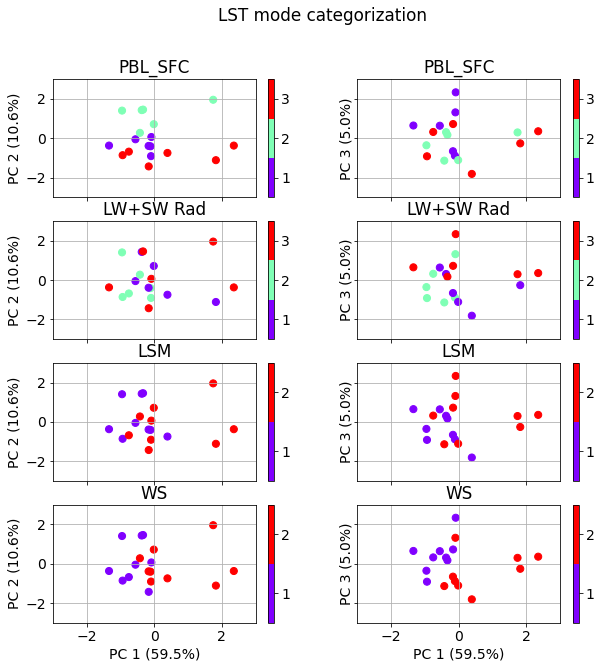

In [15]:
labels = [
    f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(eigenratio * 100)
]
important_variables = [WRF_PBL_SFCLAY, WRF_RA, WRF_LM, FVCOM_WindStress]
pname_paper = ['PBL_SFC', 'LW+SW Rad', 'LSM', 'WS']
bnds = 3

fig, axs = plt.subplots(len(important_variables), 2,sharey=True,sharex=True,figsize=(10,10))
for vv,var in enumerate(important_variables):
    cat = ptrain.sel(variable=var.name).values
    cmap = plt.cm.rainbow
    catrange = arange(cat.min()-0.5, cat.max()+1.5, 1)
    norm = colors.BoundaryNorm(catrange, cmap.N)
    for ii in [0,1]:
        py = axs[vv,ii].scatter(klxi_train[:,0],klxi_train[:,ii+1],s=50,c=cat, cmap=cmap, norm=norm)
        if vv == len(important_variables)-1:
            axs[vv,ii].set_xlabel(labels[0])
        axs[vv,ii].set_ylabel(labels[ii+1])
        axs[vv,ii].grid()
        axs[vv,ii].set_xlim([-bnds,bnds])
        axs[vv,ii].set_ylim([-bnds,bnds])
        plt.colorbar(py,ax=axs[vv,ii],ticks=catrange+0.5)
        axs[vv,ii].set_title(pname_paper[vv])
plt.suptitle('LST mode categorization')
plt.show()

### Train and check the PC model

In [16]:
# Polynomial Chaos
from sklearn.model_selection import KFold
kl_surrogate['PC'] = list()
for random_seed in random_seeds:
    print(random_seed)
    kl_surrogate['PC'].append(
        make_pc_surrogate_model(
        train_x, klxi_train, polynomial_order=polynomial_order, regressor=regression_type,
        cv=KFold(shuffle=True, random_state=random_seed)
        )
    )

111


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


222


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


333


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


444


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


555


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


666


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


777


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


888


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


999


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.970e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


### Train and check the NN model

111
Fold 0:
  Train: index=[ 0  1  2  4  6  7  8  9 10 11 12 13 15 16]
  Test:  index=[ 3  5 14 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.601844   0.998799   0.771890     0.766849(0)   0.000500
       100        300   0.358344   0.489905   0.700403     0.699220(98)   0.000500
       200        600   0.346252   0.297645   0.537376     0.537376(199)   0.000500
       300        900   0.281253   0.208114   0.455921     0.453394(293)   0.000500
       400       1200   0.100890   0.156062   0.447399     0.441721(379)   0.000500
       500       1500   0.102064   0.120930   0.460089     0.441721(379)   0.000500
       600       1800   0.121224   0.095468   0.482741     0.441721(379)   0.000500
       700       2100   0.055456   0.076635   0.509100     0.441721(379)   0.000500
       800       2400   0.022278   0.061619   0.523550     0.441721(379)   0.000500
       900       2700   0.048684   0.048995   0.534431     0.4417

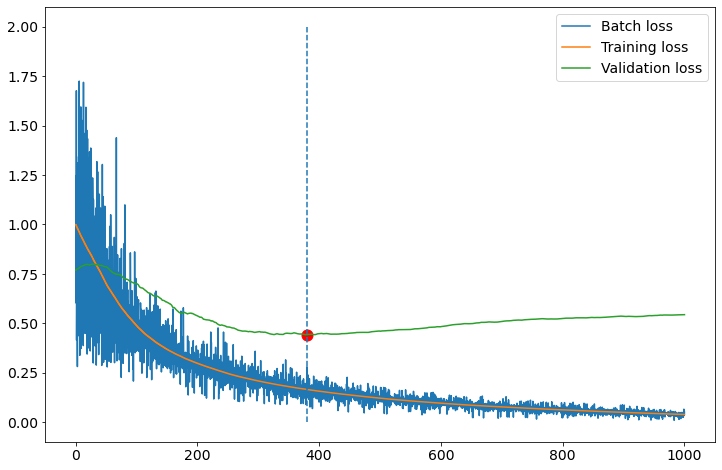

      1100       3300   0.030282   0.028402   0.553304     0.441721(379)   0.000500
      1200       3600   0.020286   0.020089   0.568527     0.441721(379)   0.000500
      1300       3900   0.029576   0.013606   0.586744     0.441721(379)   0.000500
      1400       4200   0.017763   0.008997   0.604487     0.441721(379)   0.000500
      1500       4500   0.004003   0.005957   0.613015     0.441721(379)   0.000500
      1600       4800   0.006451   0.004027   0.616281     0.441721(379)   0.000500
      1700       5100   0.003378   0.002819   0.617214     0.441721(379)   0.000500
      1800       5400   0.000091   0.002113   0.615316     0.441721(379)   0.000500
      1900       5700   0.002166   0.001667   0.610777     0.441721(379)   0.000500
      2000       6000   0.002193   0.001348   0.608360     0.441721(379)   0.000500


<Figure size 432x288 with 0 Axes>

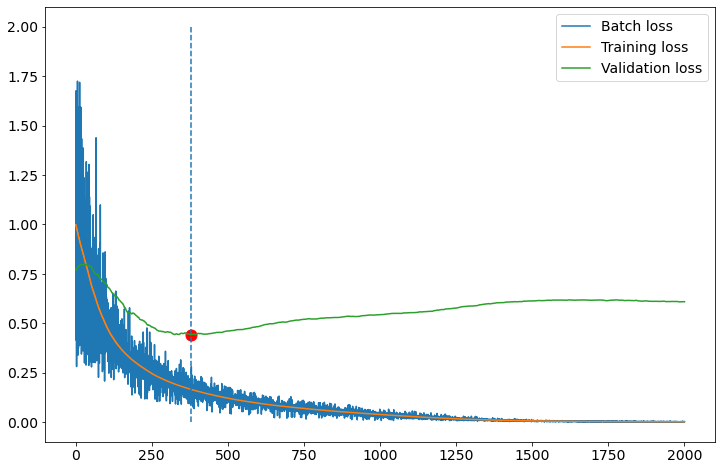

      2100       6300   0.001616   0.001080   0.605298     0.441721(379)   0.000500
      2200       6600   0.000232   0.000832   0.602333     0.441721(379)   0.000500
      2300       6900   0.000828   0.000577   0.604277     0.441721(379)   0.000500
      2400       7200   0.000093   0.000360   0.604193     0.441721(379)   0.000500
      2500       7500   0.000046   0.000191   0.606182     0.441721(379)   0.000500
      2600       7800   0.000135   0.000085   0.606881     0.441721(379)   0.000500
      2700       8100   0.000066   0.000030   0.606536     0.441721(379)   0.000500
      2800       8400   0.000003   0.000009   0.606591     0.441721(379)   0.000500
      2900       8700   0.000000   0.000002   0.606761     0.441721(379)   0.000500
      3000       9000   0.000001   0.000000   0.606755     0.441721(379)   0.000500


<Figure size 432x288 with 0 Axes>

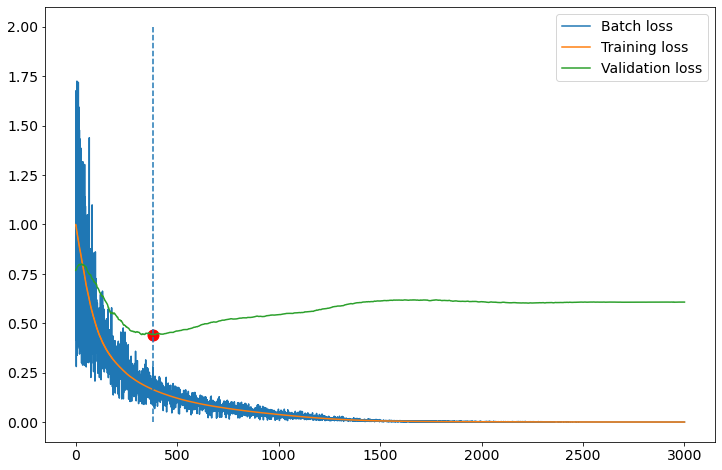

Fold 1:
  Train: index=[ 1  2  3  5  6  7  8  9 11 12 14 15 16 17]
  Test:  index=[ 0  4 10 13]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.901006   1.101732   0.493580     0.492328(0)   0.000500
       100        300   0.368894   0.559467   0.454407     0.453514(68)   0.000500
       200        600   0.258033   0.298495   0.483467     0.453514(68)   0.000500
       300        900   0.269716   0.187523   0.486733     0.453514(68)   0.000500
       400       1200   0.172447   0.130411   0.504522     0.453514(68)   0.000500
       500       1500   0.093705   0.101770   0.530521     0.453514(68)   0.000500
       600       1800   0.091959   0.083392   0.554474     0.453514(68)   0.000500
       700       2100   0.077356   0.068708   0.575735     0.453514(68)   0.000500
       800       2400   0.069420   0.056178   0.596953     0.453514(68)   0.000500
       900       2700   0.043058   0.045774   0.617301     0.453514(68)   0.

<Figure size 432x288 with 0 Axes>

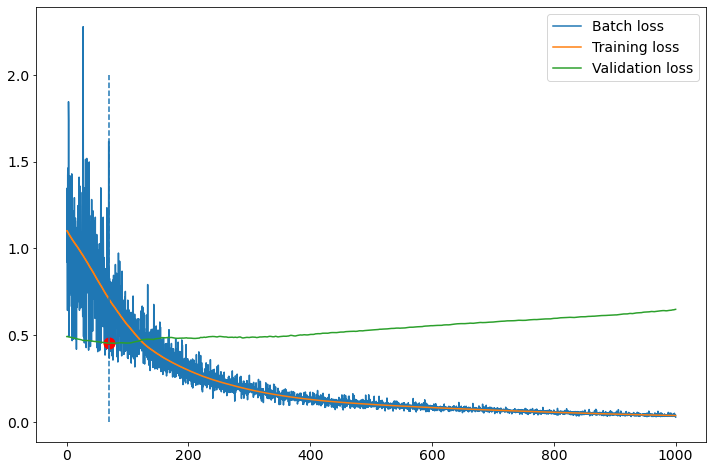

      1100       3300   0.034114   0.030446   0.672655     0.453514(68)   0.000500
      1200       3600   0.030050   0.024812   0.692340     0.453514(68)   0.000500
      1300       3900   0.014684   0.020012   0.706442     0.453514(68)   0.000500
      1400       4200   0.017845   0.015900   0.716347     0.453514(68)   0.000500
      1500       4500   0.013840   0.012325   0.722833     0.453514(68)   0.000500
      1600       4800   0.016512   0.009428   0.738354     0.453514(68)   0.000500
      1700       5100   0.007223   0.006980   0.752031     0.453514(68)   0.000500
      1800       5400   0.003984   0.004905   0.763452     0.453514(68)   0.000500
      1900       5700   0.005434   0.003209   0.776679     0.453514(68)   0.000500
      2000       6000   0.001112   0.001889   0.786607     0.453514(68)   0.000500


<Figure size 432x288 with 0 Axes>

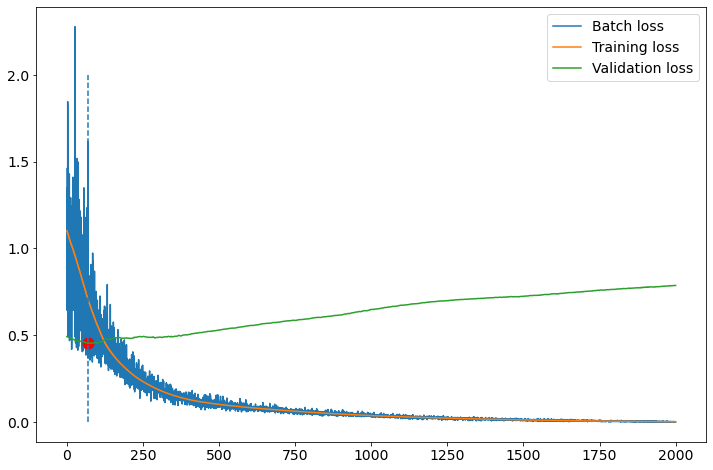

      2100       6300   0.000252   0.001033   0.795382     0.453514(68)   0.000500
      2200       6600   0.000863   0.000508   0.801671     0.453514(68)   0.000500
      2300       6900   0.000332   0.000233   0.805373     0.453514(68)   0.000500
      2400       7200   0.000028   0.000100   0.806991     0.453514(68)   0.000500
      2500       7500   0.000008   0.000038   0.810671     0.453514(68)   0.000500
      2600       7800   0.000005   0.000013   0.812766     0.453514(68)   0.000500
      2700       8100   0.000002   0.000004   0.813980     0.453514(68)   0.000500
      2800       8400   0.000001   0.000001   0.814963     0.453514(68)   0.000500
      2900       8700   0.000001   0.000002   0.816377     0.453514(68)   0.000500
      3000       9000   0.000012   0.000003   0.813234     0.453514(68)   0.000500


<Figure size 432x288 with 0 Axes>

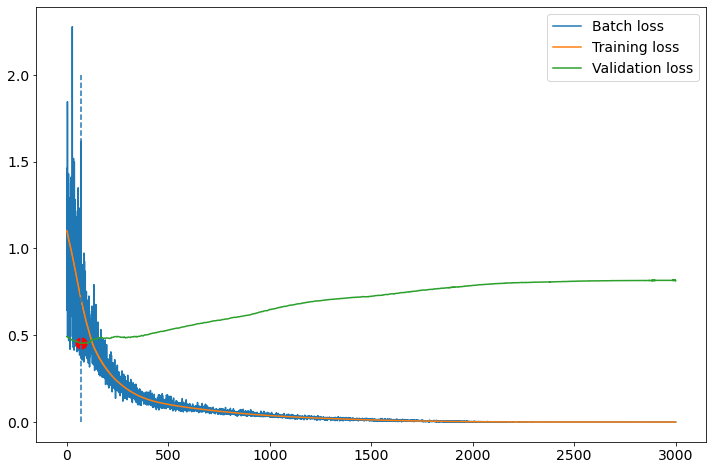

Fold 2:
  Train: index=[ 0  2  3  4  5  6  8  9 10 12 13 14 15 17]
  Test:  index=[ 1  7 11 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.296655   0.848699   1.282762     1.281725(0)   0.000500
       100        300   0.319851   0.430007   1.029263     1.029263(99)   0.000500
       200        600   0.205551   0.248210   0.993194     0.949355(154)   0.000500
       300        900   0.173525   0.173824   1.083232     0.949355(154)   0.000500
       400       1200   0.110565   0.134385   1.111971     0.949355(154)   0.000500
       500       1500   0.102230   0.109930   1.106016     0.949355(154)   0.000500
       600       1800   0.091882   0.091386   1.090671     0.949355(154)   0.000500
       700       2100   0.045268   0.076066   1.085760     0.949355(154)   0.000500
       800       2400   0.062217   0.063049   1.076962     0.949355(154)   0.000500
       900       2700   0.060120   0.052225   1.069854     0.949355(1

<Figure size 432x288 with 0 Axes>

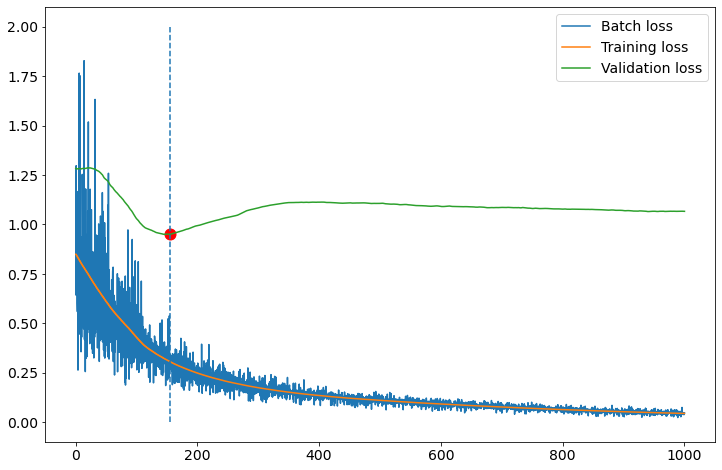

      1100       3300   0.049330   0.036803   1.071199     0.949355(154)   0.000500
      1200       3600   0.029665   0.031233   1.078942     0.949355(154)   0.000500
      1300       3900   0.039867   0.026538   1.093199     0.949355(154)   0.000500
      1400       4200   0.016670   0.022095   1.105056     0.949355(154)   0.000500
      1500       4500   0.028851   0.017862   1.113924     0.949355(154)   0.000500
      1600       4800   0.015555   0.014064   1.120533     0.949355(154)   0.000500
      1700       5100   0.007777   0.010666   1.119241     0.949355(154)   0.000500
      1800       5400   0.003222   0.007777   1.119001     0.949355(154)   0.000500
      1900       5700   0.004228   0.005268   1.118708     0.949355(154)   0.000500
      2000       6000   0.003763   0.003332   1.118929     0.949355(154)   0.000500


<Figure size 432x288 with 0 Axes>

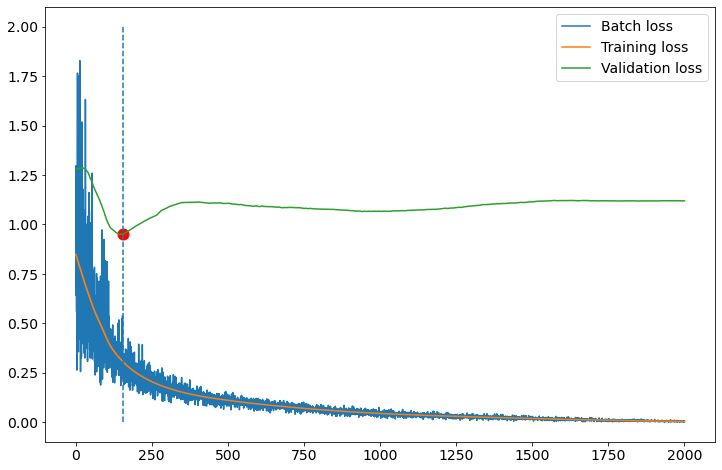

      2100       6300   0.003225   0.001901   1.117854     0.949355(154)   0.000500
      2200       6600   0.000989   0.000955   1.111507     0.949355(154)   0.000500
      2300       6900   0.000575   0.000408   1.104864     0.949355(154)   0.000500
      2400       7200   0.000127   0.000146   1.101441     0.949355(154)   0.000500
      2500       7500   0.000039   0.000042   1.099476     0.949355(154)   0.000500
      2600       7800   0.000015   0.000010   1.097682     0.949355(154)   0.000500
      2700       8100   0.000000   0.000002   1.096650     0.949355(154)   0.000500
      2800       8400   0.000000   0.000000   1.096177     0.949355(154)   0.000500
      2900       8700   0.000000   0.000000   1.095884     0.949355(154)   0.000500
      3000       9000   0.000008   0.000003   1.095355     0.949355(154)   0.000500


<Figure size 432x288 with 0 Axes>

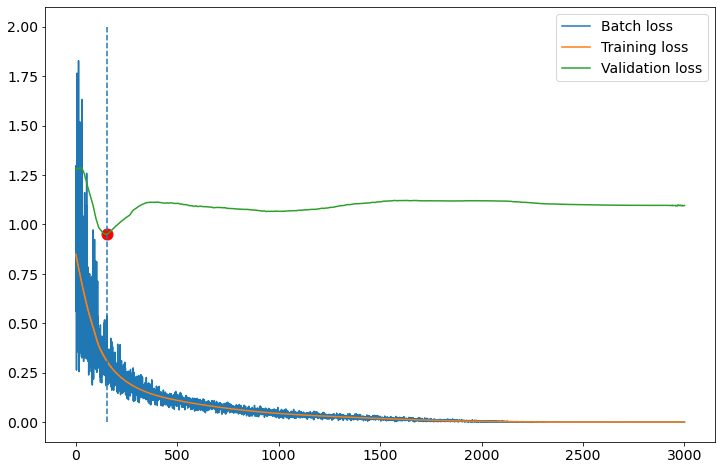

Fold 3:
  Train: index=[ 0  1  2  3  4  5  7  9 10 11 12 13 14 16 17]
  Test:  index=[ 6  8 15]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.506964   0.922000   1.331144     1.331144(0)   0.000500
       100        300   0.371758   0.412154   1.219604     1.219604(99)   0.000500
       200        600   0.264619   0.239307   1.134677     1.133990(194)   0.000500
       300        900   0.145718   0.176650   1.114350     1.111675(274)   0.000500
       400       1200   0.135274   0.139998   1.127810     1.111675(274)   0.000500
       500       1500   0.117792   0.114876   1.137731     1.111675(274)   0.000500
       600       1800   0.081700   0.095237   1.142411     1.111675(274)   0.000500
       700       2100   0.060371   0.077893   1.148740     1.111675(274)   0.000500
       800       2400   0.055035   0.062912   1.151153     1.111675(274)   0.000500
       900       2700   0.051514   0.051029   1.144266     1.111675(2

<Figure size 432x288 with 0 Axes>

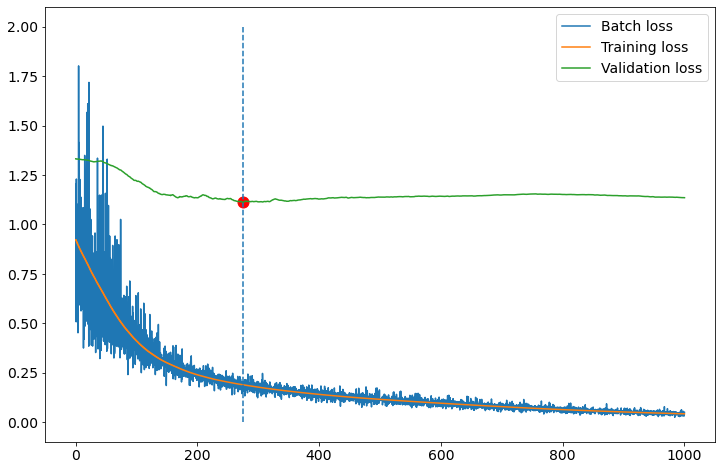

      1100       3300   0.030390   0.033838   1.131417     1.111675(274)   0.000500
      1200       3600   0.032649   0.026950   1.129740     1.111675(274)   0.000500
      1300       3900   0.023577   0.020909   1.131180     1.111675(274)   0.000500
      1400       4200   0.019738   0.015762   1.139273     1.111675(274)   0.000500
      1500       4500   0.016356   0.011653   1.160954     1.111675(274)   0.000500
      1600       4800   0.010047   0.008417   1.186862     1.111675(274)   0.000500
      1700       5100   0.007791   0.005983   1.207573     1.111675(274)   0.000500
      1800       5400   0.005731   0.004244   1.222984     1.111675(274)   0.000500
      1900       5700   0.002317   0.003036   1.235027     1.111675(274)   0.000500
      2000       6000   0.002103   0.002188   1.247968     1.111675(274)   0.000500


<Figure size 432x288 with 0 Axes>

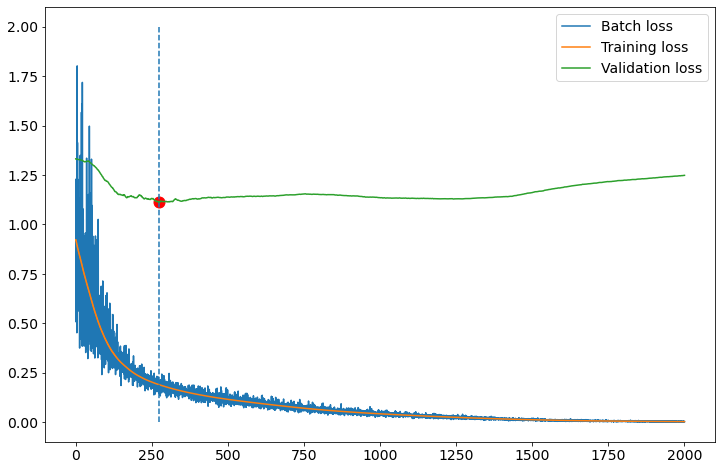

      2100       6300   0.000090   0.001552   1.259477     1.111675(274)   0.000500
      2200       6600   0.000277   0.001040   1.271065     1.111675(274)   0.000500
      2300       6900   0.000465   0.000616   1.284149     1.111675(274)   0.000500
      2400       7200   0.000456   0.000318   1.292149     1.111675(274)   0.000500
      2500       7500   0.000175   0.000135   1.300126     1.111675(274)   0.000500
      2600       7800   0.000045   0.000048   1.306724     1.111675(274)   0.000500
      2700       8100   0.000016   0.000015   1.311994     1.111675(274)   0.000500
      2800       8400   0.000001   0.000004   1.315098     1.111675(274)   0.000500
      2900       8700   0.000002   0.000001   1.316673     1.111675(274)   0.000500
      3000       9000   0.000001   0.000000   1.317457     1.111675(274)   0.000500


<Figure size 432x288 with 0 Axes>

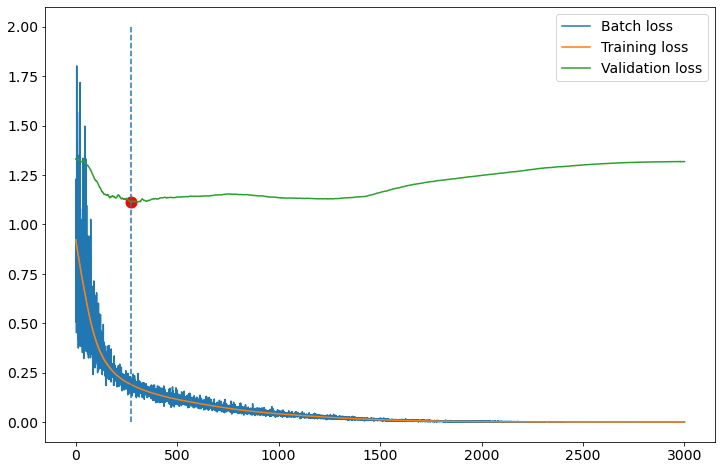

Fold 4:
  Train: index=[ 0  1  3  4  5  6  7  8 10 11 13 14 15 16 17]
  Test:  index=[ 2  9 12]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.064466   0.890904   1.175563     1.172469(0)   0.000500
       100        300   0.539921   0.411146   0.884226     0.884226(99)   0.000500
       200        600   0.279851   0.226945   0.798134     0.785394(182)   0.000500
       300        900   0.154621   0.153680   0.801187     0.785394(182)   0.000500
       400       1200   0.099448   0.116923   0.814006     0.785394(182)   0.000500
       500       1500   0.101114   0.093596   0.818141     0.785394(182)   0.000500
       600       1800   0.056400   0.075575   0.827620     0.785394(182)   0.000500
       700       2100   0.075112   0.061379   0.839919     0.785394(182)   0.000500
       800       2400   0.044477   0.050957   0.859250     0.785394(182)   0.000500
       900       2700   0.041228   0.042968   0.884062     0.785394(1

<Figure size 432x288 with 0 Axes>

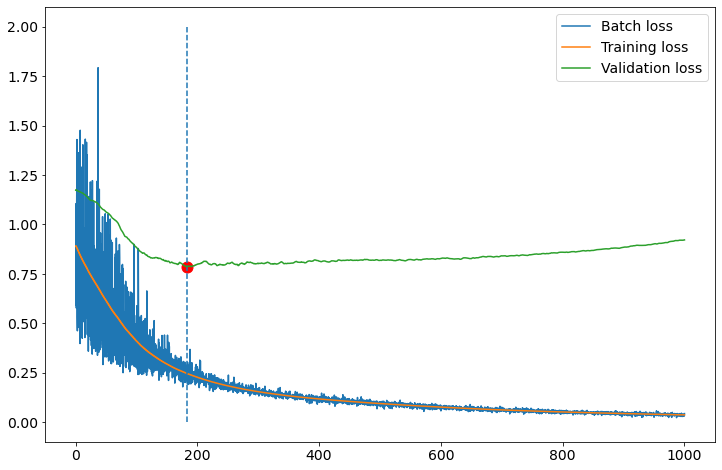

      1100       3300   0.025177   0.029984   0.966586     0.785394(182)   0.000500
      1200       3600   0.028683   0.024372   1.013416     0.785394(182)   0.000500
      1300       3900   0.013633   0.019453   1.049292     0.785394(182)   0.000500
      1400       4200   0.014825   0.015094   1.071742     0.785394(182)   0.000500
      1500       4500   0.005488   0.011195   1.079997     0.785394(182)   0.000500
      1600       4800   0.008672   0.007840   1.075285     0.785394(182)   0.000500
      1700       5100   0.003024   0.005110   1.068867     0.785394(182)   0.000500
      1800       5400   0.001371   0.003146   1.057324     0.785394(182)   0.000500
      1900       5700   0.001848   0.001846   1.042477     0.785394(182)   0.000500
      2000       6000   0.001287   0.001050   1.033100     0.785394(182)   0.000500


<Figure size 432x288 with 0 Axes>

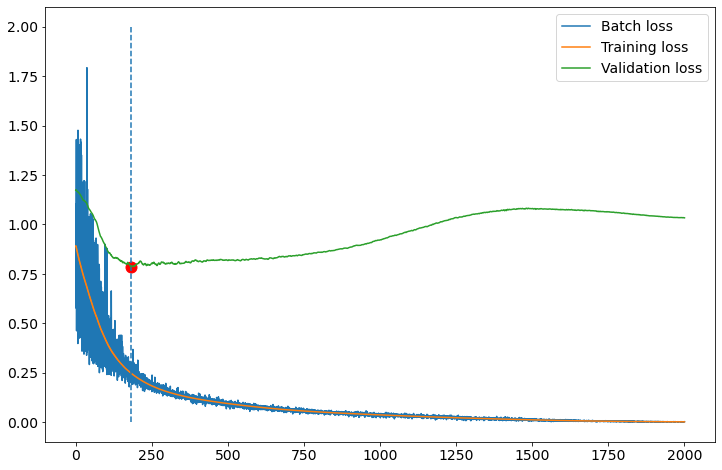

      2100       6300   0.000356   0.000597   1.026173     0.785394(182)   0.000500
      2200       6600   0.000433   0.000348   1.022817     0.785394(182)   0.000500
      2300       6900   0.000308   0.000206   1.022302     0.785394(182)   0.000500
      2400       7200   0.000066   0.000123   1.023668     0.785394(182)   0.000500
      2500       7500   0.000101   0.000071   1.026136     0.785394(182)   0.000500
      2600       7800   0.000027   0.000041   1.030154     0.785394(182)   0.000500
      2700       8100   0.000043   0.000022   1.034173     0.785394(182)   0.000500
      2800       8400   0.000016   0.000012   1.037548     0.785394(182)   0.000500
      2900       8700   0.000007   0.000007   1.041701     0.785394(182)   0.000500
      3000       9000   0.000013   0.000007   1.045868     0.785394(182)   0.000500


<Figure size 432x288 with 0 Axes>

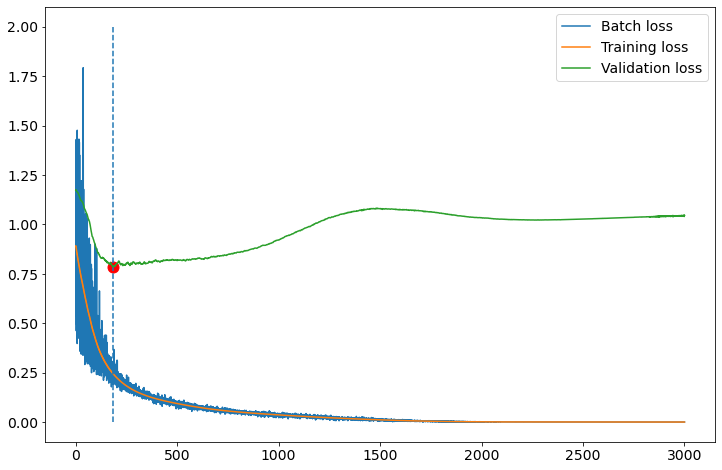

222
Fold 0:
  Train: index=[ 0  2  3  4  5  6  8  9 11 12 13 14 16 17]
  Test:  index=[ 1  7 10 15]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.850934   1.108695   0.485867     0.485867(0)   0.000500
       100        300   0.471628   0.539349   0.544289     0.454090(44)   0.000500
       200        600   0.304517   0.255982   0.943112     0.454090(44)   0.000500
       300        900   0.190957   0.167775   0.925024     0.454090(44)   0.000500
       400       1200   0.139117   0.128931   0.913202     0.454090(44)   0.000500
       500       1500   0.091850   0.107415   0.924853     0.454090(44)   0.000500
       600       1800   0.094186   0.092055   0.930002     0.454090(44)   0.000500
       700       2100   0.080965   0.079792   0.934071     0.454090(44)   0.000500
       800       2400   0.061775   0.069652   0.937557     0.454090(44)   0.000500
       900       2700   0.056915   0.060556   0.937525     0.454090(44) 

<Figure size 432x288 with 0 Axes>

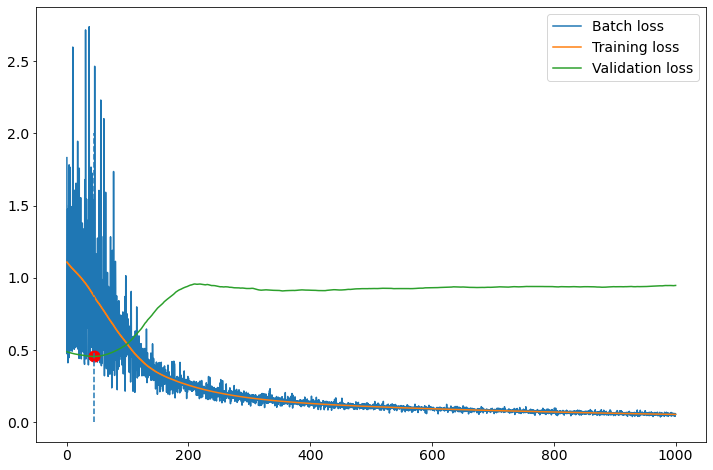

      1100       3300   0.035340   0.045952   0.953469     0.454090(44)   0.000500
      1200       3600   0.048969   0.040291   0.963157     0.454090(44)   0.000500
      1300       3900   0.043953   0.035751   0.972039     0.454090(44)   0.000500
      1400       4200   0.025498   0.032095   0.980740     0.454090(44)   0.000500
      1500       4500   0.031511   0.029102   0.983849     0.454090(44)   0.000500
      1600       4800   0.021308   0.026519   0.989782     0.454090(44)   0.000500
      1700       5100   0.026631   0.024133   0.993075     0.454090(44)   0.000500
      1800       5400   0.021967   0.021902   0.999478     0.454090(44)   0.000500
      1900       5700   0.011295   0.019793   1.011435     0.454090(44)   0.000500
      2000       6000   0.009343   0.017654   1.029953     0.454090(44)   0.000500


<Figure size 432x288 with 0 Axes>

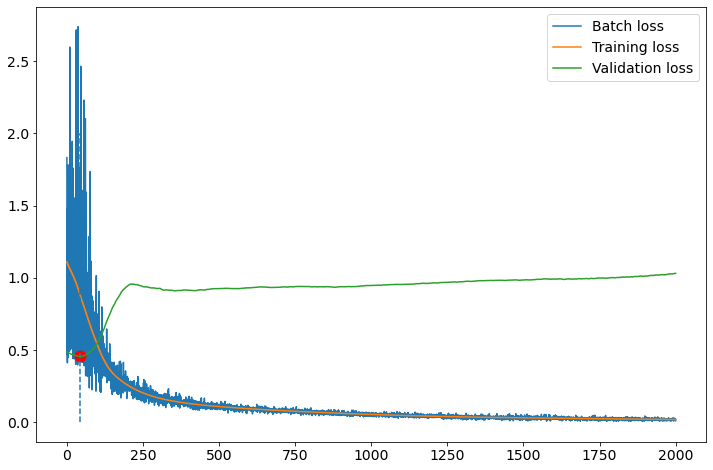

      2100       6300   0.008068   0.015390   1.061530     0.454090(44)   0.000500
      2200       6600   0.010164   0.013247   1.077499     0.454090(44)   0.000500
      2300       6900   0.008713   0.011237   1.094666     0.454090(44)   0.000500
      2400       7200   0.015513   0.009457   1.108579     0.454090(44)   0.000500
      2500       7500   0.002452   0.007936   1.126498     0.454090(44)   0.000500
      2600       7800   0.009427   0.006530   1.146085     0.454090(44)   0.000500
      2700       8100   0.001462   0.005236   1.165181     0.454090(44)   0.000500
      2800       8400   0.003325   0.004087   1.180372     0.454090(44)   0.000500
      2900       8700   0.004814   0.003025   1.196898     0.454090(44)   0.000500
      3000       9000   0.001480   0.002127   1.213281     0.454090(44)   0.000500


<Figure size 432x288 with 0 Axes>

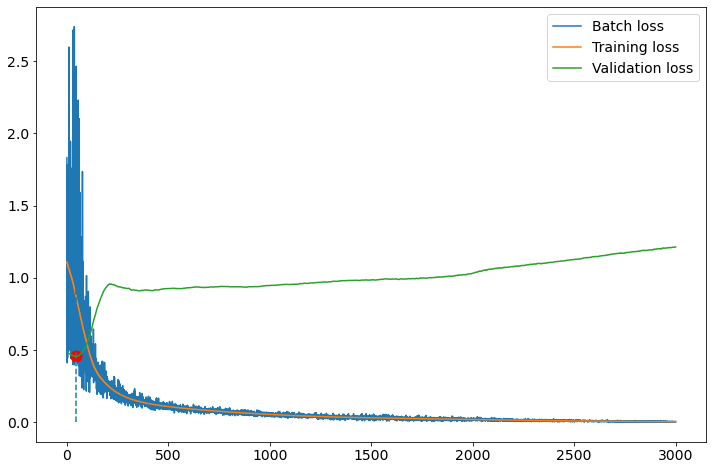

Fold 1:
  Train: index=[ 1  2  3  5  6  7  8  9 10 12 13 14 15 17]
  Test:  index=[ 0  4 11 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.563971   0.929748   1.312065     1.311862(0)   0.000500
       100        300   0.291786   0.498313   1.051741     1.051741(99)   0.000500
       200        600   0.198688   0.260050   0.837693     0.837693(199)   0.000500
       300        900   0.160202   0.173879   0.886593     0.835432(202)   0.000500
       400       1200   0.125946   0.127390   0.955347     0.835432(202)   0.000500
       500       1500   0.081122   0.100090   1.016172     0.835432(202)   0.000500
       600       1800   0.073154   0.082597   1.063519     0.835432(202)   0.000500
       700       2100   0.063714   0.070165   1.100152     0.835432(202)   0.000500
       800       2400   0.072043   0.060410   1.132295     0.835432(202)   0.000500
       900       2700   0.057058   0.053537   1.166383     0.835432(2

<Figure size 432x288 with 0 Axes>

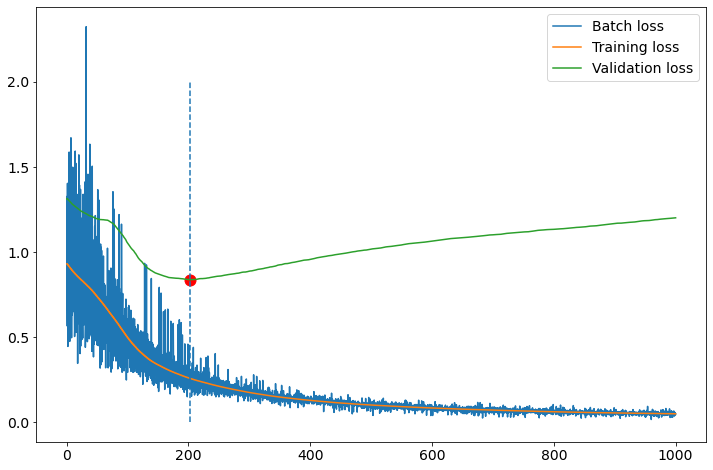

      1100       3300   0.062213   0.044413   1.232325     0.835432(202)   0.000500
      1200       3600   0.037671   0.040625   1.257946     0.835432(202)   0.000500
      1300       3900   0.049531   0.036822   1.276347     0.835432(202)   0.000500
      1400       4200   0.023373   0.032806   1.286740     0.835432(202)   0.000500
      1500       4500   0.031821   0.028709   1.274687     0.835432(202)   0.000500
      1600       4800   0.037584   0.024420   1.272613     0.835432(202)   0.000500
      1700       5100   0.013633   0.020169   1.275361     0.835432(202)   0.000500
      1800       5400   0.012862   0.015858   1.279022     0.835432(202)   0.000500
      1900       5700   0.013221   0.011744   1.284841     0.835432(202)   0.000500
      2000       6000   0.005464   0.008010   1.288302     0.835432(202)   0.000500


<Figure size 432x288 with 0 Axes>

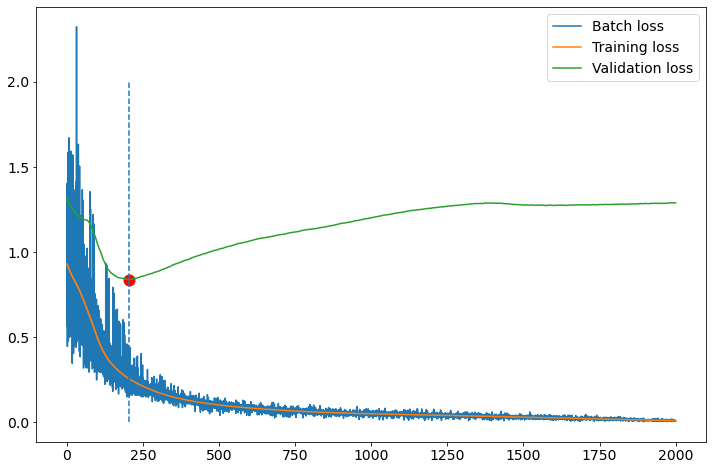

      2100       6300   0.003850   0.004961   1.294742     0.835432(202)   0.000500
      2200       6600   0.002250   0.002768   1.303155     0.835432(202)   0.000500
      2300       6900   0.002180   0.001342   1.309949     0.835432(202)   0.000500
      2400       7200   0.001092   0.000572   1.318504     0.835432(202)   0.000500
      2500       7500   0.000377   0.000212   1.325243     0.835432(202)   0.000500
      2600       7800   0.000028   0.000073   1.330473     0.835432(202)   0.000500
      2700       8100   0.000050   0.000024   1.332718     0.835432(202)   0.000500
      2800       8400   0.000014   0.000007   1.333684     0.835432(202)   0.000500
      2900       8700   0.000001   0.000002   1.334096     0.835432(202)   0.000500
      3000       9000   0.000000   0.000001   1.334241     0.835432(202)   0.000500


<Figure size 432x288 with 0 Axes>

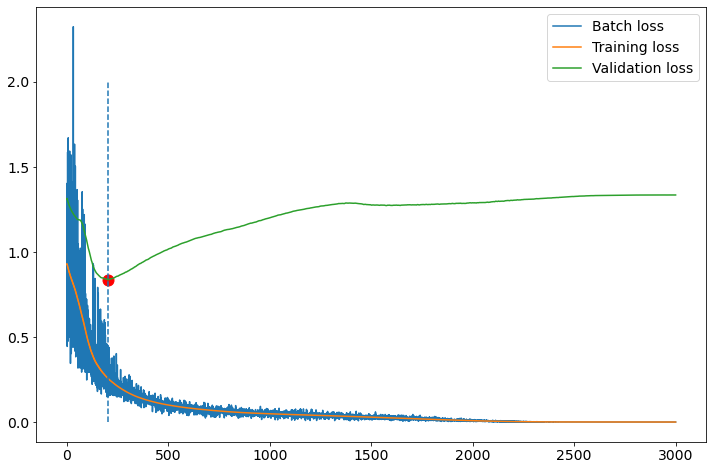

Fold 2:
  Train: index=[ 0  1  2  3  4  6  7 10 11 12 13 14 15 16]
  Test:  index=[ 5  8  9 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   2.664324   1.030070   1.258972     1.258972(0)   0.000500
       100        300   0.436639   0.447068   0.969444     0.969444(99)   0.000500
       200        600   0.253190   0.252352   0.845912     0.845375(198)   0.000500
       300        900   0.171292   0.166881   0.823500     0.819184(285)   0.000500
       400       1200   0.076430   0.121275   0.804587     0.804587(399)   0.000500
       500       1500   0.065278   0.092905   0.808683     0.800596(422)   0.000500
       600       1800   0.085435   0.071608   0.806550     0.800596(422)   0.000500
       700       2100   0.064210   0.055640   0.806034     0.800596(422)   0.000500
       800       2400   0.068488   0.043985   0.810098     0.800596(422)   0.000500
       900       2700   0.042482   0.034901   0.815091     0.800596(4

<Figure size 432x288 with 0 Axes>

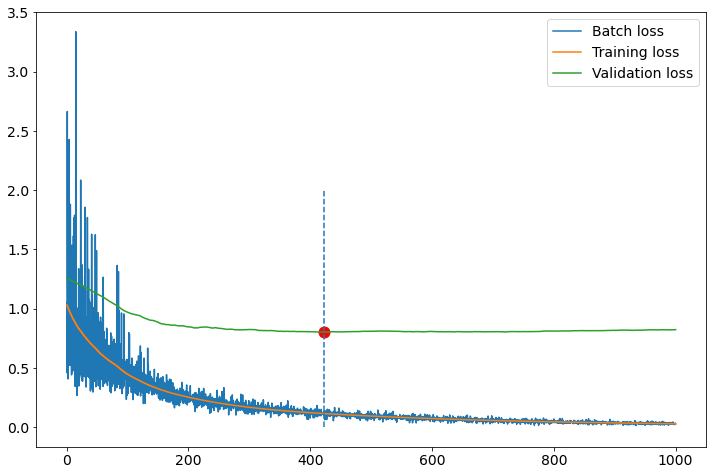

      1100       3300   0.023032   0.021431   0.820390     0.800596(422)   0.000500
      1200       3600   0.018619   0.016269   0.819976     0.800596(422)   0.000500
      1300       3900   0.006483   0.011851   0.814353     0.800596(422)   0.000500
      1400       4200   0.009441   0.008323   0.802083     0.800596(422)   0.000500
      1500       4500   0.004115   0.005636   0.794161     0.793883(1498)   0.000500
      1600       4800   0.003389   0.003776   0.790972     0.790545(1596)   0.000500
      1700       5100   0.005526   0.002566   0.789440     0.788714(1637)   0.000500
      1800       5400   0.002248   0.001757   0.790798     0.788714(1637)   0.000500
      1900       5700   0.001754   0.001263   0.796627     0.788714(1637)   0.000500
      2000       6000   0.000831   0.000940   0.798868     0.788714(1637)   0.000500


<Figure size 432x288 with 0 Axes>

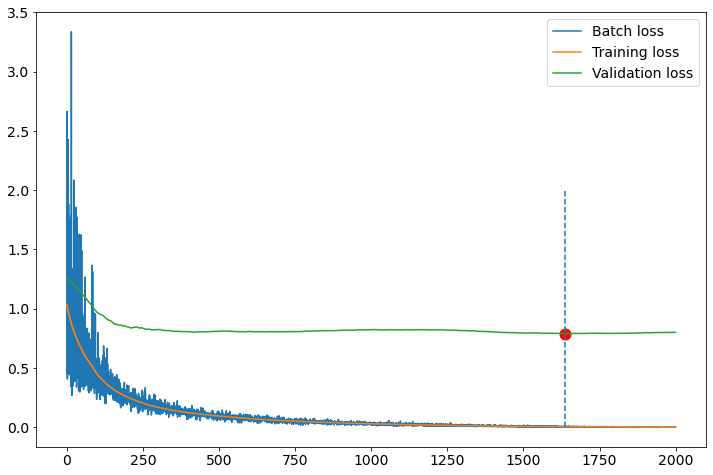

      2100       6300   0.000204   0.000723   0.799142     0.788714(1637)   0.000500
      2200       6600   0.000762   0.000560   0.799206     0.788714(1637)   0.000500
      2300       6900   0.000173   0.000438   0.798898     0.788714(1637)   0.000500
      2400       7200   0.000047   0.000327   0.800145     0.788714(1637)   0.000500
      2500       7500   0.000532   0.000236   0.800516     0.788714(1637)   0.000500
      2600       7800   0.000202   0.000161   0.801035     0.788714(1637)   0.000500
      2700       8100   0.000140   0.000105   0.801460     0.788714(1637)   0.000500
      2800       8400   0.000019   0.000065   0.802325     0.788714(1637)   0.000500
      2900       8700   0.000073   0.000036   0.802005     0.788714(1637)   0.000500
      3000       9000   0.000014   0.000019   0.805521     0.788714(1637)   0.000500


<Figure size 432x288 with 0 Axes>

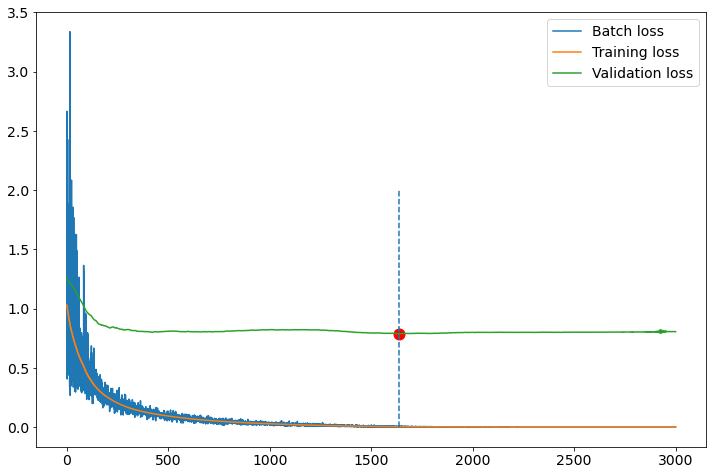

Fold 3:
  Train: index=[ 0  1  3  4  5  6  7  8  9 10 11 13 15 16 17]
  Test:  index=[ 2 12 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.715776   0.891348   1.200206     1.200206(0)   0.000500
       100        300   0.328920   0.450544   0.763378     0.763378(99)   0.000500
       200        600   0.277329   0.215141   0.680679     0.680679(199)   0.000500
       300        900   0.121488   0.131133   0.685895     0.676766(213)   0.000500
       400       1200   0.108392   0.093175   0.684905     0.676766(213)   0.000500
       500       1500   0.079248   0.071874   0.695467     0.676766(213)   0.000500
       600       1800   0.088488   0.057846   0.699057     0.676766(213)   0.000500
       700       2100   0.040391   0.046610   0.693692     0.676766(213)   0.000500
       800       2400   0.036470   0.036677   0.690677     0.676766(213)   0.000500
       900       2700   0.016643   0.027682   0.693643     0.676766(2

<Figure size 432x288 with 0 Axes>

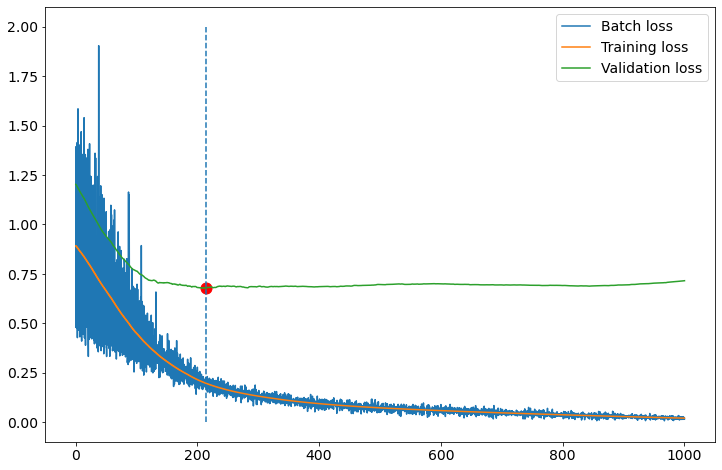

      1100       3300   0.015321   0.013036   0.750866     0.676766(213)   0.000500
      1200       3600   0.006433   0.007926   0.790408     0.676766(213)   0.000500
      1300       3900   0.003834   0.004640   0.824942     0.676766(213)   0.000500
      1400       4200   0.002473   0.002755   0.851814     0.676766(213)   0.000500
      1500       4500   0.002299   0.001701   0.872326     0.676766(213)   0.000500
      1600       4800   0.001132   0.001122   0.888676     0.676766(213)   0.000500
      1700       5100   0.000365   0.000779   0.902047     0.676766(213)   0.000500
      1800       5400   0.000583   0.000568   0.909634     0.676766(213)   0.000500
      1900       5700   0.000155   0.000416   0.914947     0.676766(213)   0.000500
      2000       6000   0.000404   0.000300   0.917500     0.676766(213)   0.000500


<Figure size 432x288 with 0 Axes>

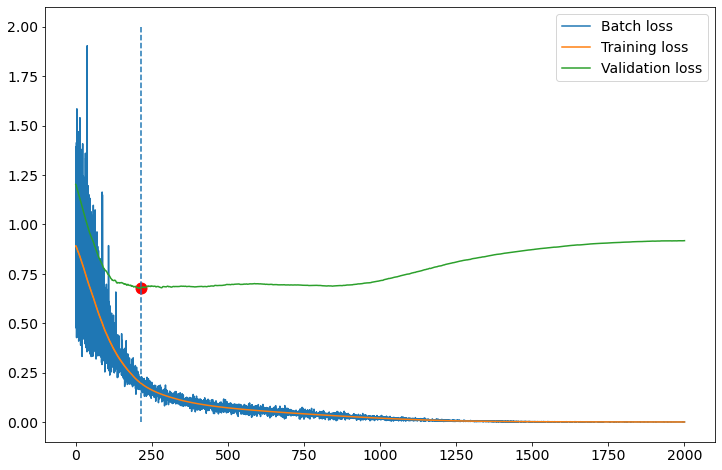

      2100       6300   0.000196   0.000202   0.918197     0.676766(213)   0.000500
      2200       6600   0.000190   0.000126   0.916745     0.676766(213)   0.000500
      2300       6900   0.000190   0.000072   0.915117     0.676766(213)   0.000500
      2400       7200   0.000039   0.000036   0.913584     0.676766(213)   0.000500
      2500       7500   0.000011   0.000017   0.911760     0.676766(213)   0.000500
      2600       7800   0.000009   0.000007   0.910467     0.676766(213)   0.000500
      2700       8100   0.000007   0.000008   0.908415     0.676766(213)   0.000500
      2800       8400   0.000001   0.000002   0.908512     0.676766(213)   0.000500
      2900       8700   0.000004   0.000001   0.908750     0.676766(213)   0.000500
      3000       9000   0.000004   0.000015   0.905281     0.676766(213)   0.000500


<Figure size 432x288 with 0 Axes>

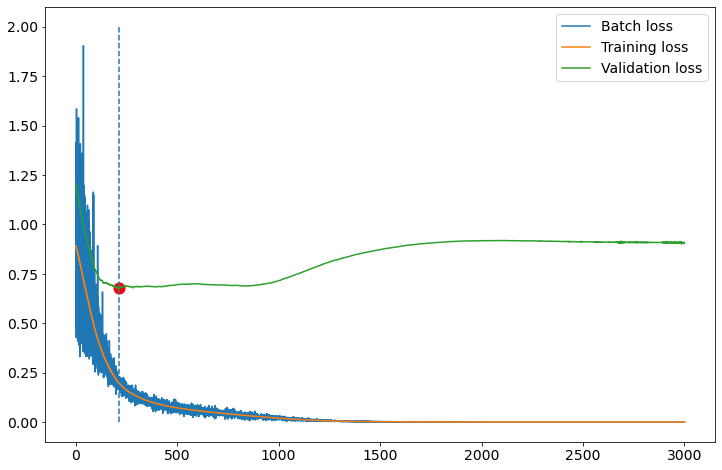

Fold 4:
  Train: index=[ 0  1  2  4  5  7  8  9 10 11 12 14 15 16 17]
  Test:  index=[ 3  6 13]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.472015   0.974643   0.874983     0.874983(0)   0.000500
       100        300   0.349593   0.431922   0.737287     0.737287(99)   0.000500
       200        600   0.251620   0.232440   0.666343     0.660205(164)   0.000500
       300        900   0.149657   0.155984   0.688870     0.660205(164)   0.000500
       400       1200   0.121599   0.110597   0.683360     0.660205(164)   0.000500
       500       1500   0.038758   0.081866   0.693402     0.660205(164)   0.000500
       600       1800   0.068170   0.062614   0.693241     0.660205(164)   0.000500
       700       2100   0.060103   0.048466   0.689762     0.660205(164)   0.000500
       800       2400   0.061890   0.037581   0.679701     0.660205(164)   0.000500
       900       2700   0.021268   0.029048   0.683136     0.660205(1

<Figure size 432x288 with 0 Axes>

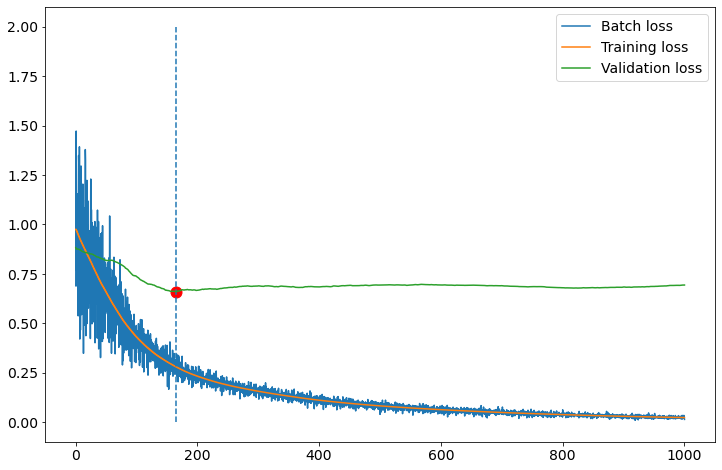

      1100       3300   0.015079   0.017917   0.706877     0.660205(164)   0.000500
      1200       3600   0.019331   0.014270   0.717666     0.660205(164)   0.000500
      1300       3900   0.009104   0.011345   0.727445     0.660205(164)   0.000500
      1400       4200   0.004301   0.008957   0.734502     0.660205(164)   0.000500
      1500       4500   0.002566   0.006969   0.742380     0.660205(164)   0.000500
      1600       4800   0.001751   0.005233   0.750808     0.660205(164)   0.000500
      1700       5100   0.005253   0.003768   0.754431     0.660205(164)   0.000500
      1800       5400   0.001969   0.002588   0.759221     0.660205(164)   0.000500
      1900       5700   0.002127   0.001765   0.764895     0.660205(164)   0.000500
      2000       6000   0.000330   0.001284   0.769504     0.660205(164)   0.000500


<Figure size 432x288 with 0 Axes>

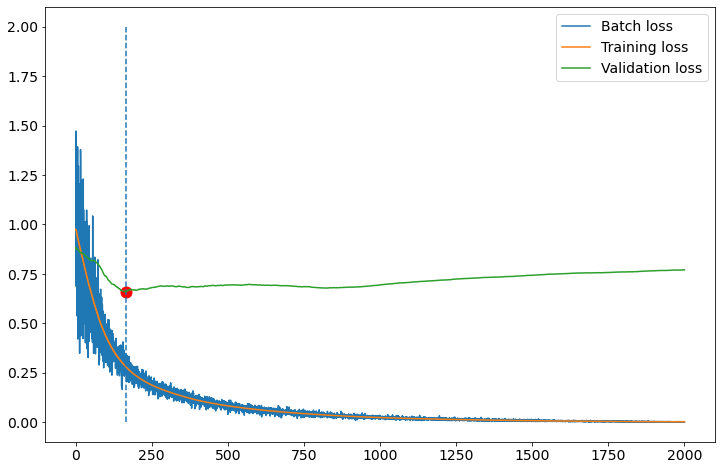

      2100       6300   0.000566   0.001007   0.774368     0.660205(164)   0.000500
      2200       6600   0.000360   0.000822   0.779358     0.660205(164)   0.000500
      2300       6900   0.000246   0.000656   0.785970     0.660205(164)   0.000500
      2400       7200   0.000464   0.000492   0.793364     0.660205(164)   0.000500
      2500       7500   0.000768   0.000327   0.798964     0.660205(164)   0.000500
      2600       7800   0.000055   0.000191   0.803667     0.660205(164)   0.000500
      2700       8100   0.000094   0.000098   0.808474     0.660205(164)   0.000500
      2800       8400   0.000050   0.000043   0.811498     0.660205(164)   0.000500
      2900       8700   0.000004   0.000018   0.815176     0.660205(164)   0.000500
      3000       9000   0.000005   0.000005   0.814630     0.660205(164)   0.000500


<Figure size 432x288 with 0 Axes>

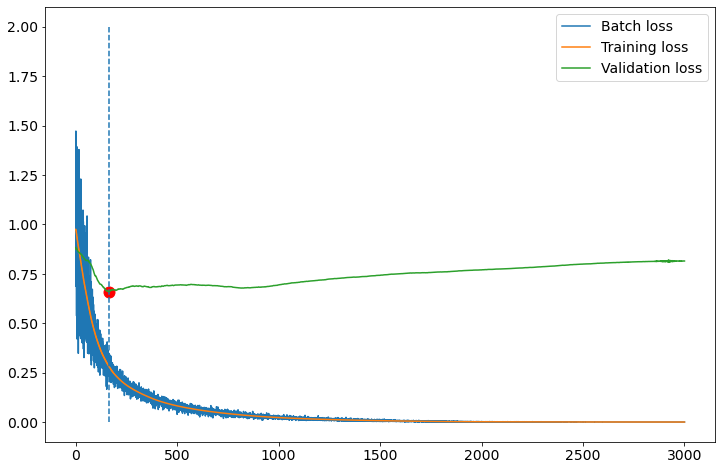

333
Fold 0:
  Train: index=[ 2  3  4  5  6  7  8 10 12 13 14 15 16 17]
  Test:  index=[ 0  1  9 11]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.655368   1.174993   0.390446     0.389994(0)   0.000500
       100        300   0.949439   0.511415   0.465969     0.389994(0)   0.000500
       200        600   0.148543   0.298780   0.572211     0.389994(0)   0.000500
       300        900   0.176426   0.185994   0.624746     0.389994(0)   0.000500
       400       1200   0.097438   0.122162   0.689429     0.389994(0)   0.000500
       500       1500   0.107865   0.091314   0.769949     0.389994(0)   0.000500
       600       1800   0.070626   0.073772   0.817174     0.389994(0)   0.000500
       700       2100   0.051731   0.062158   0.855966     0.389994(0)   0.000500
       800       2400   0.035573   0.053234   0.888550     0.389994(0)   0.000500
       900       2700   0.064801   0.045531   0.911573     0.389994(0)   0.00050

<Figure size 432x288 with 0 Axes>

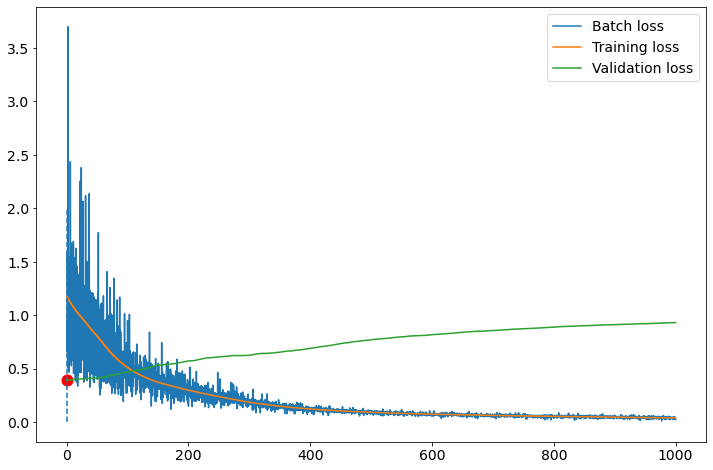

      1100       3300   0.048024   0.032743   0.940386     0.389994(0)   0.000500
      1200       3600   0.035759   0.027416   0.934257     0.389994(0)   0.000500
      1300       3900   0.021497   0.022555   0.929370     0.389994(0)   0.000500
      1400       4200   0.016548   0.018126   0.928891     0.389994(0)   0.000500
      1500       4500   0.017871   0.014280   0.922502     0.389994(0)   0.000500
      1600       4800   0.017866   0.011275   0.921361     0.389994(0)   0.000500
      1700       5100   0.006894   0.008868   0.926303     0.389994(0)   0.000500
      1800       5400   0.000859   0.006826   0.944369     0.389994(0)   0.000500
      1900       5700   0.009021   0.004974   0.969876     0.389994(0)   0.000500
      2000       6000   0.001161   0.003350   0.992240     0.389994(0)   0.000500


<Figure size 432x288 with 0 Axes>

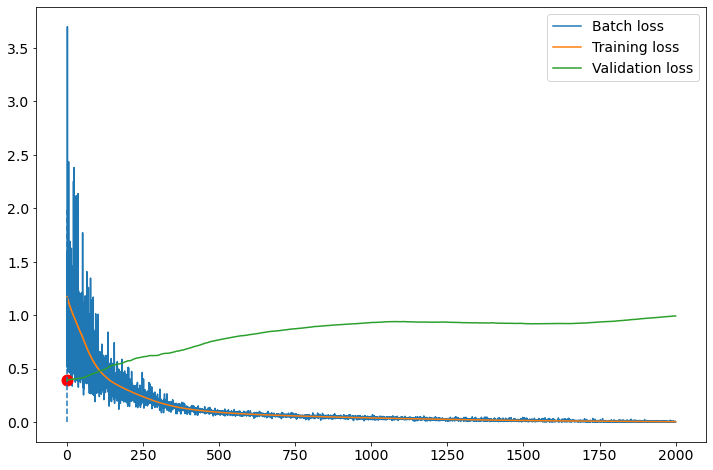

      2100       6300   0.001736   0.002014   1.009527     0.389994(0)   0.000500
      2200       6600   0.002874   0.001050   1.024369     0.389994(0)   0.000500
      2300       6900   0.000205   0.000466   1.035064     0.389994(0)   0.000500
      2400       7200   0.000493   0.000182   1.043908     0.389994(0)   0.000500
      2500       7500   0.000032   0.000057   1.049646     0.389994(0)   0.000500
      2600       7800   0.000057   0.000018   1.052402     0.389994(0)   0.000500
      2700       8100   0.000000   0.000004   1.053321     0.389994(0)   0.000500
      2800       8400   0.000001   0.000001   1.053539     0.389994(0)   0.000500
      2900       8700   0.000001   0.000000   1.051677     0.389994(0)   0.000500
      3000       9000   0.000000   0.000000   1.052017     0.389994(0)   0.000500


<Figure size 432x288 with 0 Axes>

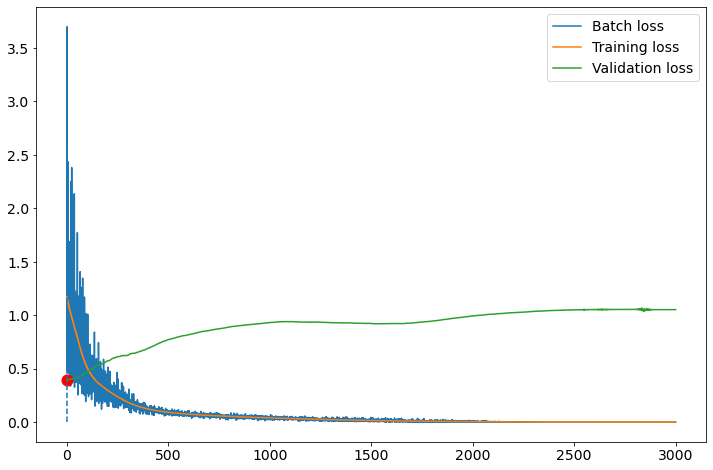

Fold 1:
  Train: index=[ 0  1  3  6  7  9 10 11 12 13 14 15 16 17]
  Test:  index=[2 4 5 8]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.432809   0.904483   1.142018     1.142018(0)   0.000500
       100        300   0.386713   0.497535   1.091063     1.091063(99)   0.000500
       200        600   0.232604   0.248895   1.053975     1.050335(183)   0.000500
       300        900   0.090436   0.160953   1.024750     1.024750(299)   0.000500
       400       1200   0.128001   0.119049   1.018442     1.016105(364)   0.000500
       500       1500   0.103260   0.090247   1.036950     1.016105(364)   0.000500
       600       1800   0.028694   0.067767   1.060767     1.016105(364)   0.000500
       700       2100   0.059301   0.051505   1.070068     1.016105(364)   0.000500
       800       2400   0.059511   0.040952   1.072864     1.016105(364)   0.000500
       900       2700   0.042767   0.033019   1.054551     1.016105(364) 

<Figure size 432x288 with 0 Axes>

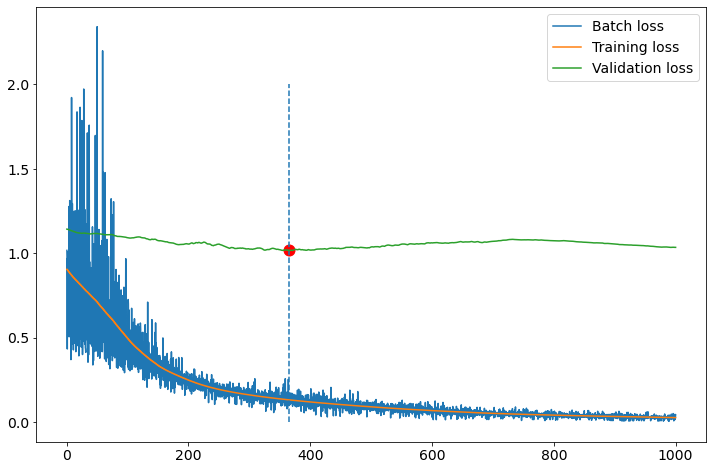

      1100       3300   0.027673   0.020181   1.010783     1.010783(1099)   0.000500
      1200       3600   0.017625   0.014975   0.993629     0.993629(1199)   0.000500
      1300       3900   0.012792   0.010509   0.979275     0.979275(1299)   0.000500
      1400       4200   0.007902   0.007092   0.976183     0.974496(1377)   0.000500
      1500       4500   0.001518   0.004495   0.975350     0.974496(1377)   0.000500
      1600       4800   0.000927   0.002642   0.982613     0.974465(1512)   0.000500
      1700       5100   0.001270   0.001458   0.989598     0.974465(1512)   0.000500
      1800       5400   0.000606   0.000722   0.995170     0.974465(1512)   0.000500
      1900       5700   0.000228   0.000332   1.000380     0.974465(1512)   0.000500
      2000       6000   0.000083   0.000137   1.005542     0.974465(1512)   0.000500


<Figure size 432x288 with 0 Axes>

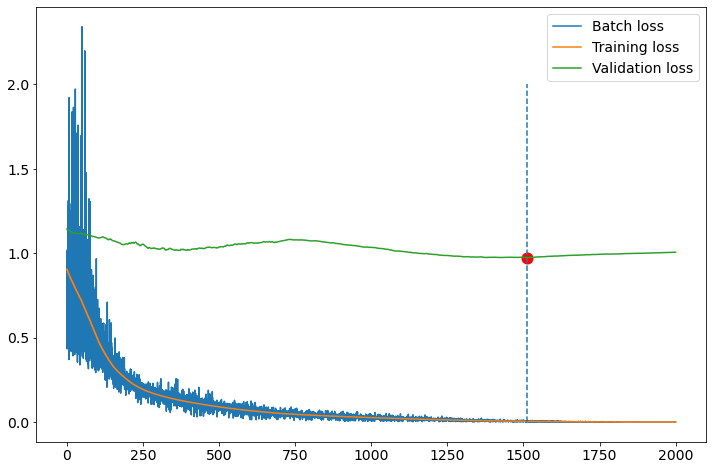

      2100       6300   0.000030   0.000051   1.011167     0.974465(1512)   0.000500
      2200       6600   0.000027   0.000017   1.015765     0.974465(1512)   0.000500
      2300       6900   0.000004   0.000005   1.019007     0.974465(1512)   0.000500
      2400       7200   0.000004   0.000001   1.021210     0.974465(1512)   0.000500
      2500       7500   0.000001   0.000000   1.022415     0.974465(1512)   0.000500
      2600       7800   0.000000   0.000000   1.023030     0.974465(1512)   0.000500
      2700       8100   0.000000   0.000000   1.023182     0.974465(1512)   0.000500
      2800       8400   0.000001   0.000001   1.019642     0.974465(1512)   0.000500
      2900       8700   0.000000   0.000000   1.019706     0.974465(1512)   0.000500
      3000       9000   0.000000   0.000000   1.019730     0.974465(1512)   0.000500


<Figure size 432x288 with 0 Axes>

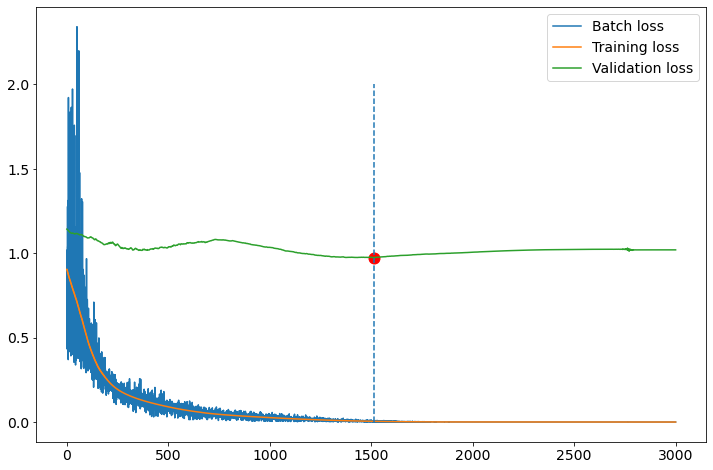

Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  8  9 11 12 13 14 17]
  Test:  index=[ 7 10 15 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.420024   0.871351   1.027199     1.021506(0)   0.000500
       100        300   0.386838   0.424171   0.832892     0.832892(99)   0.000500
       200        600   0.167387   0.235597   0.742765     0.741203(193)   0.000500
       300        900   0.137453   0.169635   0.774495     0.741203(193)   0.000500
       400       1200   0.111662   0.134273   0.805194     0.741203(193)   0.000500
       500       1500   0.102087   0.110176   0.841718     0.741203(193)   0.000500
       600       1800   0.093729   0.092638   0.873876     0.741203(193)   0.000500
       700       2100   0.071605   0.079405   0.899016     0.741203(193)   0.000500
       800       2400   0.086846   0.067740   0.921309     0.741203(193)   0.000500
       900       2700   0.084491   0.056898   0.932261     0.741203(1

<Figure size 432x288 with 0 Axes>

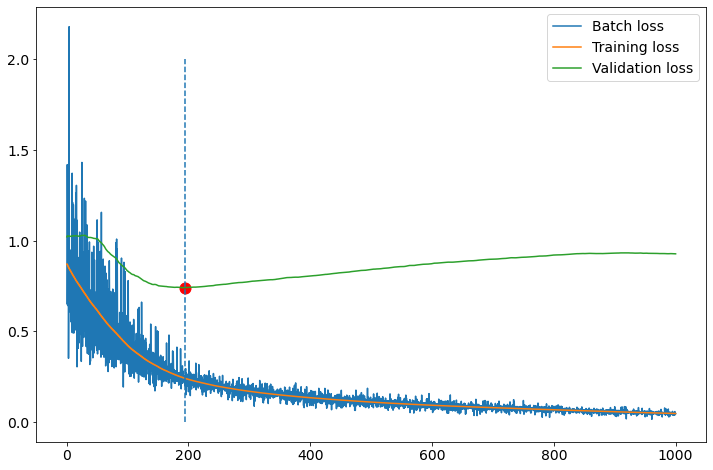

      1100       3300   0.045448   0.039326   0.925744     0.741203(193)   0.000500
      1200       3600   0.036067   0.032501   0.926233     0.741203(193)   0.000500
      1300       3900   0.044674   0.026835   0.938286     0.741203(193)   0.000500
      1400       4200   0.046550   0.022291   0.949606     0.741203(193)   0.000500
      1500       4500   0.009440   0.018503   0.966099     0.741203(193)   0.000500
      1600       4800   0.016278   0.015252   0.975257     0.741203(193)   0.000500
      1700       5100   0.001806   0.012318   0.981595     0.741203(193)   0.000500
      1800       5400   0.015110   0.009695   0.981843     0.741203(193)   0.000500
      1900       5700   0.012769   0.007408   0.983467     0.741203(193)   0.000500
      2000       6000   0.010402   0.005535   0.983181     0.741203(193)   0.000500


<Figure size 432x288 with 0 Axes>

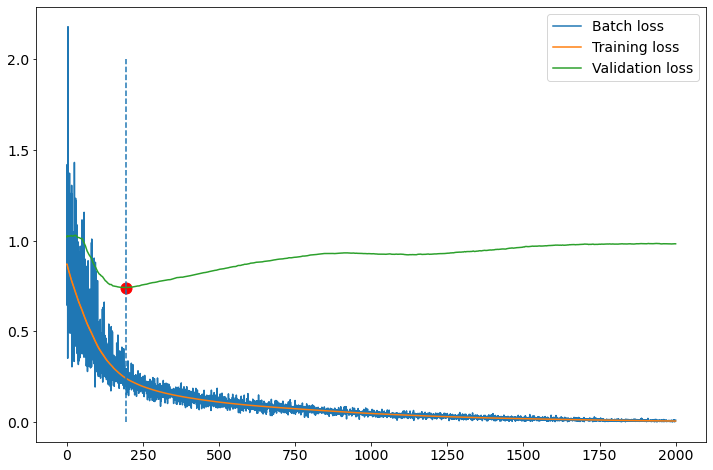

      2100       6300   0.005658   0.003976   0.981166     0.741203(193)   0.000500
      2200       6600   0.002644   0.002713   0.980084     0.741203(193)   0.000500
      2300       6900   0.001007   0.001753   0.982989     0.741203(193)   0.000500
      2400       7200   0.000793   0.001066   0.985094     0.741203(193)   0.000500
      2500       7500   0.000614   0.000617   0.989404     0.741203(193)   0.000500
      2600       7800   0.000500   0.000324   0.995566     0.741203(193)   0.000500
      2700       8100   0.000178   0.000152   1.000506     0.741203(193)   0.000500
      2800       8400   0.000005   0.000061   1.004544     0.741203(193)   0.000500
      2900       8700   0.000002   0.000021   1.006788     0.741203(193)   0.000500
      3000       9000   0.000004   0.000006   1.008251     0.741203(193)   0.000500


<Figure size 432x288 with 0 Axes>

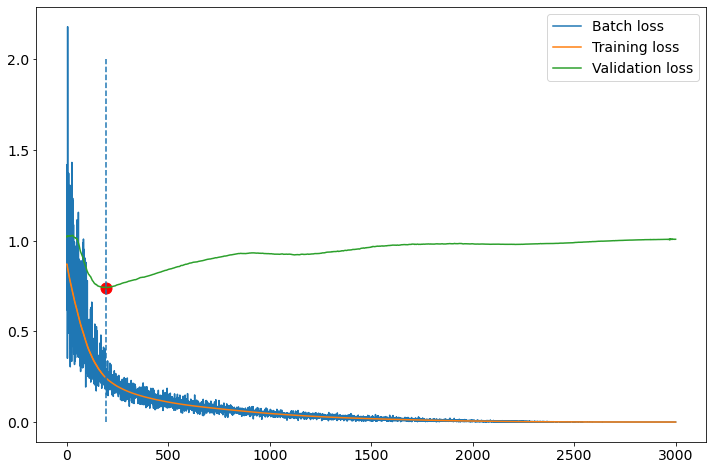

Fold 3:
  Train: index=[ 0  1  2  4  5  7  8  9 10 11 12 13 15 16 17]
  Test:  index=[ 3  6 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.324910   1.114240   0.557243     0.556425(0)   0.000500
       100        300   0.689583   0.562486   0.557816     0.556425(0)   0.000500
       200        600   0.354761   0.287171   0.456899     0.455281(196)   0.000500
       300        900   0.177541   0.171208   0.438551     0.438378(293)   0.000500
       400       1200   0.099830   0.120231   0.440149     0.437861(300)   0.000500
       500       1500   0.097466   0.091167   0.457102     0.437861(300)   0.000500
       600       1800   0.072673   0.071021   0.470922     0.437861(300)   0.000500
       700       2100   0.069414   0.056726   0.489748     0.437861(300)   0.000500
       800       2400   0.029834   0.046125   0.500790     0.437861(300)   0.000500
       900       2700   0.061803   0.038192   0.508323     0.437861(30

<Figure size 432x288 with 0 Axes>

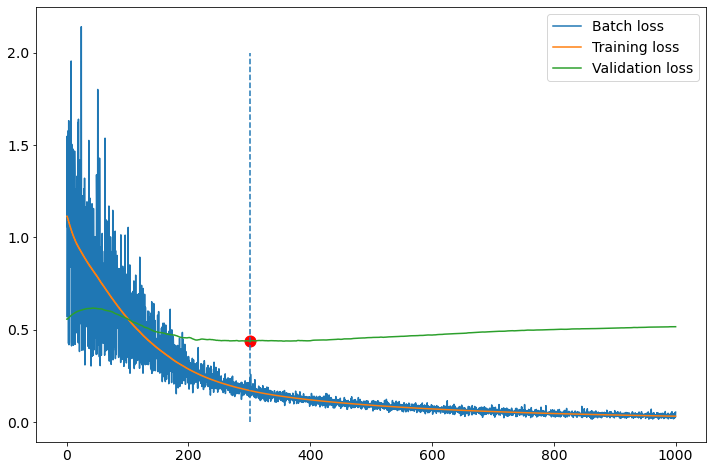

      1100       3300   0.020096   0.025895   0.523977     0.437861(300)   0.000500
      1200       3600   0.035518   0.021069   0.534537     0.437861(300)   0.000500
      1300       3900   0.018865   0.017134   0.547683     0.437861(300)   0.000500
      1400       4200   0.023624   0.014031   0.559298     0.437861(300)   0.000500
      1500       4500   0.007132   0.011413   0.569989     0.437861(300)   0.000500
      1600       4800   0.006261   0.009110   0.575061     0.437861(300)   0.000500
      1700       5100   0.003492   0.007110   0.581829     0.437861(300)   0.000500
      1800       5400   0.010676   0.005380   0.588703     0.437861(300)   0.000500
      1900       5700   0.005575   0.004046   0.593089     0.437861(300)   0.000500
      2000       6000   0.001404   0.003087   0.597140     0.437861(300)   0.000500


<Figure size 432x288 with 0 Axes>

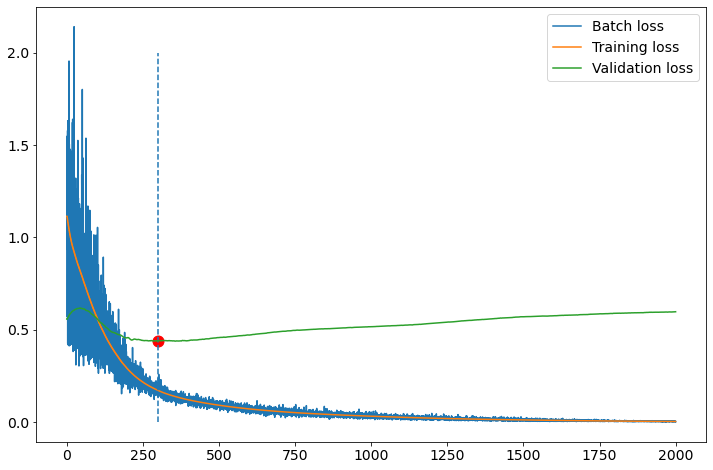

      2100       6300   0.000730   0.002430   0.598727     0.437861(300)   0.000500
      2200       6600   0.002891   0.002011   0.598264     0.437861(300)   0.000500
      2300       6900   0.002585   0.001758   0.597411     0.437861(300)   0.000500
      2400       7200   0.001246   0.001592   0.597004     0.437861(300)   0.000500
      2500       7500   0.002442   0.001482   0.597816     0.437861(300)   0.000500
      2600       7800   0.000478   0.001394   0.600887     0.437861(300)   0.000500
      2700       8100   0.001958   0.001311   0.606644     0.437861(300)   0.000500
      2800       8400   0.000534   0.001207   0.615110     0.437861(300)   0.000500
      2900       8700   0.001599   0.001059   0.628534     0.437861(300)   0.000500
      3000       9000   0.001109   0.000850   0.644428     0.437861(300)   0.000500


<Figure size 432x288 with 0 Axes>

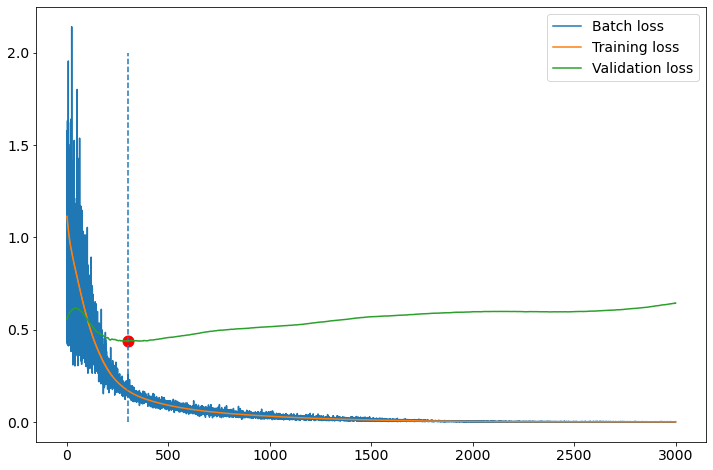

Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 14 15 16]
  Test:  index=[12 13 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.454065   0.948421   1.227599     1.222868(0)   0.000500
       100        300   0.851984   0.486422   1.023716     1.023716(99)   0.000500
       200        600   0.203149   0.232319   0.838621     0.838621(199)   0.000500
       300        900   0.146416   0.150580   0.850078     0.831365(213)   0.000500
       400       1200   0.117146   0.109342   0.883256     0.831365(213)   0.000500
       500       1500   0.085302   0.084457   0.896689     0.831365(213)   0.000500
       600       1800   0.058231   0.067855   0.901030     0.831365(213)   0.000500
       700       2100   0.046716   0.055402   0.887855     0.831365(213)   0.000500
       800       2400   0.036906   0.045235   0.867809     0.831365(213)   0.000500
       900       2700   0.048349   0.036375   0.845872     0.831365(2

<Figure size 432x288 with 0 Axes>

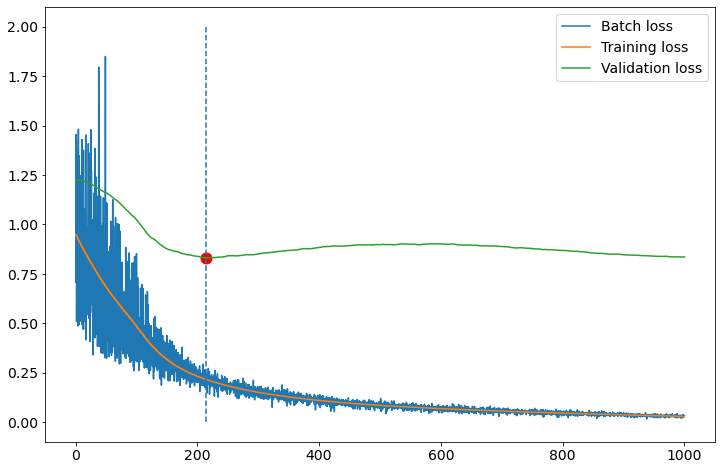

      1100       3300   0.024537   0.021683   0.827890     0.827581(1085)   0.000500
      1200       3600   0.014959   0.016041   0.832290     0.827581(1085)   0.000500
      1300       3900   0.011020   0.011624   0.840749     0.827581(1085)   0.000500
      1400       4200   0.007103   0.008227   0.849413     0.827581(1085)   0.000500
      1500       4500   0.006523   0.005414   0.855840     0.827581(1085)   0.000500
      1600       4800   0.003003   0.003339   0.859172     0.827581(1085)   0.000500
      1700       5100   0.001983   0.001936   0.864042     0.827581(1085)   0.000500
      1800       5400   0.001053   0.001047   0.869577     0.827581(1085)   0.000500
      1900       5700   0.000259   0.000552   0.875806     0.827581(1085)   0.000500
      2000       6000   0.000482   0.000301   0.881070     0.827581(1085)   0.000500


<Figure size 432x288 with 0 Axes>

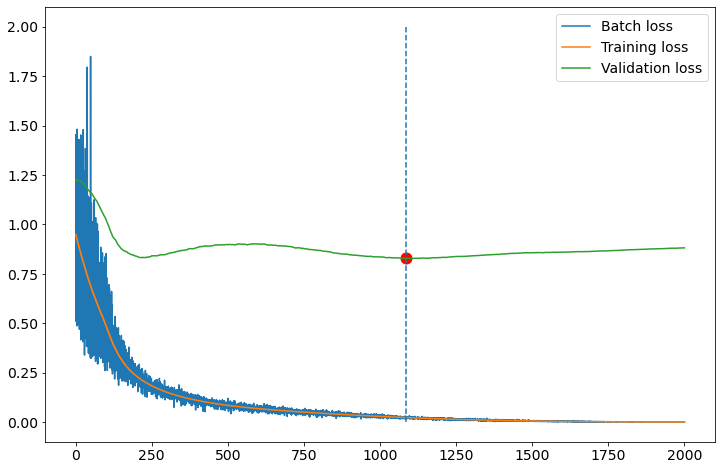

      2100       6300   0.000123   0.000175   0.884644     0.827581(1085)   0.000500
      2200       6600   0.000230   0.000108   0.887500     0.827581(1085)   0.000500
      2300       6900   0.000055   0.000067   0.888926     0.827581(1085)   0.000500
      2400       7200   0.000010   0.000042   0.889959     0.827581(1085)   0.000500
      2500       7500   0.000005   0.000024   0.890940     0.827581(1085)   0.000500
      2600       7800   0.000001   0.000013   0.890949     0.827581(1085)   0.000500
      2700       8100   0.000008   0.000006   0.891306     0.827581(1085)   0.000500
      2800       8400   0.000003   0.000003   0.891361     0.827581(1085)   0.000500
      2900       8700   0.000001   0.000001   0.891491     0.827581(1085)   0.000500
      3000       9000   0.000001   0.000000   0.891914     0.827581(1085)   0.000500


<Figure size 432x288 with 0 Axes>

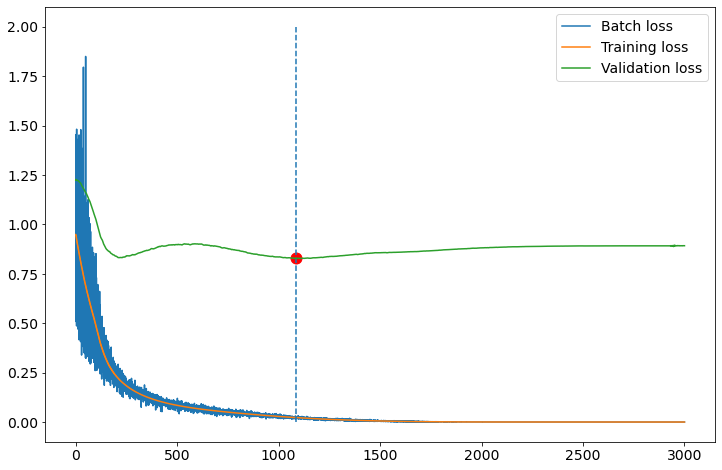

444
Fold 0:
  Train: index=[ 2  3  4  6  7  8  9 11 12 13 14 15 16 17]
  Test:  index=[ 0  1  5 10]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.490303   1.049193   0.773678     0.773678(0)   0.000500
       100        300   0.304686   0.543265   0.512250     0.512250(99)   0.000500
       200        600   0.201948   0.268741   0.484057     0.475574(165)   0.000500
       300        900   0.105722   0.177626   0.505138     0.475574(165)   0.000500
       400       1200   0.094997   0.127958   0.513295     0.475574(165)   0.000500
       500       1500   0.133225   0.098301   0.529556     0.475574(165)   0.000500
       600       1800   0.110049   0.079957   0.540173     0.475574(165)   0.000500
       700       2100   0.073915   0.067584   0.540030     0.475574(165)   0.000500
       800       2400   0.027275   0.058497   0.524278     0.475574(165)   0.000500
       900       2700   0.036104   0.050798   0.507408     0.4755

<Figure size 432x288 with 0 Axes>

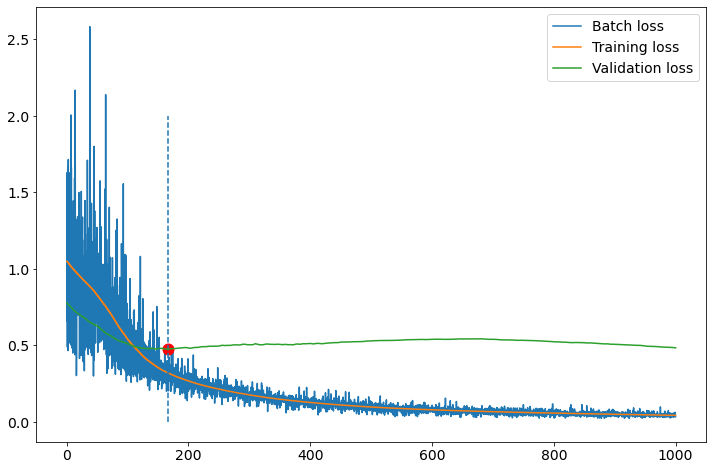

      1100       3300   0.044350   0.037114   0.467318     0.467318(1099)   0.000500
      1200       3600   0.038185   0.030965   0.452181     0.452181(1199)   0.000500
      1300       3900   0.016312   0.025245   0.446177     0.446177(1299)   0.000500
      1400       4200   0.013665   0.019922   0.442361     0.442121(1393)   0.000500
      1500       4500   0.012324   0.015202   0.441979     0.441899(1497)   0.000500
      1600       4800   0.014284   0.011331   0.444295     0.440174(1525)   0.000500
      1700       5100   0.008958   0.008267   0.447651     0.440174(1525)   0.000500
      1800       5400   0.008823   0.005921   0.449116     0.440174(1525)   0.000500
      1900       5700   0.005969   0.004108   0.451951     0.440174(1525)   0.000500
      2000       6000   0.002633   0.002697   0.453247     0.440174(1525)   0.000500


<Figure size 432x288 with 0 Axes>

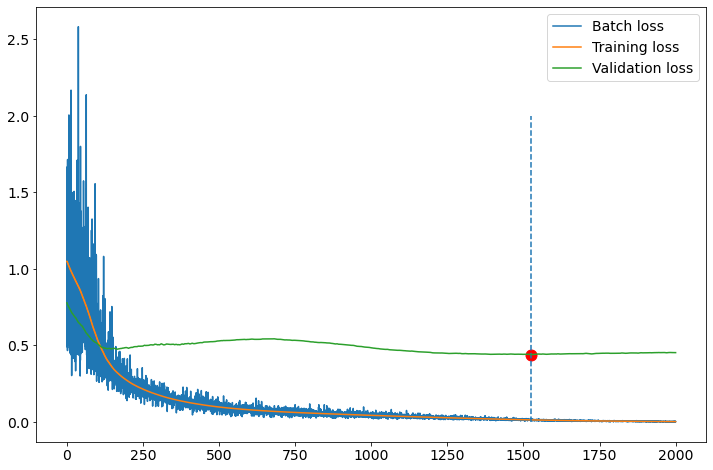

      2100       6300   0.001881   0.001633   0.455948     0.440174(1525)   0.000500
      2200       6600   0.000897   0.000885   0.456326     0.440174(1525)   0.000500
      2300       6900   0.000445   0.000429   0.458749     0.440174(1525)   0.000500
      2400       7200   0.000053   0.000184   0.461141     0.440174(1525)   0.000500
      2500       7500   0.000145   0.000067   0.463920     0.440174(1525)   0.000500
      2600       7800   0.000010   0.000021   0.465714     0.440174(1525)   0.000500
      2700       8100   0.000010   0.000006   0.466893     0.440174(1525)   0.000500
      2800       8400   0.000001   0.000001   0.467704     0.440174(1525)   0.000500
      2900       8700   0.000000   0.000000   0.467970     0.440174(1525)   0.000500
      3000       9000   0.000012   0.000018   0.466795     0.440174(1525)   0.000500


<Figure size 432x288 with 0 Axes>

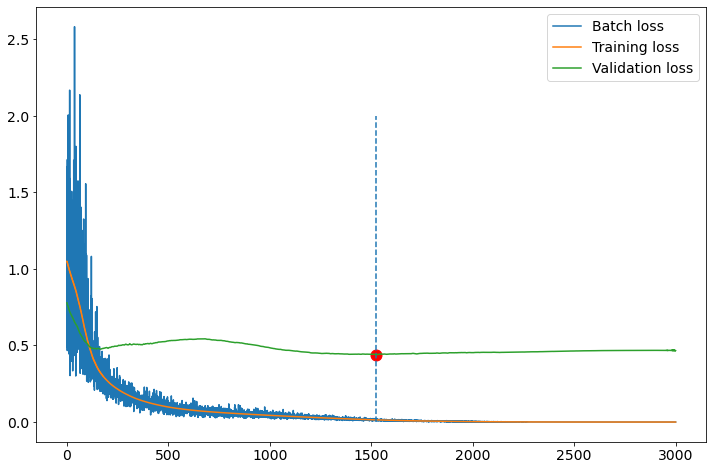

Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8 10 14 15 16 17]
  Test:  index=[ 9 11 12 13]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.372352   0.932289   1.033856     1.033856(0)   0.000500
       100        300   0.813196   0.472040   0.852681     0.852681(99)   0.000500
       200        600   0.150858   0.273701   0.832296     0.816048(163)   0.000500
       300        900   0.215254   0.191283   0.821275     0.813557(241)   0.000500
       400       1200   0.176209   0.139282   0.834787     0.813557(241)   0.000500
       500       1500   0.107624   0.103533   0.839639     0.813557(241)   0.000500
       600       1800   0.076277   0.079765   0.853965     0.813557(241)   0.000500
       700       2100   0.083487   0.064390   0.867944     0.813557(241)   0.000500
       800       2400   0.057742   0.053602   0.873716     0.813557(241)   0.000500
       900       2700   0.047155   0.045503   0.882866     0.813557(2

<Figure size 432x288 with 0 Axes>

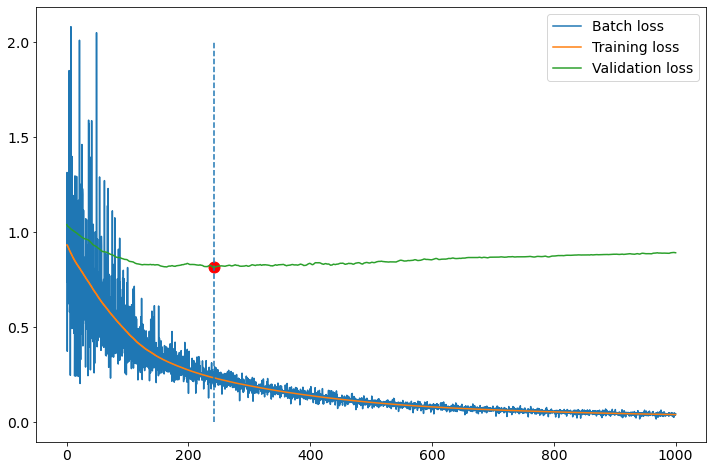

      1100       3300   0.033960   0.034088   0.899242     0.813557(241)   0.000500
      1200       3600   0.021662   0.029628   0.917184     0.813557(241)   0.000500
      1300       3900   0.027432   0.025811   0.932706     0.813557(241)   0.000500
      1400       4200   0.020980   0.022384   0.952968     0.813557(241)   0.000500
      1500       4500   0.016936   0.019216   0.973655     0.813557(241)   0.000500
      1600       4800   0.008155   0.016206   1.000462     0.813557(241)   0.000500
      1700       5100   0.010898   0.013377   1.038770     0.813557(241)   0.000500
      1800       5400   0.009084   0.010686   1.067830     0.813557(241)   0.000500
      1900       5700   0.009444   0.008257   1.101259     0.813557(241)   0.000500
      2000       6000   0.005811   0.006218   1.134274     0.813557(241)   0.000500


<Figure size 432x288 with 0 Axes>

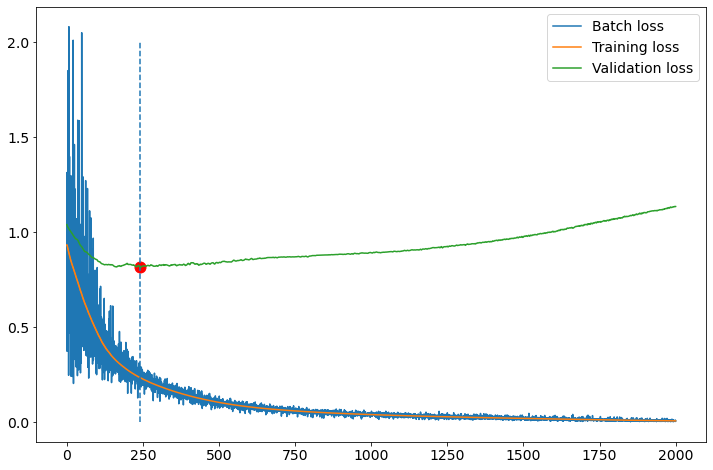

      2100       6300   0.001922   0.004527   1.164608     0.813557(241)   0.000500
      2200       6600   0.001781   0.003163   1.180343     0.813557(241)   0.000500
      2300       6900   0.001149   0.002054   1.188702     0.813557(241)   0.000500
      2400       7200   0.001566   0.001253   1.196464     0.813557(241)   0.000500
      2500       7500   0.000439   0.000721   1.200728     0.813557(241)   0.000500
      2600       7800   0.000410   0.000374   1.204755     0.813557(241)   0.000500
      2700       8100   0.000273   0.000185   1.204852     0.813557(241)   0.000500
      2800       8400   0.000185   0.000082   1.205607     0.813557(241)   0.000500
      2900       8700   0.000111   0.000034   1.204660     0.813557(241)   0.000500
      3000       9000   0.000007   0.000011   1.205051     0.813557(241)   0.000500


<Figure size 432x288 with 0 Axes>

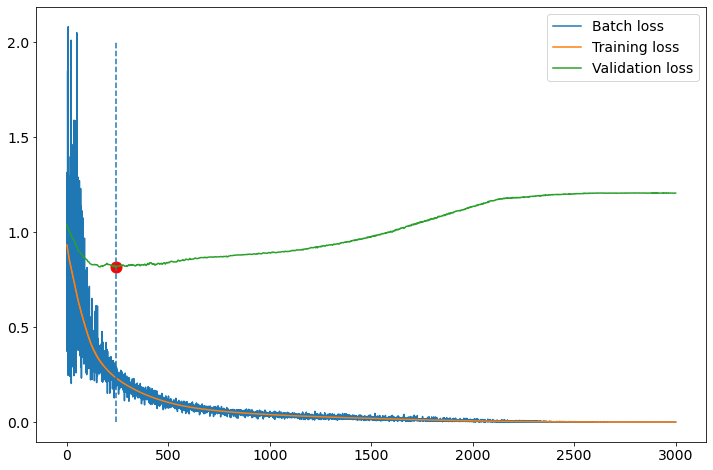

Fold 2:
  Train: index=[ 0  1  3  4  5  7  8  9 10 11 12 13 16 17]
  Test:  index=[ 2  6 14 15]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.213355   1.031929   0.755635     0.755625(0)   0.000500
       100        300   0.971705   0.542119   0.527298     0.527298(99)   0.000500
       200        600   0.447671   0.318638   0.471837     0.463584(181)   0.000500
       300        900   0.200402   0.216107   0.505742     0.463584(181)   0.000500
       400       1200   0.254725   0.162423   0.560411     0.463584(181)   0.000500
       500       1500   0.092060   0.131547   0.598828     0.463584(181)   0.000500
       600       1800   0.065392   0.108795   0.626846     0.463584(181)   0.000500
       700       2100   0.043170   0.090079   0.653649     0.463584(181)   0.000500
       800       2400   0.080410   0.073715   0.685460     0.463584(181)   0.000500
       900       2700   0.075085   0.059901   0.711077     0.463584(1

<Figure size 432x288 with 0 Axes>

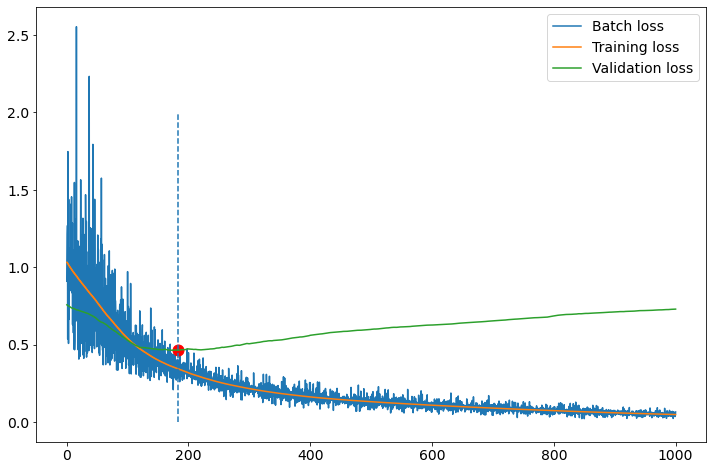

      1100       3300   0.068060   0.038974   0.737720     0.463584(181)   0.000500
      1200       3600   0.013848   0.031079   0.753855     0.463584(181)   0.000500
      1300       3900   0.042618   0.024067   0.757827     0.463584(181)   0.000500
      1400       4200   0.005735   0.017759   0.764101     0.463584(181)   0.000500
      1500       4500   0.005818   0.013090   0.772313     0.463584(181)   0.000500
      1600       4800   0.008141   0.009593   0.781144     0.463584(181)   0.000500
      1700       5100   0.007559   0.007039   0.791800     0.463584(181)   0.000500
      1800       5400   0.006172   0.005166   0.797545     0.463584(181)   0.000500
      1900       5700   0.000832   0.003770   0.800758     0.463584(181)   0.000500
      2000       6000   0.007030   0.002767   0.802171     0.463584(181)   0.000500


<Figure size 432x288 with 0 Axes>

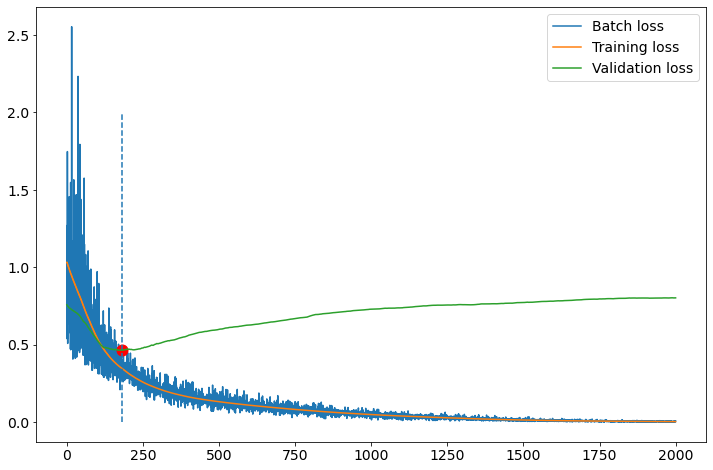

      2100       6300   0.002469   0.001990   0.803452     0.463584(181)   0.000500
      2200       6600   0.002795   0.001393   0.797681     0.463584(181)   0.000500
      2300       6900   0.000738   0.000912   0.795800     0.463584(181)   0.000500
      2400       7200   0.000638   0.000552   0.792136     0.463584(181)   0.000500
      2500       7500   0.000022   0.000301   0.787670     0.463584(181)   0.000500
      2600       7800   0.000227   0.000149   0.784030     0.463584(181)   0.000500
      2700       8100   0.000093   0.000069   0.781816     0.463584(181)   0.000500
      2800       8400   0.000074   0.000029   0.779906     0.463584(181)   0.000500
      2900       8700   0.000043   0.000011   0.779332     0.463584(181)   0.000500
      3000       9000   0.000005   0.000006   0.778699     0.463584(181)   0.000500


<Figure size 432x288 with 0 Axes>

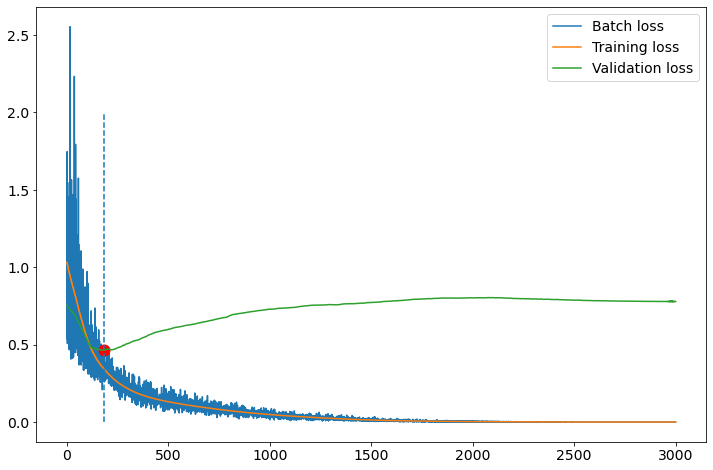

Fold 3:
  Train: index=[ 0  1  2  3  5  6  7  9 10 11 12 13 14 15 16]
  Test:  index=[ 4  8 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.728597   0.893842   1.210323     1.210323(0)   0.000500
       100        300   0.347988   0.409191   1.010638     1.010638(99)   0.000500
       200        600   0.172273   0.219350   0.922785     0.922785(199)   0.000500
       300        900   0.218873   0.152625   0.885667     0.885667(299)   0.000500
       400       1200   0.147392   0.121031   0.869762     0.868537(394)   0.000500
       500       1500   0.085940   0.100992   0.852956     0.852268(496)   0.000500
       600       1800   0.088055   0.085727   0.846649     0.845088(582)   0.000500
       700       2100   0.069133   0.072539   0.869389     0.845088(582)   0.000500
       800       2400   0.041693   0.060544   0.888196     0.845088(582)   0.000500
       900       2700   0.035635   0.049677   0.907354     0.845088(5

<Figure size 432x288 with 0 Axes>

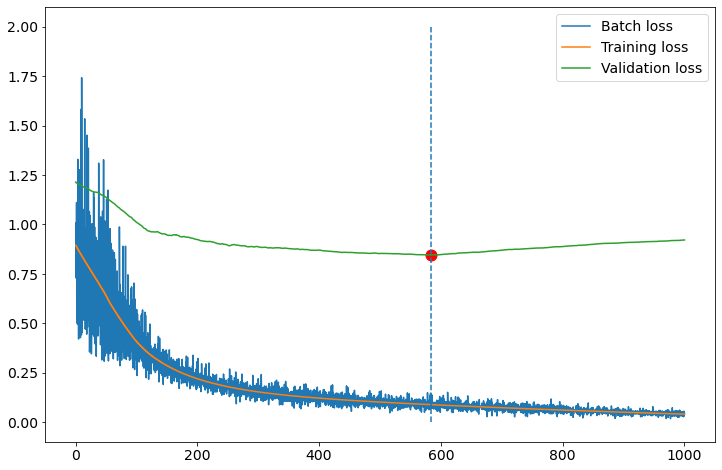

      1100       3300   0.046864   0.032085   0.934632     0.845088(582)   0.000500
      1200       3600   0.016816   0.025387   0.945402     0.845088(582)   0.000500
      1300       3900   0.024272   0.019902   0.949841     0.845088(582)   0.000500
      1400       4200   0.013911   0.015077   0.954350     0.845088(582)   0.000500
      1500       4500   0.016631   0.010849   0.955930     0.845088(582)   0.000500
      1600       4800   0.008398   0.007214   0.955304     0.845088(582)   0.000500
      1700       5100   0.003501   0.004314   0.956175     0.845088(582)   0.000500
      1800       5400   0.003138   0.002323   0.956860     0.845088(582)   0.000500
      1900       5700   0.000992   0.001114   0.956874     0.845088(582)   0.000500
      2000       6000   0.000585   0.000476   0.955667     0.845088(582)   0.000500


<Figure size 432x288 with 0 Axes>

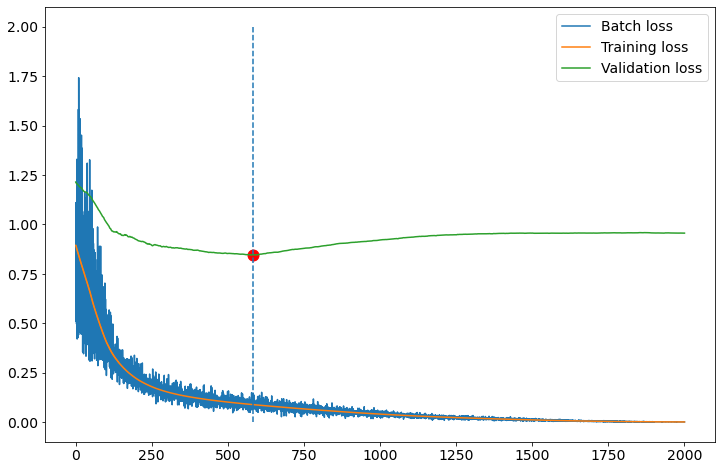

      2100       6300   0.000245   0.000184   0.956288     0.845088(582)   0.000500
      2200       6600   0.000080   0.000064   0.956912     0.845088(582)   0.000500
      2300       6900   0.000018   0.000020   0.957034     0.845088(582)   0.000500
      2400       7200   0.000004   0.000005   0.957271     0.845088(582)   0.000500
      2500       7500   0.000001   0.000001   0.957504     0.845088(582)   0.000500
      2600       7800   0.000001   0.000000   0.957602     0.845088(582)   0.000500
      2700       8100   0.000000   0.000000   0.957632     0.845088(582)   0.000500
      2800       8400   0.000000   0.000000   0.957655     0.845088(582)   0.000500
      2900       8700   0.000001   0.000000   0.958409     0.845088(582)   0.000500
      3000       9000   0.000000   0.000000   0.958485     0.845088(582)   0.000500


<Figure size 432x288 with 0 Axes>

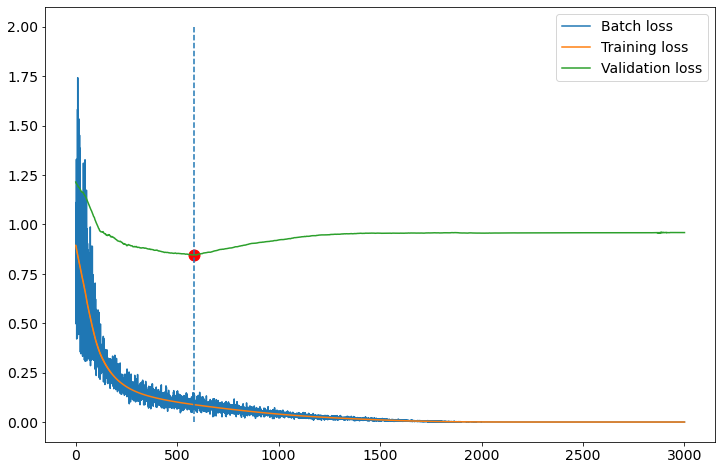

Fold 4:
  Train: index=[ 0  1  2  4  5  6  8  9 10 11 12 13 14 15 17]
  Test:  index=[ 3  7 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.603555   0.880628   1.379740     1.379580(0)   0.000500
       100        300   0.358097   0.442555   1.053474     1.053474(99)   0.000500
       200        600   0.246748   0.217815   0.885278     0.879960(177)   0.000500
       300        900   0.179933   0.155147   0.929933     0.879960(177)   0.000500
       400       1200   0.120774   0.119839   0.976391     0.879960(177)   0.000500
       500       1500   0.080428   0.095808   1.003919     0.879960(177)   0.000500
       600       1800   0.074120   0.077769   1.017162     0.879960(177)   0.000500
       700       2100   0.066564   0.063295   1.031677     0.879960(177)   0.000500
       800       2400   0.059834   0.051616   1.045561     0.879960(177)   0.000500
       900       2700   0.053197   0.042464   1.057961     0.879960(1

<Figure size 432x288 with 0 Axes>

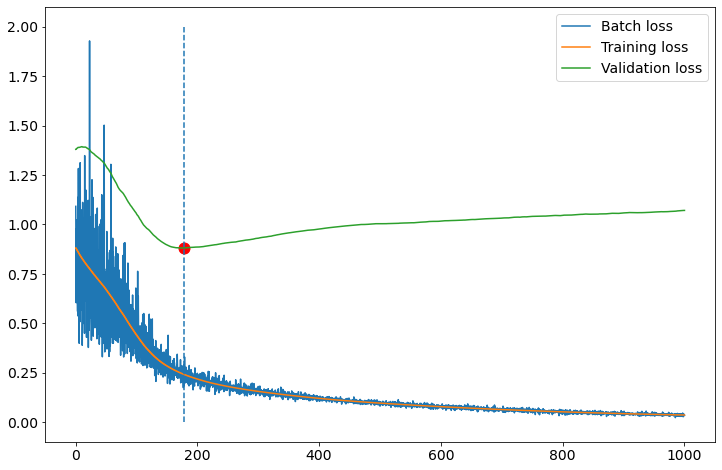

      1100       3300   0.029778   0.030150   1.085171     0.879960(177)   0.000500
      1200       3600   0.027686   0.025812   1.095783     0.879960(177)   0.000500
      1300       3900   0.023676   0.022224   1.103881     0.879960(177)   0.000500
      1400       4200   0.020951   0.019174   1.105272     0.879960(177)   0.000500
      1500       4500   0.016573   0.016456   1.103096     0.879960(177)   0.000500
      1600       4800   0.015274   0.013902   1.098125     0.879960(177)   0.000500
      1700       5100   0.014297   0.011491   1.094429     0.879960(177)   0.000500
      1800       5400   0.012406   0.009330   1.089317     0.879960(177)   0.000500
      1900       5700   0.008612   0.007468   1.088534     0.879960(177)   0.000500
      2000       6000   0.007448   0.005880   1.092011     0.879960(177)   0.000500


<Figure size 432x288 with 0 Axes>

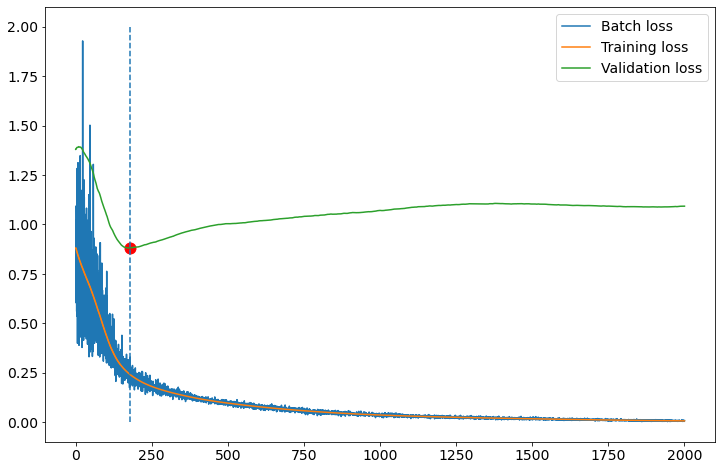

      2100       6300   0.004376   0.004572   1.104408     0.879960(177)   0.000500
      2200       6600   0.002874   0.003465   1.126537     0.879960(177)   0.000500
      2300       6900   0.003262   0.002425   1.166174     0.879960(177)   0.000500
      2400       7200   0.001449   0.001594   1.201245     0.879960(177)   0.000500
      2500       7500   0.002037   0.000968   1.215466     0.879960(177)   0.000500
      2600       7800   0.000355   0.000531   1.224772     0.879960(177)   0.000500
      2700       8100   0.000085   0.000264   1.227713     0.879960(177)   0.000500
      2800       8400   0.000117   0.000120   1.228193     0.879960(177)   0.000500
      2900       8700   0.000029   0.000051   1.227481     0.879960(177)   0.000500
      3000       9000   0.000019   0.000020   1.225488     0.879960(177)   0.000500


<Figure size 432x288 with 0 Axes>

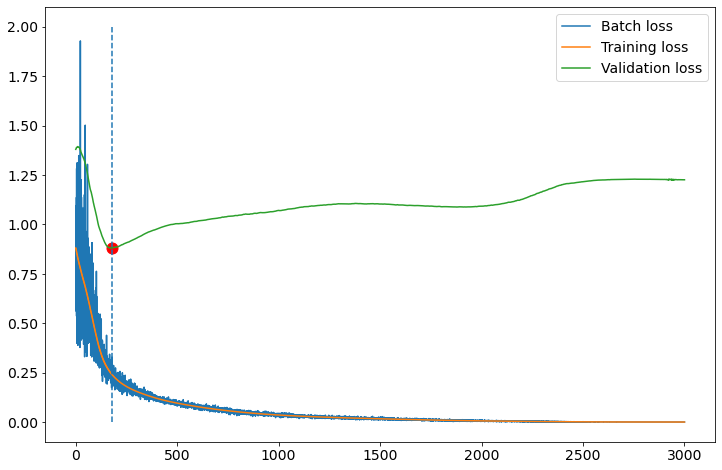

555
Fold 0:
  Train: index=[ 0  1  2  4  5  6  8  9 10 12 13 14 16 17]
  Test:  index=[ 3  7 11 15]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.496960   1.084142   0.420441     0.420441(0)   0.000500
       100        300   0.331091   0.472062   0.550948     0.418880(15)   0.000500
       200        600   0.260727   0.257625   0.884793     0.418880(15)   0.000500
       300        900   0.123701   0.170709   1.028482     0.418880(15)   0.000500
       400       1200   0.105265   0.124008   1.133753     0.418880(15)   0.000500
       500       1500   0.100398   0.095246   1.195754     0.418880(15)   0.000500
       600       1800   0.075076   0.075908   1.203432     0.418880(15)   0.000500
       700       2100   0.069820   0.061985   1.201135     0.418880(15)   0.000500
       800       2400   0.047891   0.051026   1.189110     0.418880(15)   0.000500
       900       2700   0.027956   0.041946   1.171914     0.418880(15) 

<Figure size 432x288 with 0 Axes>

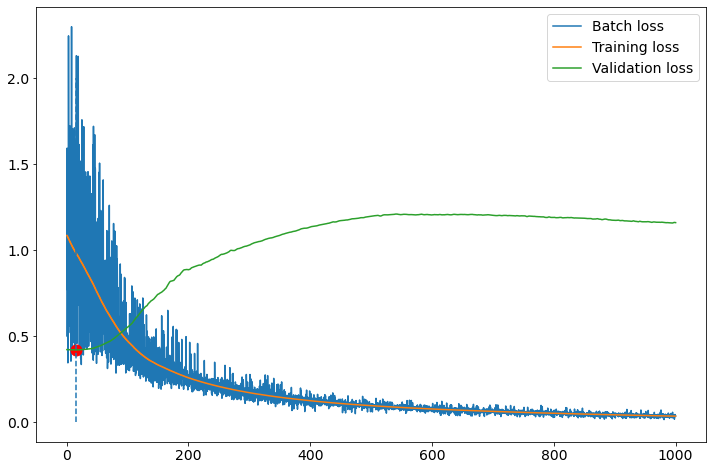

      1100       3300   0.029386   0.027765   1.157029     0.418880(15)   0.000500
      1200       3600   0.023243   0.022267   1.153879     0.418880(15)   0.000500
      1300       3900   0.007365   0.017432   1.156838     0.418880(15)   0.000500
      1400       4200   0.014943   0.013434   1.164810     0.418880(15)   0.000500
      1500       4500   0.002357   0.010160   1.177242     0.418880(15)   0.000500
      1600       4800   0.003456   0.007342   1.193378     0.418880(15)   0.000500
      1700       5100   0.003896   0.005046   1.214154     0.418880(15)   0.000500
      1800       5400   0.002387   0.003217   1.232428     0.418880(15)   0.000500
      1900       5700   0.003382   0.001899   1.251895     0.418880(15)   0.000500
      2000       6000   0.000461   0.000968   1.270058     0.418880(15)   0.000500


<Figure size 432x288 with 0 Axes>

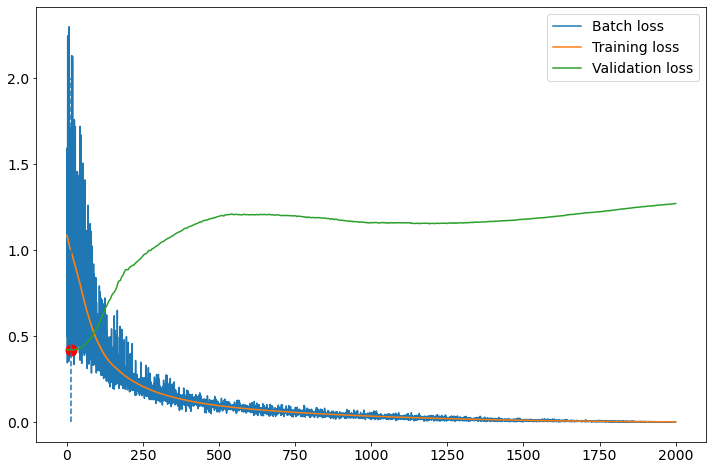

      2100       6300   0.000339   0.000416   1.282184     0.418880(15)   0.000500
      2200       6600   0.000178   0.000153   1.289525     0.418880(15)   0.000500
      2300       6900   0.000073   0.000049   1.292850     0.418880(15)   0.000500
      2400       7200   0.000006   0.000013   1.293105     0.418880(15)   0.000500
      2500       7500   0.000004   0.000003   1.293247     0.418880(15)   0.000500
      2600       7800   0.000005   0.000004   1.294539     0.418880(15)   0.000500
      2700       8100   0.000001   0.000000   1.294414     0.418880(15)   0.000500
      2800       8400   0.000001   0.000000   1.294164     0.418880(15)   0.000500
      2900       8700   0.000040   0.000048   1.295556     0.418880(15)   0.000500
      3000       9000   0.000000   0.000000   1.296120     0.418880(15)   0.000500


<Figure size 432x288 with 0 Axes>

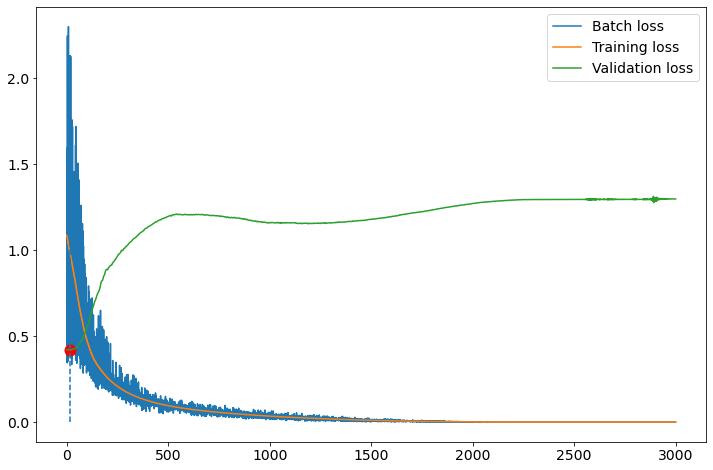

Fold 1:
  Train: index=[ 0  1  3  4  5  6  7  9 11 12 13 14 15 16]
  Test:  index=[ 2  8 10 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.772962   1.021768   1.113024     1.113024(0)   0.000500
       100        300   0.357490   0.516576   1.181175     1.112283(3)   0.000500
       200        600   0.266271   0.269505   1.181896     1.112283(3)   0.000500
       300        900   0.250848   0.201508   1.187171     1.112283(3)   0.000500
       400       1200   0.129358   0.161585   1.174196     1.112283(3)   0.000500
       500       1500   0.092066   0.131135   1.164490     1.112283(3)   0.000500
       600       1800   0.070685   0.107781   1.160362     1.112283(3)   0.000500
       700       2100   0.088334   0.088775   1.161816     1.112283(3)   0.000500
       800       2400   0.094199   0.073342   1.170380     1.112283(3)   0.000500
       900       2700   0.064718   0.059540   1.190947     1.112283(3)   0.000500
  

<Figure size 432x288 with 0 Axes>

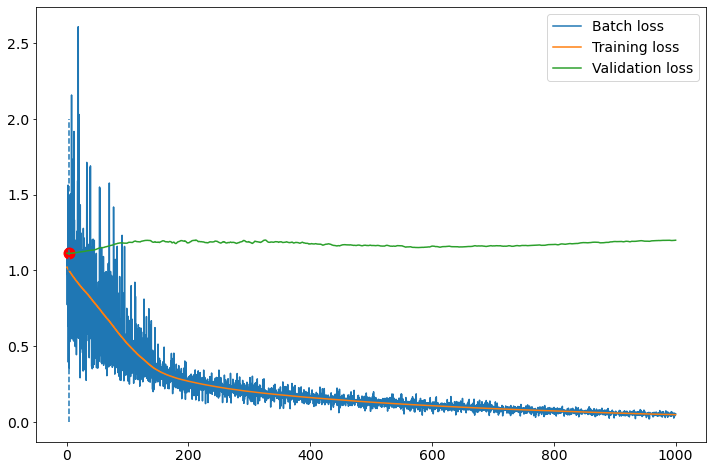

      1100       3300   0.036062   0.040708   1.205119     1.112283(3)   0.000500
      1200       3600   0.038374   0.034936   1.218149     1.112283(3)   0.000500
      1300       3900   0.044494   0.030538   1.224534     1.112283(3)   0.000500
      1400       4200   0.014437   0.026879   1.224866     1.112283(3)   0.000500
      1500       4500   0.032669   0.023401   1.212957     1.112283(3)   0.000500
      1600       4800   0.015644   0.019835   1.179570     1.112283(3)   0.000500
      1700       5100   0.014656   0.016387   1.147266     1.112283(3)   0.000500
      1800       5400   0.014407   0.012891   1.120246     1.112283(3)   0.000500
      1900       5700   0.019291   0.009641   1.101832     1.100966(1896)   0.000500
      2000       6000   0.008406   0.006837   1.097567     1.095225(1952)   0.000500


<Figure size 432x288 with 0 Axes>

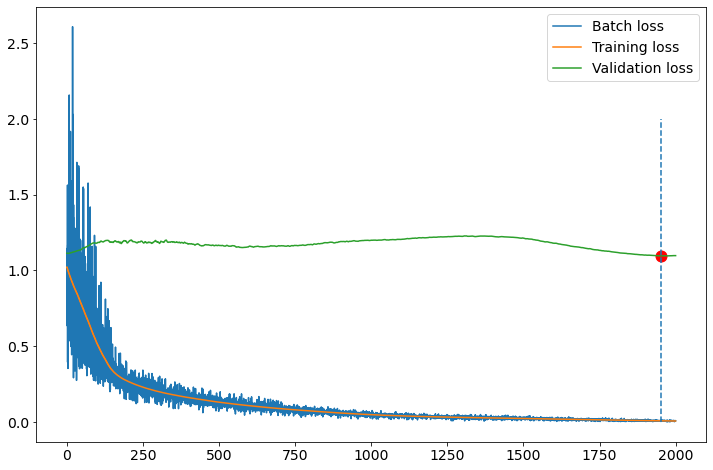

      2100       6300   0.004911   0.004681   1.103089     1.095225(1952)   0.000500
      2200       6600   0.004501   0.003184   1.104617     1.095225(1952)   0.000500
      2300       6900   0.001739   0.002189   1.112626     1.095225(1952)   0.000500
      2400       7200   0.003344   0.001530   1.121695     1.095225(1952)   0.000500
      2500       7500   0.000692   0.001101   1.134212     1.095225(1952)   0.000500
      2600       7800   0.000800   0.000807   1.148111     1.095225(1952)   0.000500
      2700       8100   0.000063   0.000566   1.161216     1.095225(1952)   0.000500
      2800       8400   0.000394   0.000386   1.173932     1.095225(1952)   0.000500
      2900       8700   0.000327   0.000239   1.187960     1.095225(1952)   0.000500
      3000       9000   0.000214   0.000136   1.200979     1.095225(1952)   0.000500


<Figure size 432x288 with 0 Axes>

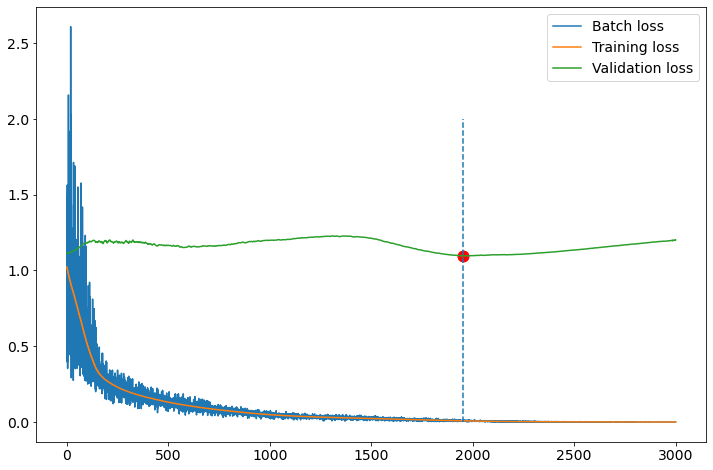

Fold 2:
  Train: index=[ 1  2  3  4  6  7  8  9 10 11 13 14 15 17]
  Test:  index=[ 0  5 12 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.590731   0.730242   1.823712     1.820816(0)   0.000500
       100        300   0.779197   0.403436   1.760782     1.760782(99)   0.000500
       200        600   0.242672   0.222958   1.703996     1.667159(166)   0.000500
       300        900   0.152159   0.138986   1.808373     1.667159(166)   0.000500
       400       1200   0.089971   0.101093   1.864339     1.667159(166)   0.000500
       500       1500   0.068993   0.078112   1.878739     1.667159(166)   0.000500
       600       1800   0.058656   0.061017   1.863928     1.667159(166)   0.000500
       700       2100   0.032439   0.048348   1.865994     1.667159(166)   0.000500
       800       2400   0.042339   0.038380   1.867962     1.667159(166)   0.000500
       900       2700   0.027178   0.030745   1.860590     1.667159(1

<Figure size 432x288 with 0 Axes>

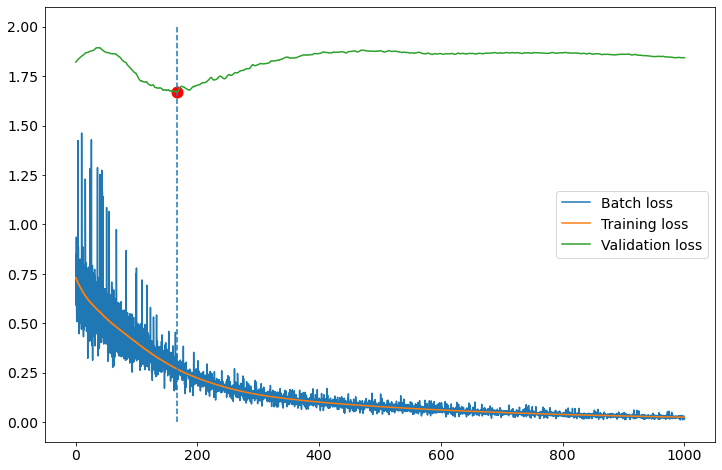

      1100       3300   0.031762   0.019198   1.813867     1.667159(166)   0.000500
      1200       3600   0.006430   0.014898   1.785337     1.667159(166)   0.000500
      1300       3900   0.009210   0.011461   1.755203     1.667159(166)   0.000500
      1400       4200   0.013378   0.008629   1.725221     1.667159(166)   0.000500
      1500       4500   0.006302   0.006440   1.704691     1.667159(166)   0.000500
      1600       4800   0.002725   0.004834   1.694703     1.667159(166)   0.000500
      1700       5100   0.002644   0.003594   1.687839     1.667159(166)   0.000500
      1800       5400   0.002595   0.002627   1.694250     1.667159(166)   0.000500
      1900       5700   0.001990   0.001783   1.700966     1.667159(166)   0.000500
      2000       6000   0.001536   0.001082   1.710561     1.667159(166)   0.000500


<Figure size 432x288 with 0 Axes>

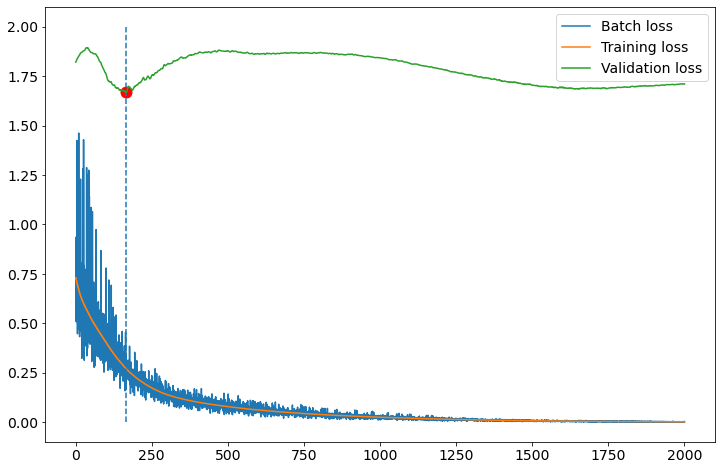

      2100       6300   0.000304   0.000561   1.717797     1.667159(166)   0.000500
      2200       6600   0.000309   0.000254   1.727459     1.667159(166)   0.000500
      2300       6900   0.000046   0.000103   1.734593     1.667159(166)   0.000500
      2400       7200   0.000002   0.000037   1.739651     1.667159(166)   0.000500
      2500       7500   0.000000   0.000011   1.742490     1.667159(166)   0.000500
      2600       7800   0.000004   0.000003   1.743829     1.667159(166)   0.000500
      2700       8100   0.000001   0.000000   1.744495     1.667159(166)   0.000500
      2800       8400   0.000000   0.000000   1.744863     1.667159(166)   0.000500
      2900       8700   0.000000   0.000000   1.744161     1.667159(166)   0.000500
      3000       9000   0.000000   0.000000   1.744793     1.667159(166)   0.000500


<Figure size 432x288 with 0 Axes>

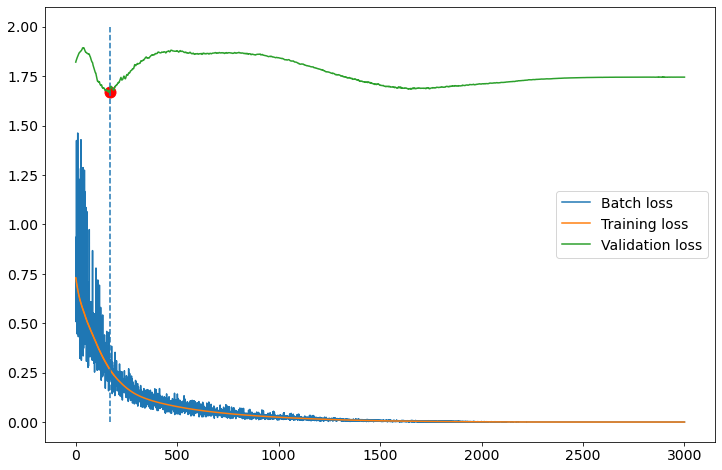

Fold 3:
  Train: index=[ 0  1  2  3  5  7  8  9 10 11 12 14 15 16 17]
  Test:  index=[ 4  6 13]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.785543   1.093276   0.700950     0.700235(0)   0.000500
       100        300   0.557385   0.608149   0.557033     0.557033(99)   0.000500
       200        600   0.425043   0.298609   0.495343     0.494452(189)   0.000500
       300        900   0.290242   0.188956   0.485318     0.482692(279)   0.000500
       400       1200   0.098711   0.128938   0.478343     0.477225(393)   0.000500
       500       1500   0.150585   0.093202   0.460169     0.458959(494)   0.000500
       600       1800   0.062626   0.071808   0.446286     0.446224(599)   0.000500
       700       2100   0.063574   0.057682   0.437405     0.436773(680)   0.000500
       800       2400   0.041697   0.047354   0.431911     0.431517(796)   0.000500
       900       2700   0.043519   0.038857   0.431382     0.430204(8

<Figure size 432x288 with 0 Axes>

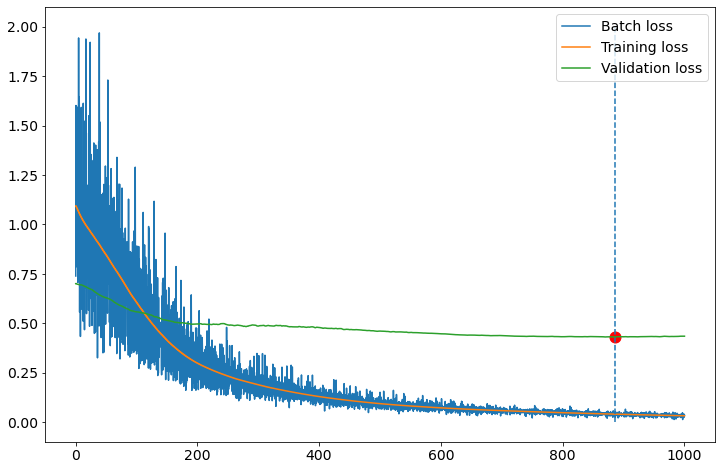

      1100       3300   0.019101   0.026058   0.440540     0.430204(885)   0.000500
      1200       3600   0.016857   0.021374   0.451940     0.430204(885)   0.000500
      1300       3900   0.022687   0.017331   0.466551     0.430204(885)   0.000500
      1400       4200   0.012622   0.013624   0.485514     0.430204(885)   0.000500
      1500       4500   0.008571   0.010217   0.498759     0.430204(885)   0.000500
      1600       4800   0.006823   0.007168   0.512747     0.430204(885)   0.000500
      1700       5100   0.003524   0.004676   0.524100     0.430204(885)   0.000500
      1800       5400   0.003886   0.002802   0.536250     0.430204(885)   0.000500
      1900       5700   0.001036   0.001516   0.544211     0.430204(885)   0.000500
      2000       6000   0.000574   0.000742   0.550929     0.430204(885)   0.000500


<Figure size 432x288 with 0 Axes>

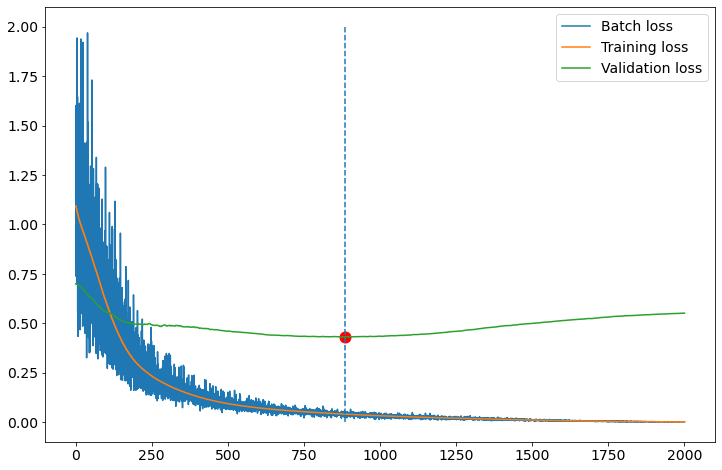

      2100       6300   0.000238   0.000322   0.555430     0.430204(885)   0.000500
      2200       6600   0.000162   0.000126   0.558863     0.430204(885)   0.000500
      2300       6900   0.000090   0.000044   0.562374     0.430204(885)   0.000500
      2400       7200   0.000011   0.000013   0.564929     0.430204(885)   0.000500
      2500       7500   0.000005   0.000004   0.566596     0.430204(885)   0.000500
      2600       7800   0.000000   0.000001   0.567487     0.430204(885)   0.000500
      2700       8100   0.000000   0.000000   0.568121     0.430204(885)   0.000500
      2800       8400   0.000000   0.000000   0.568462     0.430204(885)   0.000500
      2900       8700   0.000000   0.000000   0.568515     0.430204(885)   0.000500
      3000       9000   0.000032   0.000016   0.564517     0.430204(885)   0.000500


<Figure size 432x288 with 0 Axes>

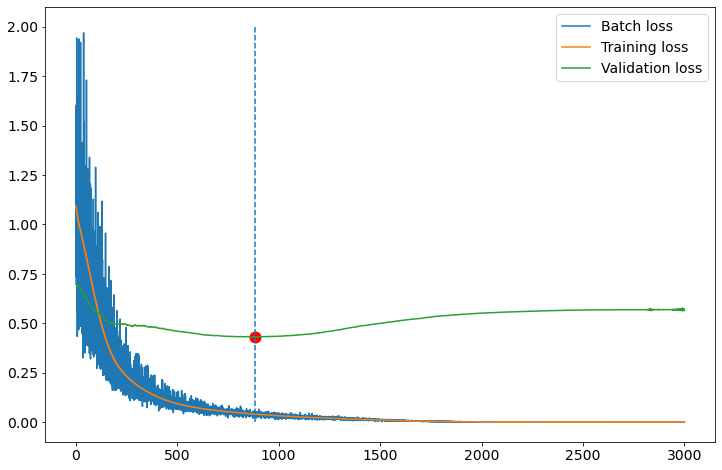

Fold 4:
  Train: index=[ 0  2  3  4  5  6  7  8 10 11 12 13 15 16 17]
  Test:  index=[ 1  9 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.095533   1.028294   0.686994     0.686951(0)   0.000500
       100        300   0.337104   0.566709   0.588700     0.588700(99)   0.000500
       200        600   0.387998   0.322837   0.659305     0.583487(118)   0.000500
       300        900   0.235809   0.230926   0.810242     0.583487(118)   0.000500
       400       1200   0.152363   0.177738   1.003492     0.583487(118)   0.000500
       500       1500   0.140949   0.143560   1.137955     0.583487(118)   0.000500
       600       1800   0.109494   0.121667   1.161281     0.583487(118)   0.000500
       700       2100   0.108195   0.105636   1.177382     0.583487(118)   0.000500
       800       2400   0.103359   0.093276   1.209408     0.583487(118)   0.000500
       900       2700   0.067069   0.082941   1.235300     0.583487(1

<Figure size 432x288 with 0 Axes>

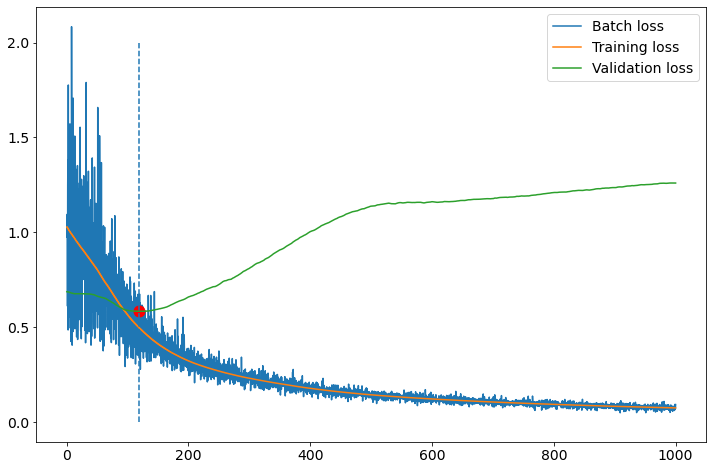

      1100       3300   0.088883   0.067326   1.264186     0.583487(118)   0.000500
      1200       3600   0.058597   0.061040   1.256632     0.583487(118)   0.000500
      1300       3900   0.048191   0.055216   1.251015     0.583487(118)   0.000500
      1400       4200   0.045037   0.049709   1.246573     0.583487(118)   0.000500
      1500       4500   0.041798   0.044612   1.235976     0.583487(118)   0.000500
      1600       4800   0.039627   0.040215   1.229319     0.583487(118)   0.000500
      1700       5100   0.034090   0.036726   1.233707     0.583487(118)   0.000500
      1800       5400   0.037113   0.034238   1.238749     0.583487(118)   0.000500
      1900       5700   0.012024   0.032588   1.238509     0.583487(118)   0.000500
      2000       6000   0.041617   0.031431   1.232900     0.583487(118)   0.000500


<Figure size 432x288 with 0 Axes>

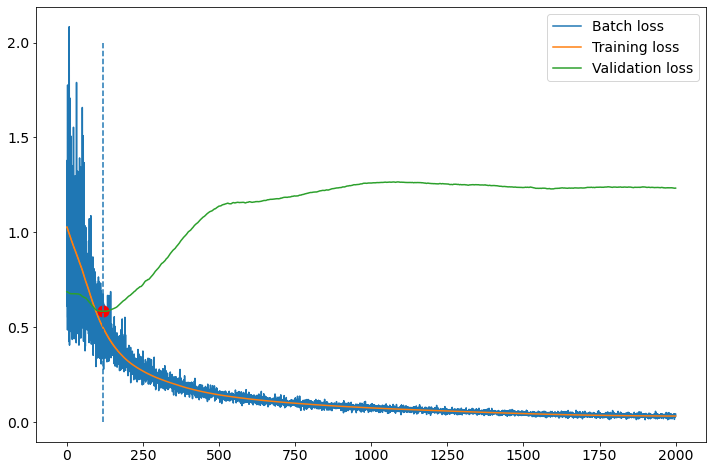

      2100       6300   0.028920   0.030543   1.232311     0.583487(118)   0.000500
      2200       6600   0.037225   0.029834   1.230649     0.583487(118)   0.000500
      2300       6900   0.024995   0.029202   1.230277     0.583487(118)   0.000500
      2400       7200   0.022548   0.028622   1.236826     0.583487(118)   0.000500
      2500       7500   0.018841   0.028050   1.237096     0.583487(118)   0.000500
      2600       7800   0.011331   0.027449   1.242128     0.583487(118)   0.000500
      2700       8100   0.035413   0.026802   1.251651     0.583487(118)   0.000500
      2800       8400   0.027534   0.026027   1.268555     0.583487(118)   0.000500
      2900       8700   0.023620   0.025137   1.278238     0.583487(118)   0.000500
      3000       9000   0.015159   0.024120   1.288837     0.583487(118)   0.000500


<Figure size 432x288 with 0 Axes>

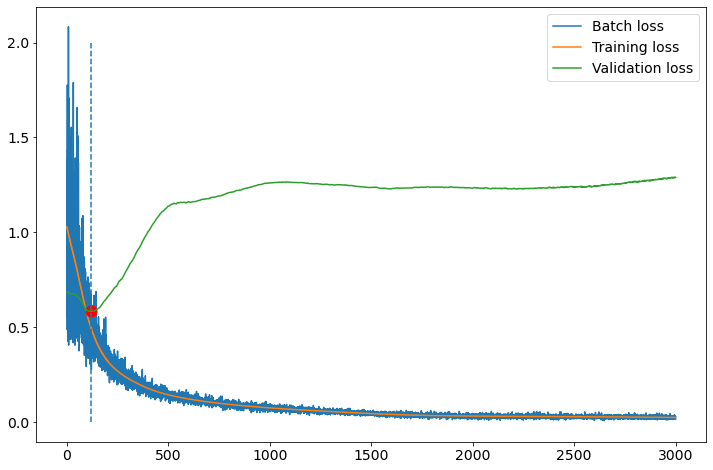

666
Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  8  9 12 13 14 15 16]
  Test:  index=[ 7 10 11 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.379317   1.074150   0.484191     0.482350(0)   0.000500
       100        300   0.271394   0.442114   0.700320     0.482350(0)   0.000500
       200        600   0.169164   0.251381   1.024886     0.482350(0)   0.000500
       300        900   0.203087   0.177961   1.143874     0.482350(0)   0.000500
       400       1200   0.132468   0.134569   1.224796     0.482350(0)   0.000500
       500       1500   0.112649   0.106504   1.289613     0.482350(0)   0.000500
       600       1800   0.083088   0.087092   1.334896     0.482350(0)   0.000500
       700       2100   0.053860   0.073974   1.375613     0.482350(0)   0.000500
       800       2400   0.052289   0.064635   1.409392     0.482350(0)   0.000500
       900       2700   0.043821   0.056920   1.421929     0.482350(0)   0.00050

<Figure size 432x288 with 0 Axes>

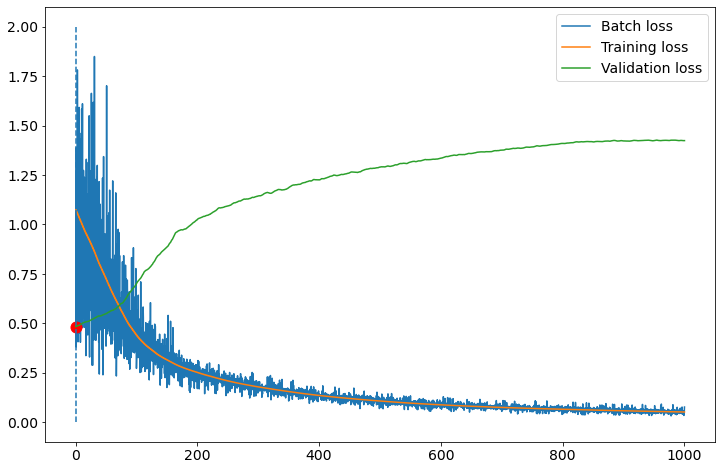

      1100       3300   0.052363   0.045306   1.423596     0.482350(0)   0.000500
      1200       3600   0.027255   0.040094   1.414946     0.482350(0)   0.000500
      1300       3900   0.032413   0.034915   1.390258     0.482350(0)   0.000500
      1400       4200   0.019200   0.029609   1.371777     0.482350(0)   0.000500
      1500       4500   0.014259   0.024302   1.344421     0.482350(0)   0.000500
      1600       4800   0.014778   0.019204   1.319827     0.482350(0)   0.000500
      1700       5100   0.014880   0.014560   1.303690     0.482350(0)   0.000500
      1800       5400   0.011460   0.010643   1.299323     0.482350(0)   0.000500
      1900       5700   0.004766   0.007526   1.309426     0.482350(0)   0.000500
      2000       6000   0.004413   0.005152   1.327676     0.482350(0)   0.000500


<Figure size 432x288 with 0 Axes>

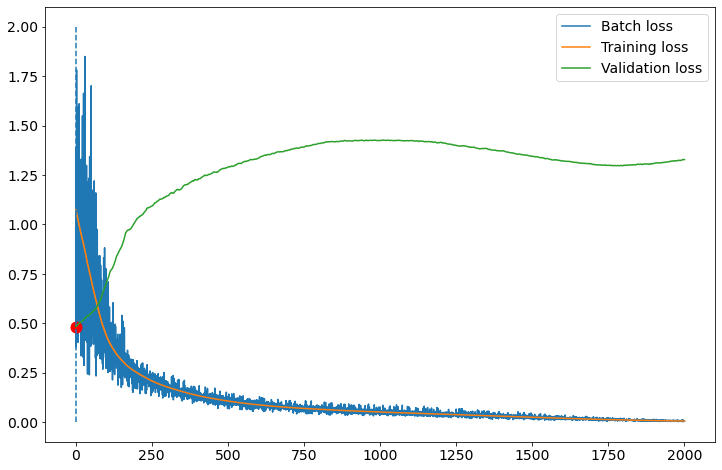

      2100       6300   0.002493   0.003338   1.349700     0.482350(0)   0.000500
      2200       6600   0.000869   0.001995   1.361723     0.482350(0)   0.000500
      2300       6900   0.000496   0.001054   1.371240     0.482350(0)   0.000500
      2400       7200   0.000190   0.000493   1.377200     0.482350(0)   0.000500
      2500       7500   0.000226   0.000202   1.380748     0.482350(0)   0.000500
      2600       7800   0.000125   0.000068   1.381879     0.482350(0)   0.000500
      2700       8100   0.000011   0.000019   1.380787     0.482350(0)   0.000500
      2800       8400   0.000012   0.000005   1.379872     0.482350(0)   0.000500
      2900       8700   0.000000   0.000001   1.378819     0.482350(0)   0.000500
      3000       9000   0.000007   0.000001   1.375093     0.482350(0)   0.000500


<Figure size 432x288 with 0 Axes>

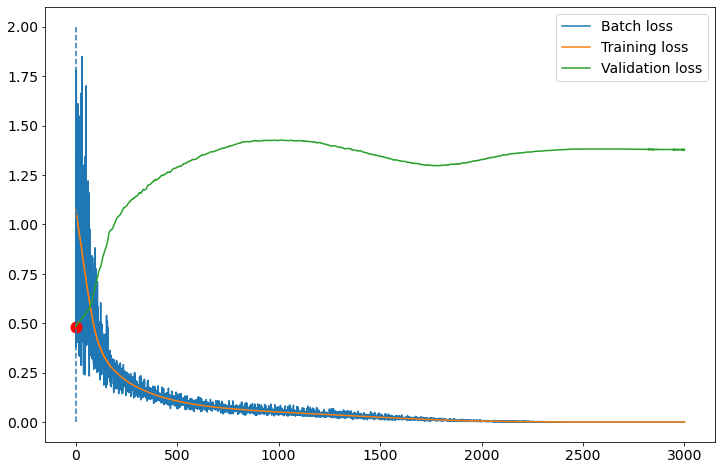

Fold 1:
  Train: index=[ 0  1  2  3  4  6  7  9 10 11 12 13 14 17]
  Test:  index=[ 5  8 15 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.196678   0.789251   1.779654     1.773791(0)   0.000500
       100        300   0.306612   0.359705   1.856810     1.773791(0)   0.000500
       200        600   0.268275   0.212642   1.571350     1.571115(199)   0.000500
       300        900   0.167322   0.144449   1.559587     1.552272(291)   0.000500
       400       1200   0.090466   0.109635   1.563734     1.548544(316)   0.000500
       500       1500   0.065891   0.087933   1.562485     1.548544(316)   0.000500
       600       1800   0.057890   0.072288   1.598545     1.548544(316)   0.000500
       700       2100   0.042441   0.059365   1.628555     1.548544(316)   0.000500
       800       2400   0.044183   0.048553   1.666254     1.548544(316)   0.000500
       900       2700   0.024403   0.039680   1.694427     1.548544(31

<Figure size 432x288 with 0 Axes>

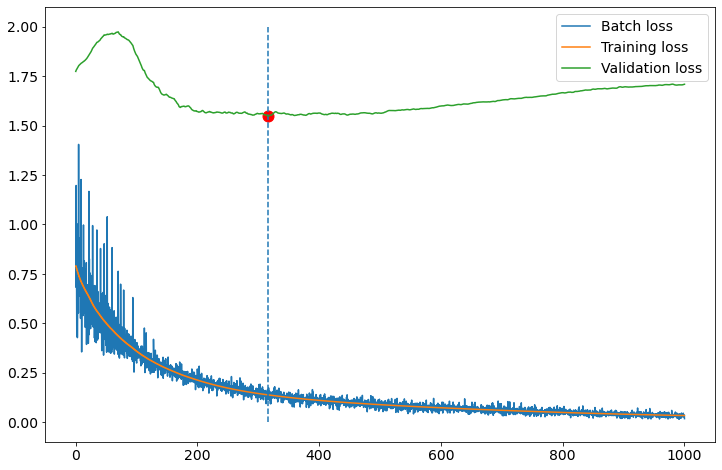

      1100       3300   0.020049   0.027220   1.708602     1.548544(316)   0.000500
      1200       3600   0.020276   0.022129   1.717346     1.548544(316)   0.000500
      1300       3900   0.021017   0.017234   1.727372     1.548544(316)   0.000500
      1400       4200   0.013653   0.012481   1.743527     1.548544(316)   0.000500
      1500       4500   0.009881   0.008514   1.761514     1.548544(316)   0.000500
      1600       4800   0.004381   0.005490   1.788273     1.548544(316)   0.000500
      1700       5100   0.004172   0.003433   1.810791     1.548544(316)   0.000500
      1800       5400   0.004884   0.002094   1.824502     1.548544(316)   0.000500
      1900       5700   0.000264   0.001276   1.837453     1.548544(316)   0.000500
      2000       6000   0.000917   0.000760   1.843527     1.548544(316)   0.000500


<Figure size 432x288 with 0 Axes>

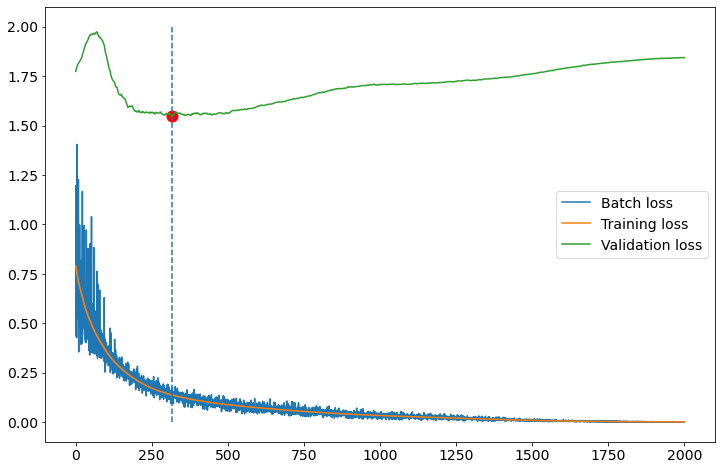

      2100       6300   0.000333   0.000434   1.848495     1.548544(316)   0.000500
      2200       6600   0.000035   0.000235   1.850329     1.548544(316)   0.000500
      2300       6900   0.000051   0.000117   1.849001     1.548544(316)   0.000500
      2400       7200   0.000045   0.000053   1.851619     1.548544(316)   0.000500
      2500       7500   0.000014   0.000022   1.854101     1.548544(316)   0.000500
      2600       7800   0.000012   0.000008   1.855365     1.548544(316)   0.000500
      2700       8100   0.000004   0.000002   1.855957     1.548544(316)   0.000500
      2800       8400   0.000000   0.000001   1.856380     1.548544(316)   0.000500
      2900       8700   0.000000   0.000000   1.856360     1.548544(316)   0.000500
      3000       9000   0.000000   0.000001   1.856919     1.548544(316)   0.000500


<Figure size 432x288 with 0 Axes>

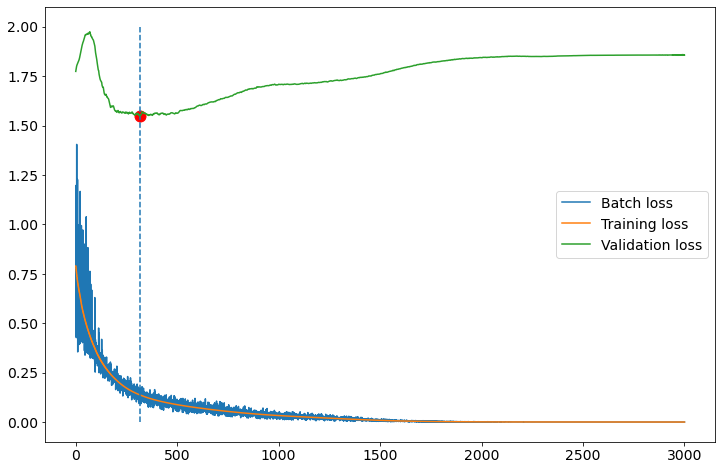

Fold 2:
  Train: index=[ 2  5  6  7  8  9 10 11 12 13 14 15 16 17]
  Test:  index=[0 1 3 4]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.530733   1.151396   0.376015     0.375735(0)   0.000500
       100        300   0.396439   0.594069   0.445736     0.375735(0)   0.000500
       200        600   0.179678   0.319622   0.495532     0.375735(0)   0.000500
       300        900   0.176599   0.201992   0.576333     0.375735(0)   0.000500
       400       1200   0.087611   0.145080   0.691043     0.375735(0)   0.000500
       500       1500   0.088591   0.112328   0.797511     0.375735(0)   0.000500
       600       1800   0.106491   0.090650   0.839651     0.375735(0)   0.000500
       700       2100   0.061087   0.076453   0.861224     0.375735(0)   0.000500
       800       2400   0.046309   0.066041   0.886150     0.375735(0)   0.000500
       900       2700   0.040250   0.058132   0.905534     0.375735(0)   0.000500
      

<Figure size 432x288 with 0 Axes>

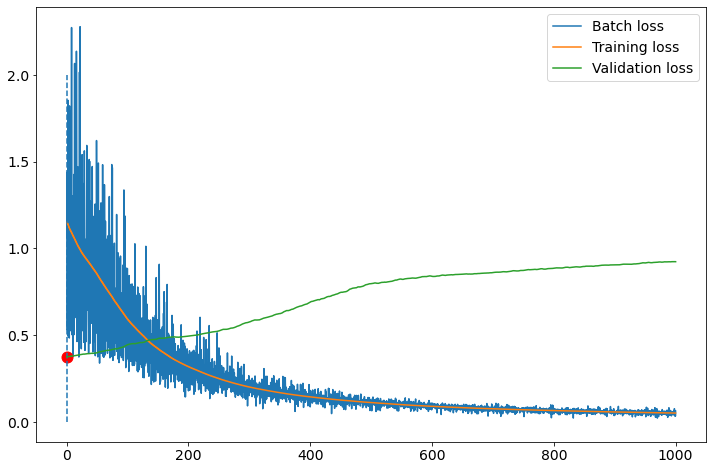

      1100       3300   0.014791   0.046276   0.942700     0.375735(0)   0.000500
      1200       3600   0.022085   0.041408   0.963664     0.375735(0)   0.000500
      1300       3900   0.044266   0.036909   0.986350     0.375735(0)   0.000500
      1400       4200   0.020457   0.032848   1.006222     0.375735(0)   0.000500
      1500       4500   0.031383   0.029165   1.022402     0.375735(0)   0.000500
      1600       4800   0.041614   0.025612   1.036830     0.375735(0)   0.000500
      1700       5100   0.035337   0.022176   1.040048     0.375735(0)   0.000500
      1800       5400   0.019991   0.018943   1.031354     0.375735(0)   0.000500
      1900       5700   0.017033   0.015829   1.009675     0.375735(0)   0.000500
      2000       6000   0.016145   0.012723   0.997986     0.375735(0)   0.000500


<Figure size 432x288 with 0 Axes>

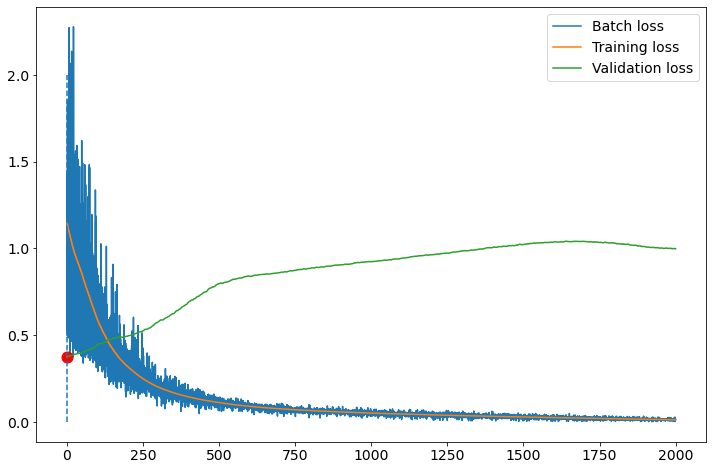

      2100       6300   0.004590   0.009649   0.991122     0.375735(0)   0.000500
      2200       6600   0.007180   0.006593   0.985395     0.375735(0)   0.000500
      2300       6900   0.003700   0.004083   0.975684     0.375735(0)   0.000500
      2400       7200   0.001178   0.002301   0.966894     0.375735(0)   0.000500
      2500       7500   0.001012   0.001210   0.956841     0.375735(0)   0.000500
      2600       7800   0.000131   0.000573   0.948074     0.375735(0)   0.000500
      2700       8100   0.000056   0.000239   0.941181     0.375735(0)   0.000500
      2800       8400   0.000121   0.000082   0.935631     0.375735(0)   0.000500
      2900       8700   0.000054   0.000025   0.931964     0.375735(0)   0.000500
      3000       9000   0.000007   0.000006   0.929519     0.375735(0)   0.000500


<Figure size 432x288 with 0 Axes>

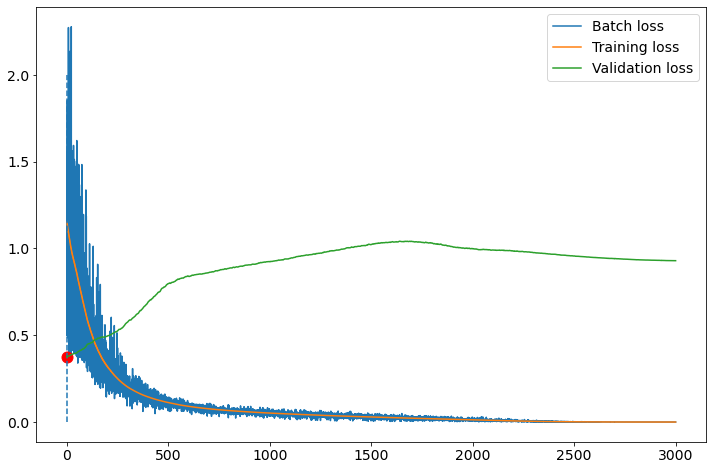

Fold 3:
  Train: index=[ 0  1  2  3  4  5  7  8 10 11 12 13 15 16 17]
  Test:  index=[ 6  9 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.874619   0.989158   1.339313     1.339313(0)   0.000500
       100        300   0.697598   0.483378   0.789262     0.789262(99)   0.000500
       200        600   0.187283   0.238055   0.553366     0.553366(199)   0.000500
       300        900   0.127412   0.150009   0.492479     0.492479(299)   0.000500
       400       1200   0.154420   0.107582   0.471160     0.471160(399)   0.000500
       500       1500   0.073313   0.081837   0.454256     0.454256(499)   0.000500
       600       1800   0.044501   0.063884   0.446604     0.446333(594)   0.000500
       700       2100   0.068133   0.050307   0.443165     0.443165(699)   0.000500
       800       2400   0.032296   0.039816   0.443169     0.442593(779)   0.000500
       900       2700   0.026289   0.031221   0.445283     0.442593(7

<Figure size 432x288 with 0 Axes>

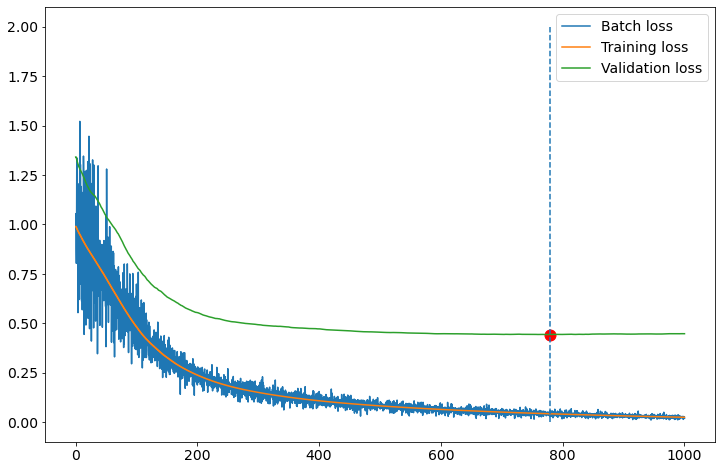

      1100       3300   0.020207   0.017700   0.447892     0.442593(779)   0.000500
      1200       3600   0.014866   0.012435   0.450587     0.442593(779)   0.000500
      1300       3900   0.005277   0.008096   0.454751     0.442593(779)   0.000500
      1400       4200   0.007749   0.004682   0.457406     0.442593(779)   0.000500
      1500       4500   0.002228   0.002471   0.463567     0.442593(779)   0.000500
      1600       4800   0.000865   0.001205   0.468536     0.442593(779)   0.000500
      1700       5100   0.000629   0.000570   0.473157     0.442593(779)   0.000500
      1800       5400   0.000439   0.000270   0.476605     0.442593(779)   0.000500
      1900       5700   0.000132   0.000125   0.478896     0.442593(779)   0.000500
      2000       6000   0.000027   0.000056   0.480670     0.442593(779)   0.000500


<Figure size 432x288 with 0 Axes>

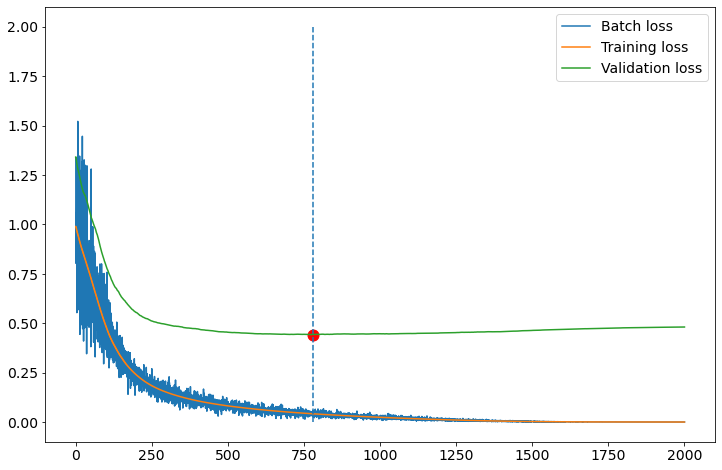

      2100       6300   0.000021   0.000023   0.481933     0.442593(779)   0.000500
      2200       6600   0.000011   0.000008   0.482755     0.442593(779)   0.000500
      2300       6900   0.000002   0.000003   0.483331     0.442593(779)   0.000500
      2400       7200   0.000002   0.000001   0.483684     0.442593(779)   0.000500
      2500       7500   0.000000   0.000000   0.483868     0.442593(779)   0.000500
      2600       7800   0.000000   0.000000   0.483964     0.442593(779)   0.000500
      2700       8100   0.000000   0.000000   0.484002     0.442593(779)   0.000500
      2800       8400   0.000000   0.000000   0.484020     0.442593(779)   0.000500
      2900       8700   0.000000   0.000000   0.484031     0.442593(779)   0.000500
      3000       9000   0.000000   0.000000   0.483549     0.442593(779)   0.000500


<Figure size 432x288 with 0 Axes>

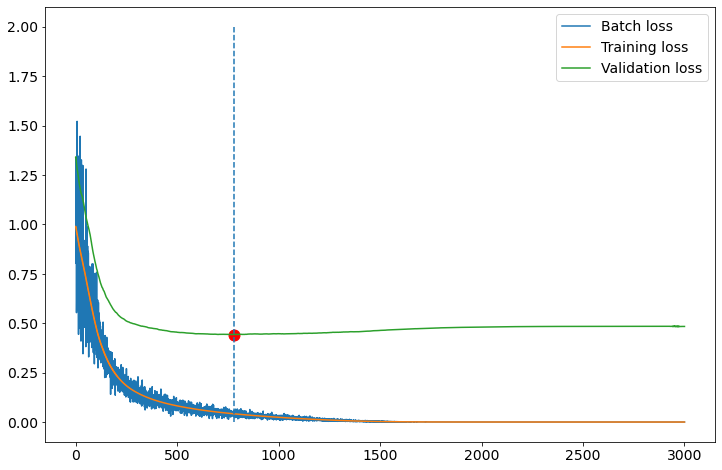

Fold 4:
  Train: index=[ 0  1  3  4  5  6  7  8  9 10 11 14 15 16 17]
  Test:  index=[ 2 12 13]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.222938   0.936229   1.284237     1.284237(0)   0.000500
       100        300   0.288999   0.514692   1.055446     1.055446(99)   0.000500
       200        600   0.184214   0.305320   0.858990     0.858967(199)   0.000500
       300        900   0.124823   0.186947   0.799081     0.799081(299)   0.000500
       400       1200   0.108096   0.117548   0.782230     0.775948(379)   0.000500
       500       1500   0.066570   0.080404   0.811946     0.775948(379)   0.000500
       600       1800   0.088084   0.059790   0.839686     0.775948(379)   0.000500
       700       2100   0.034056   0.046443   0.859415     0.775948(379)   0.000500
       800       2400   0.033320   0.036105   0.879309     0.775948(379)   0.000500
       900       2700   0.031396   0.027744   0.896618     0.775948(3

<Figure size 432x288 with 0 Axes>

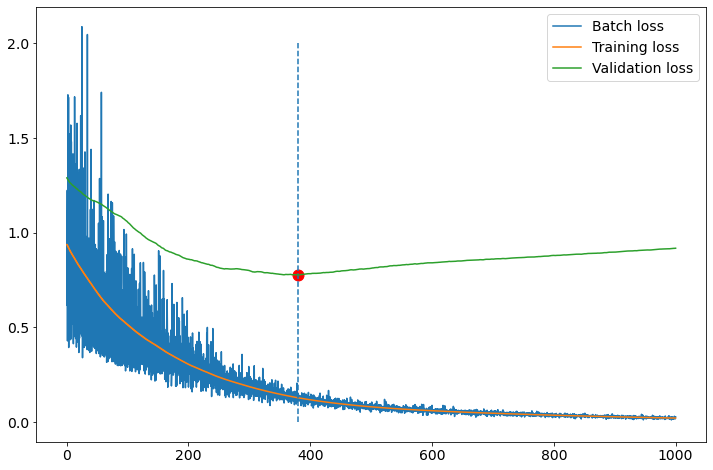

      1100       3300   0.017983   0.015627   0.934067     0.775948(379)   0.000500
      1200       3600   0.012876   0.011424   0.944784     0.775948(379)   0.000500
      1300       3900   0.006025   0.008101   0.953809     0.775948(379)   0.000500
      1400       4200   0.004609   0.005455   0.958326     0.775948(379)   0.000500
      1500       4500   0.002912   0.003492   0.961726     0.775948(379)   0.000500
      1600       4800   0.001594   0.002193   0.968121     0.775948(379)   0.000500
      1700       5100   0.002452   0.001404   0.975752     0.775948(379)   0.000500
      1800       5400   0.000268   0.000958   0.981463     0.775948(379)   0.000500
      1900       5700   0.000900   0.000697   0.983676     0.775948(379)   0.000500
      2000       6000   0.000125   0.000526   0.983226     0.775948(379)   0.000500


<Figure size 432x288 with 0 Axes>

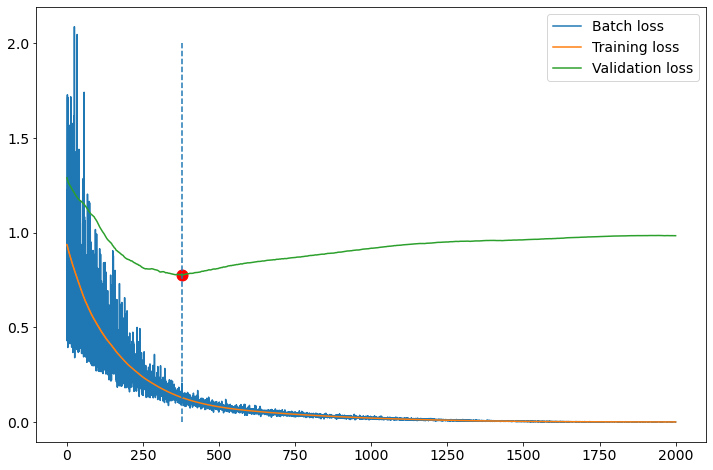

      2100       6300   0.000563   0.000400   0.979231     0.775948(379)   0.000500
      2200       6600   0.000184   0.000297   0.974600     0.775948(379)   0.000500
      2300       6900   0.000222   0.000212   0.969163     0.775948(379)   0.000500
      2400       7200   0.000079   0.000142   0.963528     0.775948(379)   0.000500
      2500       7500   0.000020   0.000088   0.958381     0.775948(379)   0.000500
      2600       7800   0.000054   0.000050   0.953909     0.775948(379)   0.000500
      2700       8100   0.000032   0.000025   0.950807     0.775948(379)   0.000500
      2800       8400   0.000005   0.000011   0.948657     0.775948(379)   0.000500
      2900       8700   0.000006   0.000004   0.946960     0.775948(379)   0.000500
      3000       9000   0.000009   0.000026   0.947737     0.775948(379)   0.000500


<Figure size 432x288 with 0 Axes>

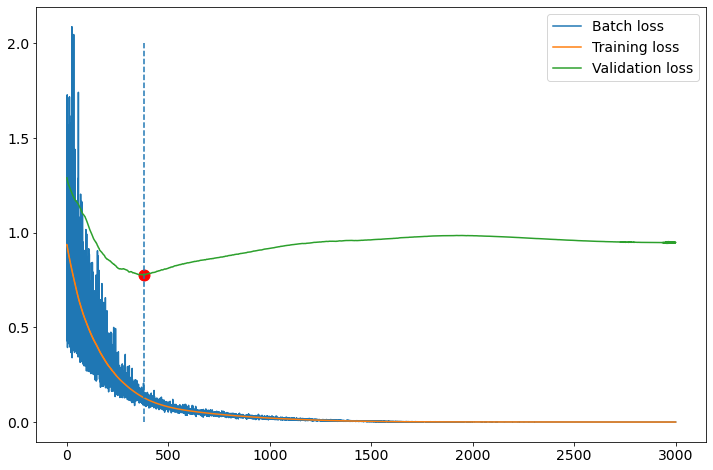

777
Fold 0:
  Train: index=[ 0  1  2  4  5  6  7  8  9 11 13 15 16 17]
  Test:  index=[ 3 10 12 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   2.195252   0.944174   1.072918     1.072918(0)   0.000500
       100        300   2.389234   0.637114   0.909641     0.909641(99)   0.000500
       200        600   0.286927   0.383014   0.748386     0.748386(199)   0.000500
       300        900   0.217278   0.206634   0.681822     0.671120(271)   0.000500
       400       1200   0.143330   0.143878   0.770684     0.671120(271)   0.000500
       500       1500   0.103110   0.106282   0.868798     0.671120(271)   0.000500
       600       1800   0.089999   0.081384   0.919961     0.671120(271)   0.000500
       700       2100   0.079131   0.063546   0.959528     0.671120(271)   0.000500
       800       2400   0.028010   0.051853   0.986345     0.671120(271)   0.000500
       900       2700   0.049915   0.043279   1.006368     0.6711

<Figure size 432x288 with 0 Axes>

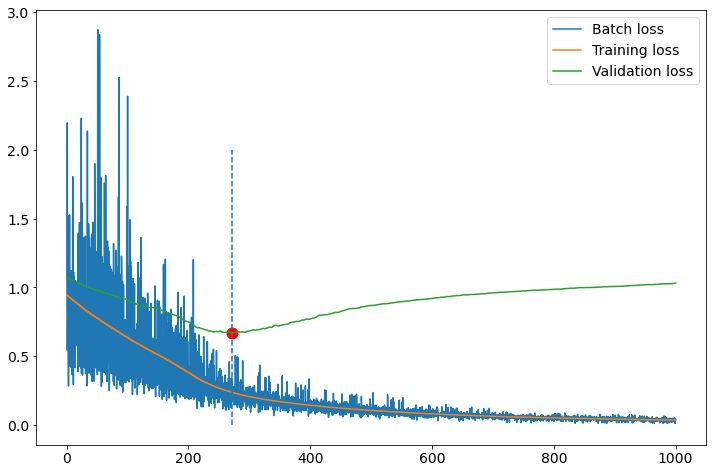

      1100       3300   0.046615   0.029171   1.056714     0.671120(271)   0.000500
      1200       3600   0.012583   0.023149   1.090362     0.671120(271)   0.000500
      1300       3900   0.024228   0.017901   1.126616     0.671120(271)   0.000500
      1400       4200   0.011031   0.013439   1.158328     0.671120(271)   0.000500
      1500       4500   0.010146   0.009845   1.189883     0.671120(271)   0.000500
      1600       4800   0.002607   0.007036   1.214643     0.671120(271)   0.000500
      1700       5100   0.004112   0.004784   1.241629     0.671120(271)   0.000500
      1800       5400   0.000646   0.003157   1.268311     0.671120(271)   0.000500
      1900       5700   0.000709   0.002061   1.292487     0.671120(271)   0.000500
      2000       6000   0.002197   0.001394   1.309833     0.671120(271)   0.000500


<Figure size 432x288 with 0 Axes>

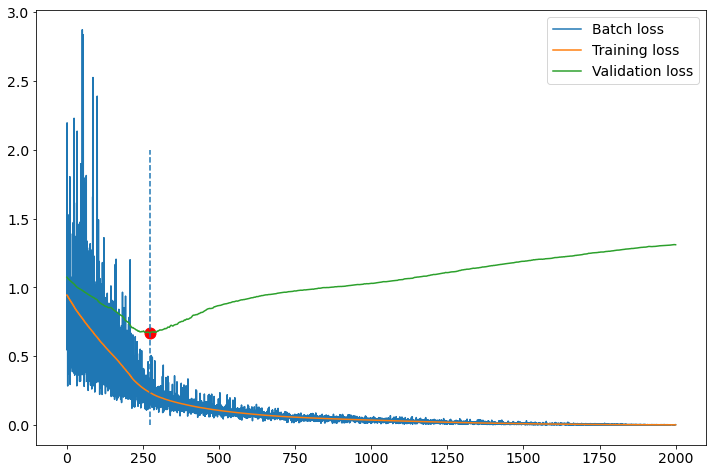

      2100       6300   0.001386   0.000998   1.325591     0.671120(271)   0.000500
      2200       6600   0.000895   0.000779   1.337558     0.671120(271)   0.000500
      2300       6900   0.001089   0.000648   1.347932     0.671120(271)   0.000500
      2400       7200   0.000962   0.000532   1.358448     0.671120(271)   0.000500
      2500       7500   0.000164   0.000421   1.370235     0.671120(271)   0.000500
      2600       7800   0.000541   0.000310   1.379798     0.671120(271)   0.000500
      2700       8100   0.000330   0.000202   1.391851     0.671120(271)   0.000500
      2800       8400   0.000033   0.000111   1.398900     0.671120(271)   0.000500
      2900       8700   0.000021   0.000054   1.402462     0.671120(271)   0.000500
      3000       9000   0.000029   0.000021   1.407531     0.671120(271)   0.000500


<Figure size 432x288 with 0 Axes>

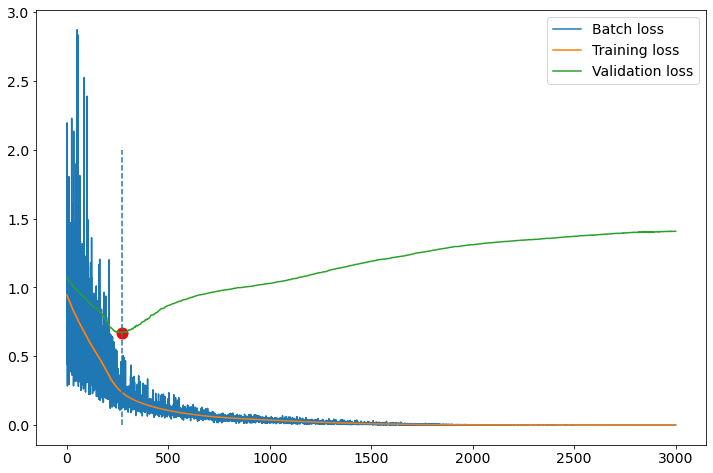

Fold 1:
  Train: index=[ 1  3  4  6  7  8 10 11 12 13 14 15 16 17]
  Test:  index=[0 2 5 9]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.276258   1.002632   0.621116     0.620291(0)   0.000500
       100        300   0.377352   0.437904   0.501802     0.501802(99)   0.000500
       200        600   0.404528   0.222686   0.490912     0.474741(163)   0.000500
       300        900   0.123582   0.141450   0.534054     0.474741(163)   0.000500
       400       1200   0.116220   0.106176   0.556874     0.474741(163)   0.000500
       500       1500   0.068583   0.084700   0.563094     0.474741(163)   0.000500
       600       1800   0.055813   0.068315   0.575679     0.474741(163)   0.000500
       700       2100   0.049719   0.054448   0.576348     0.474741(163)   0.000500
       800       2400   0.060229   0.043085   0.584720     0.474741(163)   0.000500
       900       2700   0.015810   0.033914   0.595533     0.474741(163) 

<Figure size 432x288 with 0 Axes>

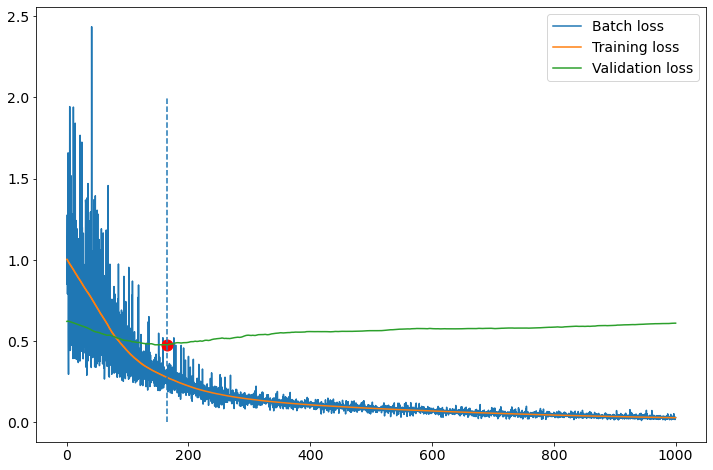

      1100       3300   0.014525   0.020848   0.618197     0.474741(163)   0.000500
      1200       3600   0.027187   0.016095   0.626015     0.474741(163)   0.000500
      1300       3900   0.012299   0.012036   0.630672     0.474741(163)   0.000500
      1400       4200   0.011871   0.008645   0.643516     0.474741(163)   0.000500
      1500       4500   0.005445   0.005962   0.654482     0.474741(163)   0.000500
      1600       4800   0.000651   0.003999   0.650624     0.474741(163)   0.000500
      1700       5100   0.003445   0.002570   0.646288     0.474741(163)   0.000500
      1800       5400   0.000191   0.001541   0.640270     0.474741(163)   0.000500
      1900       5700   0.000546   0.000859   0.634194     0.474741(163)   0.000500
      2000       6000   0.000435   0.000427   0.630656     0.474741(163)   0.000500


<Figure size 432x288 with 0 Axes>

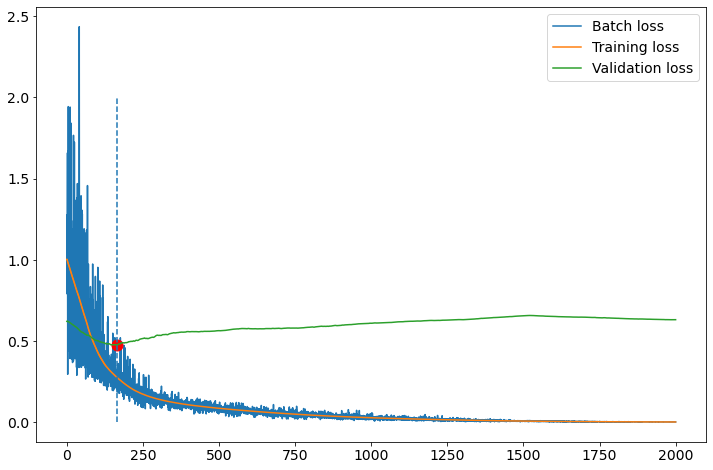

      2100       6300   0.000285   0.000192   0.628947     0.474741(163)   0.000500
      2200       6600   0.000066   0.000078   0.627559     0.474741(163)   0.000500
      2300       6900   0.000017   0.000029   0.628030     0.474741(163)   0.000500
      2400       7200   0.000002   0.000010   0.628840     0.474741(163)   0.000500
      2500       7500   0.000003   0.000003   0.629451     0.474741(163)   0.000500
      2600       7800   0.000000   0.000001   0.629794     0.474741(163)   0.000500
      2700       8100   0.000001   0.000000   0.630249     0.474741(163)   0.000500
      2800       8400   0.000004   0.000005   0.629499     0.474741(163)   0.000500
      2900       8700   0.000005   0.000004   0.628928     0.474741(163)   0.000500
      3000       9000   0.000000   0.000002   0.629486     0.474741(163)   0.000500


<Figure size 432x288 with 0 Axes>

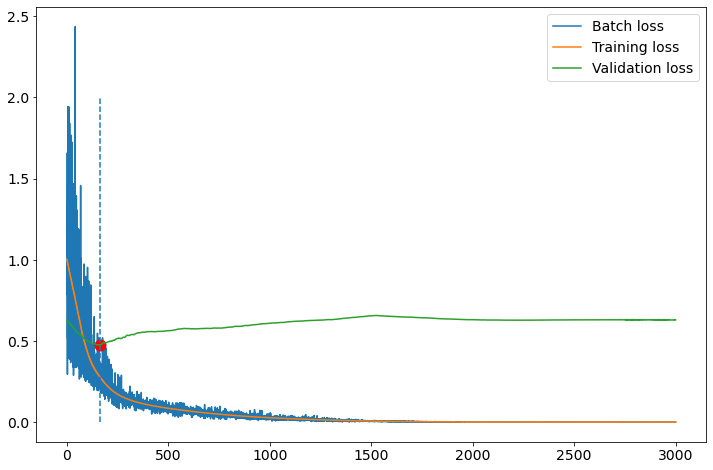

Fold 2:
  Train: index=[ 0  1  2  3  5  6  7  9 10 11 12 14 15 17]
  Test:  index=[ 4  8 13 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.305502   0.800592   1.474419     1.466340(0)   0.000500
       100        300   0.671530   0.377736   1.589090     1.466340(0)   0.000500
       200        600   0.176827   0.216083   1.474685     1.466340(0)   0.000500
       300        900   0.166211   0.148816   1.487666     1.459420(225)   0.000500
       400       1200   0.095499   0.109030   1.483649     1.459420(225)   0.000500
       500       1500   0.061920   0.079781   1.487100     1.459420(225)   0.000500
       600       1800   0.044225   0.057401   1.484429     1.459420(225)   0.000500
       700       2100   0.049115   0.042779   1.477666     1.459420(225)   0.000500
       800       2400   0.034557   0.033830   1.474972     1.459420(225)   0.000500
       900       2700   0.030701   0.027610   1.475360     1.459420(225)

<Figure size 432x288 with 0 Axes>

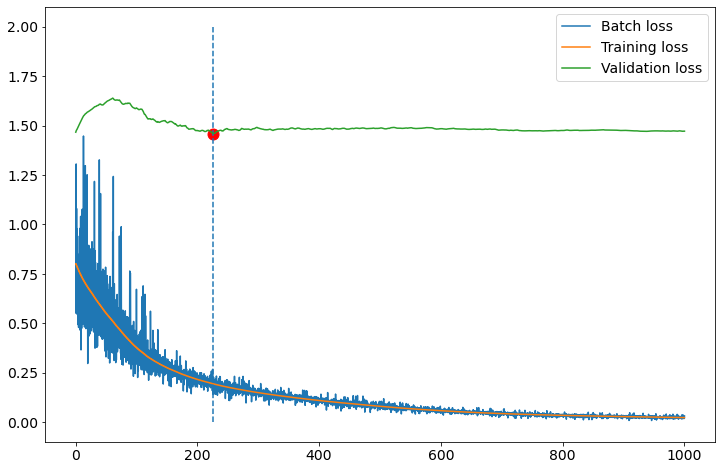

      1100       3300   0.016391   0.017989   1.466016     1.459420(225)   0.000500
      1200       3600   0.018414   0.013884   1.465749     1.459420(225)   0.000500
      1300       3900   0.016617   0.010318   1.458296     1.457636(1292)   0.000500
      1400       4200   0.012855   0.007404   1.445065     1.444857(1383)   0.000500
      1500       4500   0.002452   0.005098   1.434495     1.434102(1495)   0.000500
      1600       4800   0.005269   0.003354   1.426841     1.426488(1597)   0.000500
      1700       5100   0.002024   0.002093   1.419443     1.417982(1696)   0.000500
      1800       5400   0.000534   0.001228   1.411047     1.411047(1799)   0.000500
      1900       5700   0.001091   0.000658   1.408382     1.408142(1878)   0.000500
      2000       6000   0.000650   0.000312   1.404519     1.404394(1998)   0.000500


<Figure size 432x288 with 0 Axes>

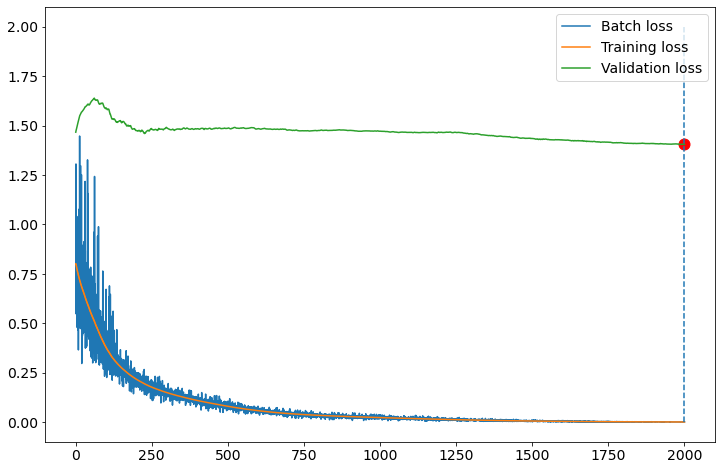

      2100       6300   0.000162   0.000129   1.401748     1.401491(2097)   0.000500
      2200       6600   0.000019   0.000046   1.400398     1.400375(2196)   0.000500
      2300       6900   0.000017   0.000013   1.400201     1.400073(2273)   0.000500
      2400       7200   0.000002   0.000003   1.399961     1.399688(2386)   0.000500
      2500       7500   0.000001   0.000000   1.399789     1.399681(2485)   0.000500
      2600       7800   0.000000   0.000000   1.399844     1.399681(2485)   0.000500
      2700       8100   0.000000   0.000000   1.399795     1.399681(2485)   0.000500
      2800       8400   0.000001   0.000001   1.399777     1.395596(2761)   0.000500
      2900       8700   0.000006   0.000002   1.401682     1.394871(2865)   0.000500
      3000       9000   0.000003   0.000002   1.401060     1.394596(2971)   0.000500


<Figure size 432x288 with 0 Axes>

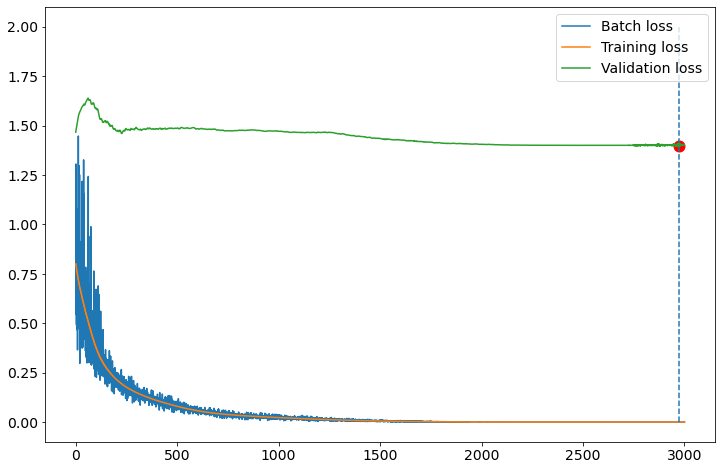

Fold 3:
  Train: index=[ 0  2  3  4  5  7  8  9 10 11 12 13 14 15 16]
  Test:  index=[ 1  6 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.290564   0.936575   0.761808     0.761808(0)   0.000500
       100        300   0.583802   0.444090   0.679342     0.679342(99)   0.000500
       200        600   0.213167   0.237257   0.620484     0.611960(149)   0.000500
       300        900   0.124542   0.156052   0.662213     0.611960(149)   0.000500
       400       1200   0.117565   0.115796   0.702420     0.611960(149)   0.000500
       500       1500   0.081376   0.088670   0.716148     0.611960(149)   0.000500
       600       1800   0.057547   0.068867   0.714979     0.611960(149)   0.000500
       700       2100   0.070739   0.056519   0.714835     0.611960(149)   0.000500
       800       2400   0.039922   0.047716   0.713746     0.611960(149)   0.000500
       900       2700   0.059493   0.040729   0.719643     0.611960(1

<Figure size 432x288 with 0 Axes>

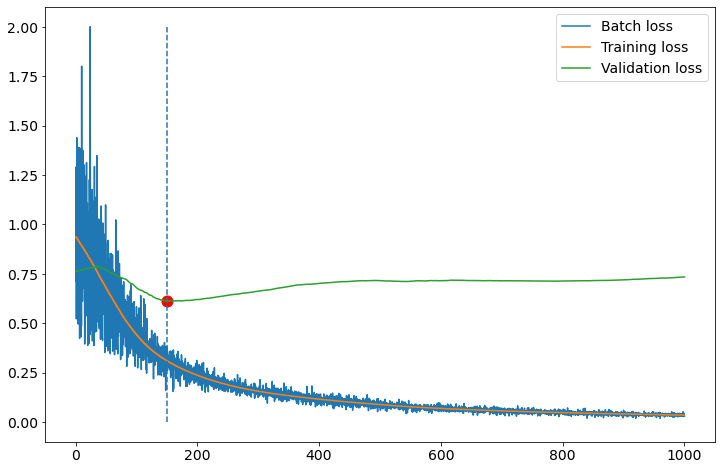

      1100       3300   0.028345   0.029737   0.750262     0.611960(149)   0.000500
      1200       3600   0.033493   0.025150   0.763484     0.611960(149)   0.000500
      1300       3900   0.029585   0.020838   0.782437     0.611960(149)   0.000500
      1400       4200   0.015274   0.016761   0.810286     0.611960(149)   0.000500
      1500       4500   0.009691   0.012818   0.845235     0.611960(149)   0.000500
      1600       4800   0.007331   0.009208   0.880983     0.611960(149)   0.000500
      1700       5100   0.005146   0.006108   0.918029     0.611960(149)   0.000500
      1800       5400   0.003487   0.003670   0.954956     0.611960(149)   0.000500
      1900       5700   0.001344   0.002013   0.985395     0.611960(149)   0.000500
      2000       6000   0.000872   0.001020   1.010264     0.611960(149)   0.000500


<Figure size 432x288 with 0 Axes>

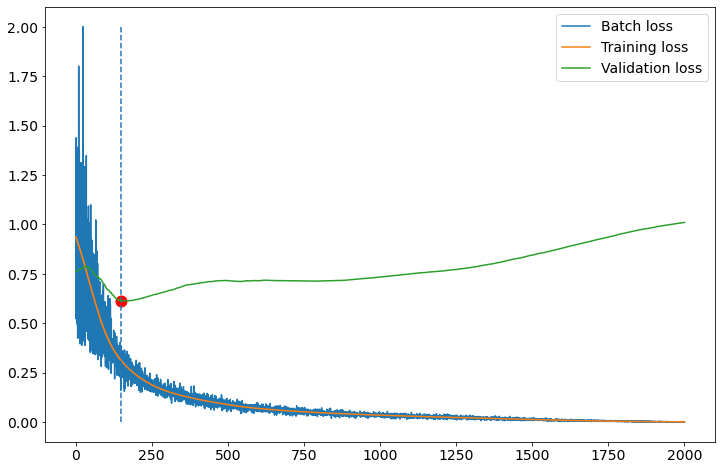

      2100       6300   0.000373   0.000489   1.028722     0.611960(149)   0.000500
      2200       6600   0.000330   0.000229   1.040632     0.611960(149)   0.000500
      2300       6900   0.000115   0.000103   1.048414     0.611960(149)   0.000500
      2400       7200   0.000045   0.000045   1.053868     0.611960(149)   0.000500
      2500       7500   0.000028   0.000018   1.057243     0.611960(149)   0.000500
      2600       7800   0.000008   0.000007   1.059459     0.611960(149)   0.000500
      2700       8100   0.000000   0.000002   1.060764     0.611960(149)   0.000500
      2800       8400   0.000001   0.000001   1.061484     0.611960(149)   0.000500
      2900       8700   0.000000   0.000000   1.061850     0.611960(149)   0.000500
      3000       9000   0.000000   0.000000   1.062068     0.611960(149)   0.000500


<Figure size 432x288 with 0 Axes>

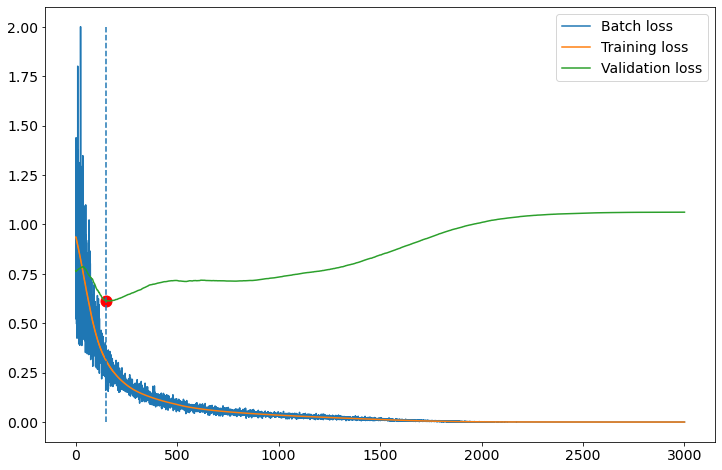

Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  8  9 10 12 13 14 16 17]
  Test:  index=[ 7 11 15]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.006983   1.140830   0.535525     0.535525(0)   0.000500
       100        300   0.698501   0.488037   0.778504     0.518116(31)   0.000500
       200        600   0.251574   0.280604   1.365672     0.518116(31)   0.000500
       300        900   0.172723   0.198308   1.434895     0.518116(31)   0.000500
       400       1200   0.180405   0.154315   1.435160     0.518116(31)   0.000500
       500       1500   0.135816   0.129608   1.430402     0.518116(31)   0.000500
       600       1800   0.109153   0.112345   1.436098     0.518116(31)   0.000500
       700       2100   0.100690   0.098226   1.453006     0.518116(31)   0.000500
       800       2400   0.070410   0.085907   1.465666     0.518116(31)   0.000500
       900       2700   0.089807   0.074732   1.491987     0.518116(31)   0.

<Figure size 432x288 with 0 Axes>

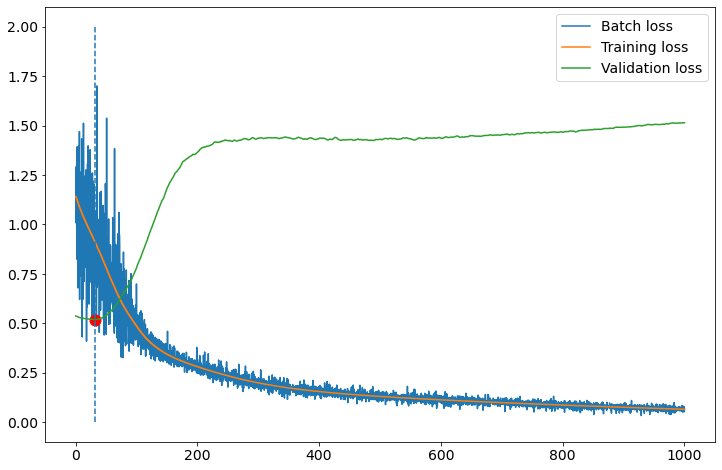

      1100       3300   0.054463   0.055935   1.534186     0.518116(31)   0.000500
      1200       3600   0.060162   0.048930   1.547648     0.518116(31)   0.000500
      1300       3900   0.040075   0.043426   1.556461     0.518116(31)   0.000500
      1400       4200   0.035780   0.039079   1.558324     0.518116(31)   0.000500
      1500       4500   0.037031   0.035480   1.558652     0.518116(31)   0.000500
      1600       4800   0.032751   0.032151   1.551793     0.518116(31)   0.000500
      1700       5100   0.022261   0.029015   1.541239     0.518116(31)   0.000500
      1800       5400   0.022103   0.025901   1.532562     0.518116(31)   0.000500
      1900       5700   0.021097   0.022791   1.523935     0.518116(31)   0.000500
      2000       6000   0.011135   0.019817   1.516854     0.518116(31)   0.000500


<Figure size 432x288 with 0 Axes>

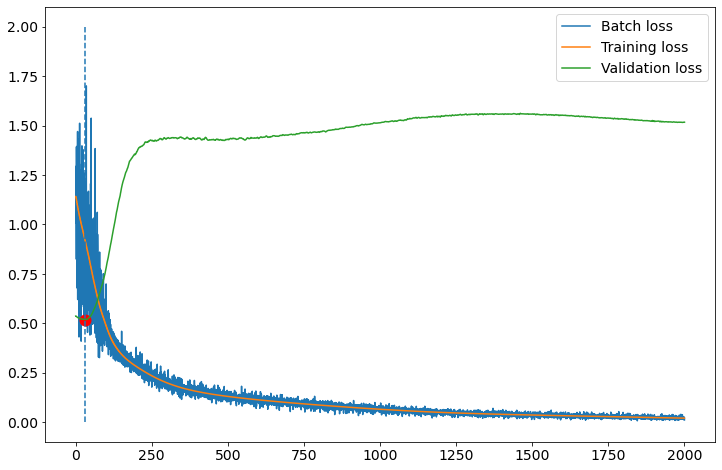

      2100       6300   0.014259   0.017003   1.495462     0.518116(31)   0.000500
      2200       6600   0.004773   0.014630   1.471789     0.518116(31)   0.000500
      2300       6900   0.023178   0.012627   1.450638     0.518116(31)   0.000500
      2400       7200   0.013518   0.010908   1.430860     0.518116(31)   0.000500
      2500       7500   0.014344   0.009416   1.411152     0.518116(31)   0.000500
      2600       7800   0.002321   0.008129   1.392461     0.518116(31)   0.000500
      2700       8100   0.008565   0.007130   1.374026     0.518116(31)   0.000500
      2800       8400   0.003919   0.006372   1.358787     0.518116(31)   0.000500
      2900       8700   0.002386   0.005811   1.344314     0.518116(31)   0.000500
      3000       9000   0.010620   0.005370   1.334043     0.518116(31)   0.000500


<Figure size 432x288 with 0 Axes>

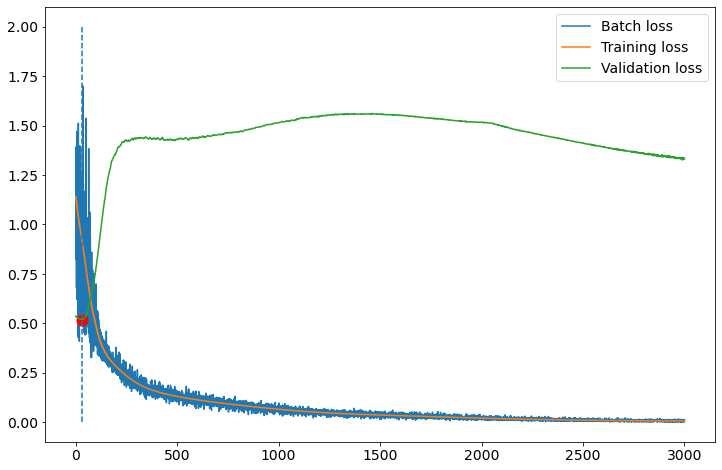

888
Fold 0:
  Train: index=[ 0  1  2  3  6  7  8  9 10 12 13 14 15 16]
  Test:  index=[ 4  5 11 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.223304   1.019937   0.719915     0.719915(0)   0.000500
       100        300   0.426467   0.433889   0.624612     0.603611(74)   0.000500
       200        600   0.327758   0.268405   0.568646     0.565228(197)   0.000500
       300        900   0.172900   0.192656   0.559715     0.558754(282)   0.000500
       400       1200   0.173689   0.149599   0.546810     0.546310(396)   0.000500
       500       1500   0.136568   0.119473   0.535799     0.531867(492)   0.000500
       600       1800   0.091287   0.095788   0.536608     0.531140(584)   0.000500
       700       2100   0.062348   0.077685   0.538216     0.531140(584)   0.000500
       800       2400   0.058611   0.064260   0.541618     0.531140(584)   0.000500
       900       2700   0.031935   0.054068   0.539105     0.5311

<Figure size 432x288 with 0 Axes>

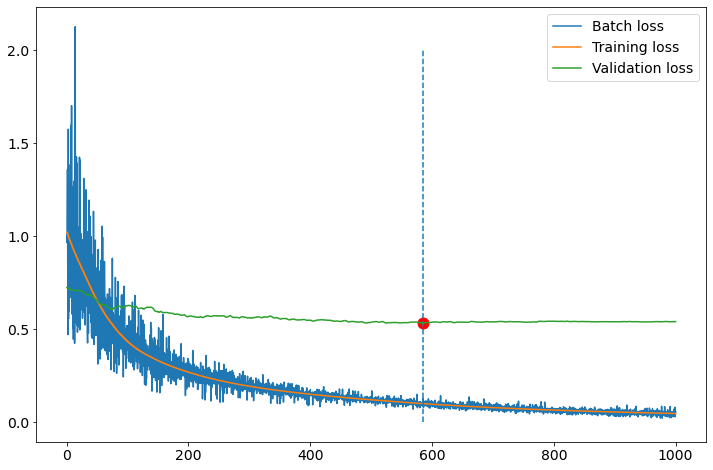

      1100       3300   0.040604   0.038693   0.541013     0.531140(584)   0.000500
      1200       3600   0.038538   0.032623   0.542803     0.531140(584)   0.000500
      1300       3900   0.011167   0.027135   0.541793     0.531140(584)   0.000500
      1400       4200   0.024378   0.022114   0.543197     0.531140(584)   0.000500
      1500       4500   0.015598   0.017270   0.551842     0.531140(584)   0.000500
      1600       4800   0.009793   0.012876   0.563306     0.531140(584)   0.000500
      1700       5100   0.005367   0.009146   0.568467     0.531140(584)   0.000500
      1800       5400   0.005980   0.006200   0.574038     0.531140(584)   0.000500
      1900       5700   0.002315   0.003977   0.576554     0.531140(584)   0.000500
      2000       6000   0.004562   0.002377   0.577726     0.531140(584)   0.000500


<Figure size 432x288 with 0 Axes>

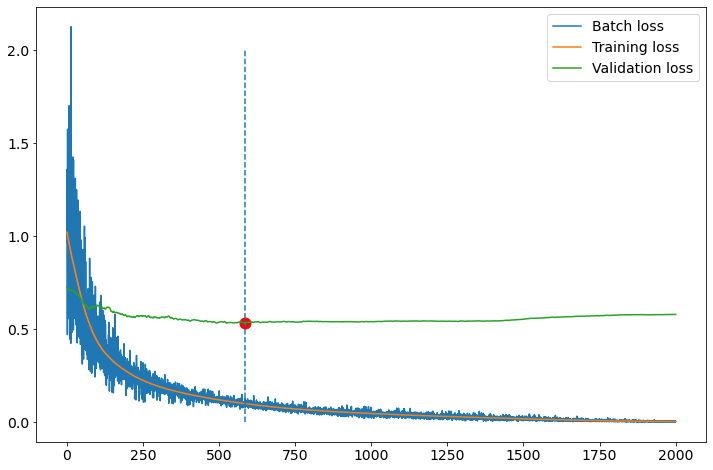

      2100       6300   0.000489   0.001278   0.580997     0.531140(584)   0.000500
      2200       6600   0.001596   0.000649   0.582659     0.531140(584)   0.000500
      2300       6900   0.000133   0.000275   0.583877     0.531140(584)   0.000500
      2400       7200   0.000035   0.000107   0.584606     0.531140(584)   0.000500
      2500       7500   0.000007   0.000035   0.584797     0.531140(584)   0.000500
      2600       7800   0.000005   0.000010   0.585094     0.531140(584)   0.000500
      2700       8100   0.000002   0.000003   0.585314     0.531140(584)   0.000500
      2800       8400   0.000000   0.000001   0.585420     0.531140(584)   0.000500
      2900       8700   0.000000   0.000000   0.585541     0.531140(584)   0.000500
      3000       9000   0.000000   0.000000   0.585580     0.531140(584)   0.000500


<Figure size 432x288 with 0 Axes>

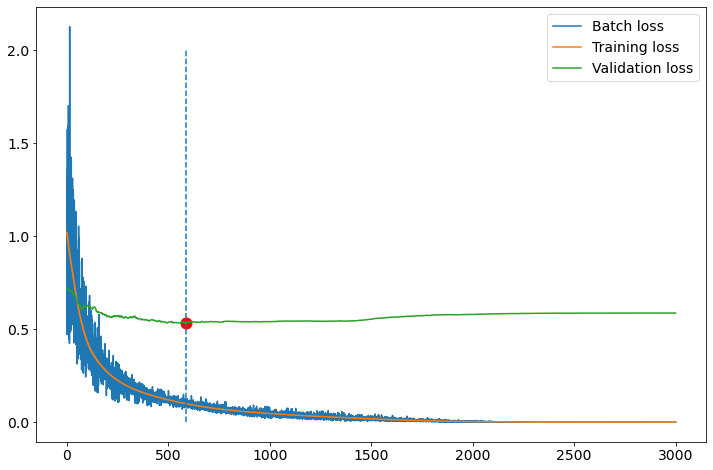

Fold 1:
  Train: index=[ 0  1  3  4  5  6  7  9 10 11 13 14 15 17]
  Test:  index=[ 2  8 12 16]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.629111   0.675547   2.263503     2.245725(0)   0.000500
       100        300   0.244588   0.315627   2.607858     2.245725(0)   0.000500
       200        600   0.288238   0.199564   2.345723     2.245725(0)   0.000500
       300        900   0.149130   0.132652   2.234285     2.227066(294)   0.000500
       400       1200   0.061886   0.094525   2.184389     2.184389(399)   0.000500
       500       1500   0.099268   0.072135   2.183155     2.173250(492)   0.000500
       600       1800   0.088283   0.057235   2.174803     2.165825(575)   0.000500
       700       2100   0.051859   0.046406   2.185186     2.165825(575)   0.000500
       800       2400   0.025460   0.037666   2.210536     2.165825(575)   0.000500
       900       2700   0.027092   0.030337   2.241471     2.165825(575)

<Figure size 432x288 with 0 Axes>

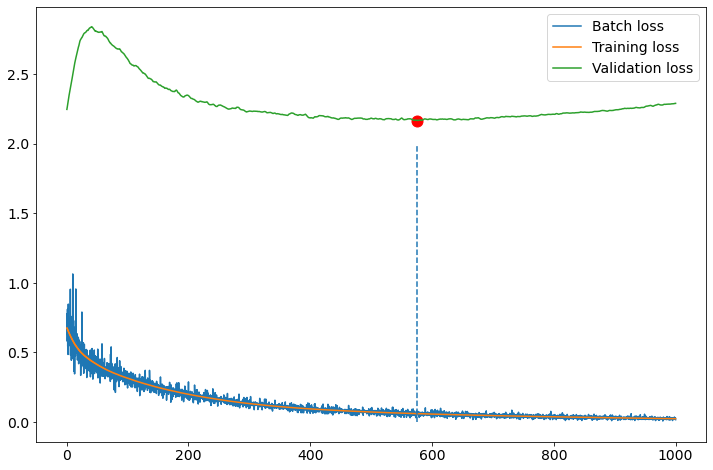

      1100       3300   0.013990   0.018779   2.331400     2.165825(575)   0.000500
      1200       3600   0.011220   0.014406   2.370111     2.165825(575)   0.000500
      1300       3900   0.002751   0.010745   2.405561     2.165825(575)   0.000500
      1400       4200   0.006165   0.007744   2.429261     2.165825(575)   0.000500
      1500       4500   0.003065   0.005394   2.445973     2.165825(575)   0.000500
      1600       4800   0.002896   0.003587   2.447886     2.165825(575)   0.000500
      1700       5100   0.003502   0.002272   2.448070     2.165825(575)   0.000500
      1800       5400   0.000897   0.001364   2.442092     2.165825(575)   0.000500
      1900       5700   0.000515   0.000777   2.436798     2.165825(575)   0.000500
      2000       6000   0.000667   0.000426   2.432164     2.165825(575)   0.000500


<Figure size 432x288 with 0 Axes>

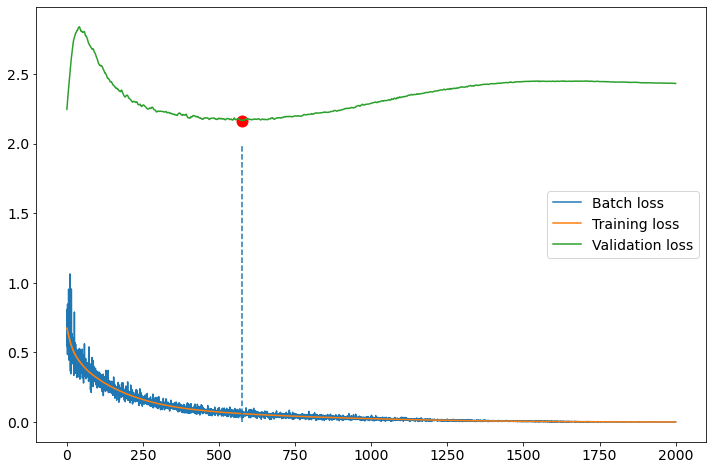

      2100       6300   0.000233   0.000220   2.431062     2.165825(575)   0.000500
      2200       6600   0.000012   0.000108   2.430042     2.165825(575)   0.000500
      2300       6900   0.000036   0.000049   2.430827     2.165825(575)   0.000500
      2400       7200   0.000021   0.000021   2.432980     2.165825(575)   0.000500
      2500       7500   0.000022   0.000008   2.434961     2.165825(575)   0.000500
      2600       7800   0.000008   0.000003   2.436170     2.165825(575)   0.000500
      2700       8100   0.000003   0.000001   2.436987     2.165825(575)   0.000500
      2800       8400   0.000000   0.000000   2.438660     2.165825(575)   0.000500
      2900       8700   0.000003   0.000002   2.439389     2.165825(575)   0.000500
      3000       9000   0.000000   0.000000   2.440195     2.165825(575)   0.000500


<Figure size 432x288 with 0 Axes>

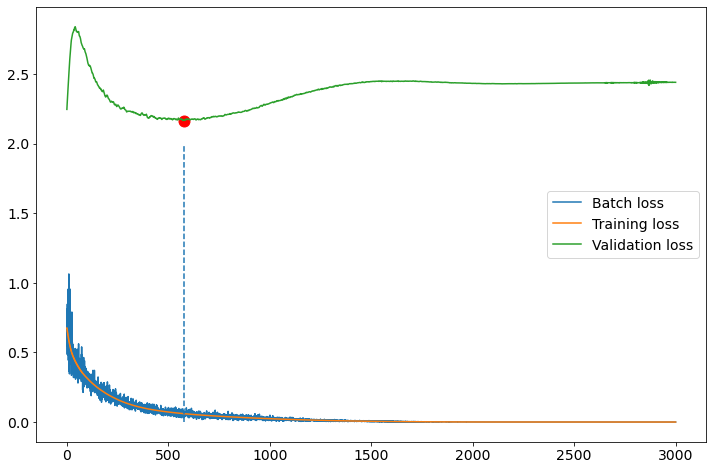

Fold 2:
  Train: index=[ 2  3  4  5  6  7  8  9 11 12 13 15 16 17]
  Test:  index=[ 0  1 10 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.497664   1.032837   0.637954     0.637954(0)   0.000500
       100        300   0.666989   0.550029   0.420694     0.420694(99)   0.000500
       200        600   0.177730   0.276084   0.468254     0.420532(104)   0.000500
       300        900   0.239750   0.184716   0.481081     0.420532(104)   0.000500
       400       1200   0.130230   0.136440   0.497765     0.420532(104)   0.000500
       500       1500   0.109039   0.108678   0.510180     0.420532(104)   0.000500
       600       1800   0.080041   0.091526   0.512872     0.420532(104)   0.000500
       700       2100   0.080591   0.079127   0.520605     0.420532(104)   0.000500
       800       2400   0.074413   0.069692   0.527295     0.420532(104)   0.000500
       900       2700   0.054330   0.061719   0.537234     0.420532(1

<Figure size 432x288 with 0 Axes>

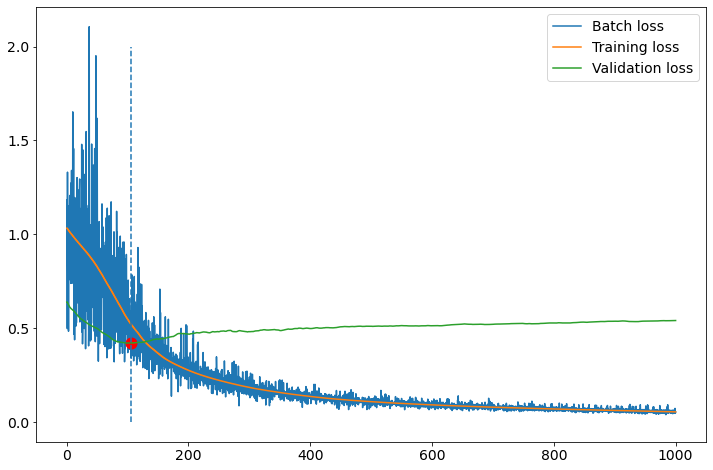

      1100       3300   0.054487   0.047235   0.550101     0.420532(104)   0.000500
      1200       3600   0.045597   0.040151   0.549343     0.420532(104)   0.000500
      1300       3900   0.032286   0.033303   0.545176     0.420532(104)   0.000500
      1400       4200   0.019083   0.026707   0.536987     0.420532(104)   0.000500
      1500       4500   0.021281   0.020570   0.526448     0.420532(104)   0.000500
      1600       4800   0.021650   0.015239   0.523709     0.420532(104)   0.000500
      1700       5100   0.015248   0.010808   0.522724     0.420532(104)   0.000500
      1800       5400   0.011101   0.007190   0.512716     0.420532(104)   0.000500
      1900       5700   0.006048   0.004342   0.503730     0.420532(104)   0.000500
      2000       6000   0.004662   0.002392   0.499399     0.420532(104)   0.000500


<Figure size 432x288 with 0 Axes>

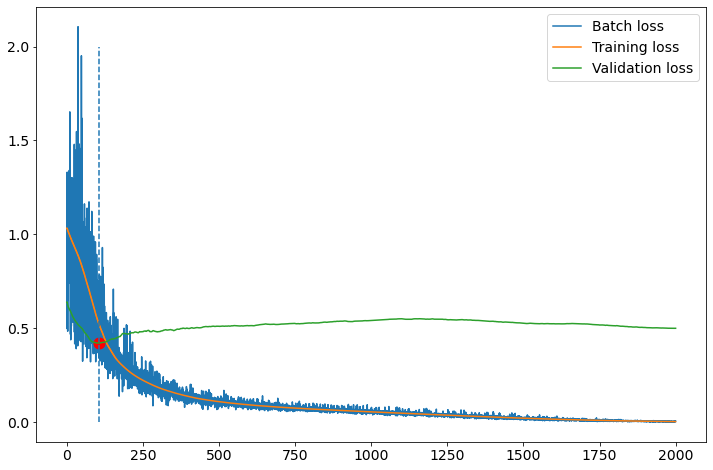

      2100       6300   0.000724   0.001160   0.499181     0.420532(104)   0.000500
      2200       6600   0.000431   0.000482   0.500651     0.420532(104)   0.000500
      2300       6900   0.000278   0.000176   0.502398     0.420532(104)   0.000500
      2400       7200   0.000023   0.000057   0.503373     0.420532(104)   0.000500
      2500       7500   0.000002   0.000016   0.504231     0.420532(104)   0.000500
      2600       7800   0.000002   0.000004   0.504454     0.420532(104)   0.000500
      2700       8100   0.000000   0.000001   0.504724     0.420532(104)   0.000500
      2800       8400   0.000000   0.000000   0.504808     0.420532(104)   0.000500
      2900       8700   0.000000   0.000000   0.504829     0.420532(104)   0.000500
      3000       9000   0.000000   0.000000   0.504840     0.420532(104)   0.000500


<Figure size 432x288 with 0 Axes>

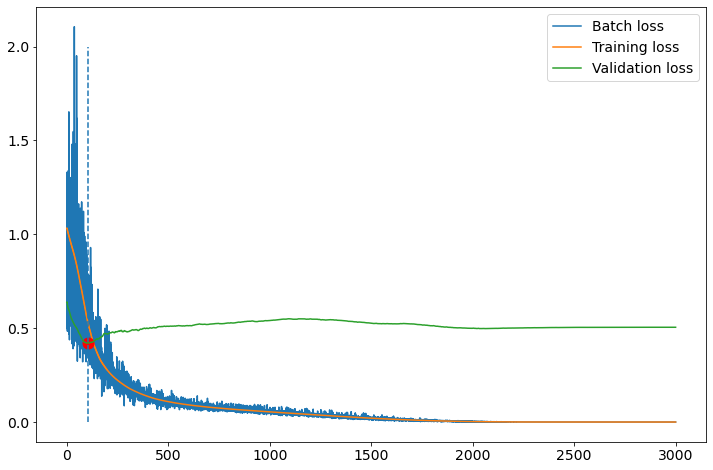

Fold 3:
  Train: index=[ 0  1  2  4  5  6  8 10 11 12 13 14 15 16 17]
  Test:  index=[3 7 9]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.557630   1.113771   0.512258     0.512258(0)   0.000500
       100        300   0.591353   0.483997   0.613475     0.500796(22)   0.000500
       200        600   0.303473   0.284534   0.837937     0.500796(22)   0.000500
       300        900   0.139890   0.197000   0.879713     0.500796(22)   0.000500
       400       1200   0.171404   0.144443   0.912269     0.500796(22)   0.000500
       500       1500   0.114902   0.115594   0.945086     0.500796(22)   0.000500
       600       1800   0.107032   0.096879   0.959798     0.500796(22)   0.000500
       700       2100   0.097001   0.082567   0.950765     0.500796(22)   0.000500
       800       2400   0.075052   0.070755   0.927207     0.500796(22)   0.000500
       900       2700   0.066950   0.060340   0.891416     0.500796(22)   0.000

<Figure size 432x288 with 0 Axes>

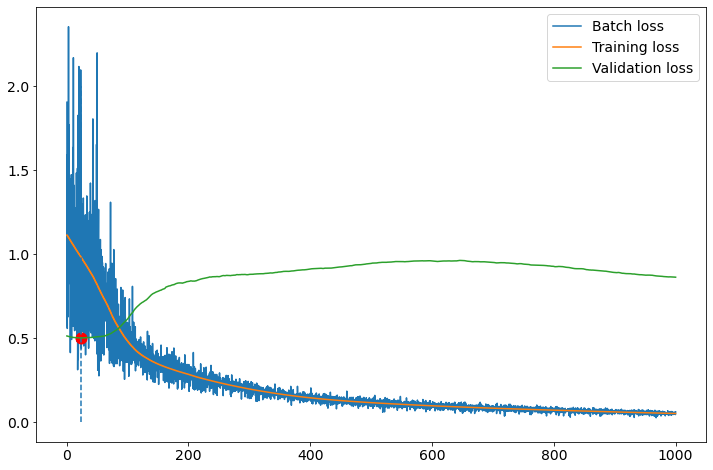

      1100       3300   0.043585   0.042776   0.838966     0.500796(22)   0.000500
      1200       3600   0.025010   0.035404   0.821475     0.500796(22)   0.000500
      1300       3900   0.037529   0.029259   0.808346     0.500796(22)   0.000500
      1400       4200   0.031761   0.024182   0.804494     0.500796(22)   0.000500
      1500       4500   0.011679   0.019886   0.805328     0.500796(22)   0.000500
      1600       4800   0.014673   0.016479   0.805571     0.500796(22)   0.000500
      1700       5100   0.018288   0.013615   0.808995     0.500796(22)   0.000500
      1800       5400   0.008360   0.011127   0.810089     0.500796(22)   0.000500
      1900       5700   0.004254   0.008920   0.815139     0.500796(22)   0.000500
      2000       6000   0.008356   0.006956   0.817039     0.500796(22)   0.000500


<Figure size 432x288 with 0 Axes>

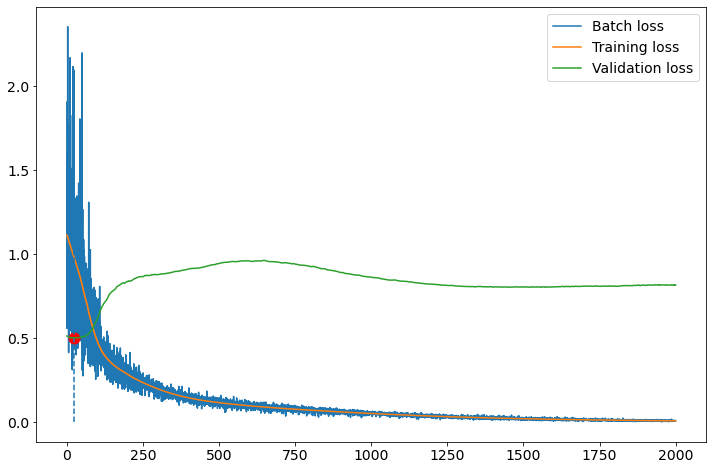

      2100       6300   0.005517   0.005210   0.817191     0.500796(22)   0.000500
      2200       6600   0.003887   0.003603   0.812567     0.500796(22)   0.000500
      2300       6900   0.002186   0.002257   0.805170     0.500796(22)   0.000500
      2400       7200   0.001271   0.001225   0.798167     0.500796(22)   0.000500
      2500       7500   0.000549   0.000574   0.793105     0.500796(22)   0.000500
      2600       7800   0.000135   0.000238   0.790488     0.500796(22)   0.000500
      2700       8100   0.000121   0.000087   0.786789     0.500796(22)   0.000500
      2800       8400   0.000013   0.000028   0.783937     0.500796(22)   0.000500
      2900       8700   0.000009   0.000008   0.781934     0.500796(22)   0.000500
      3000       9000   0.000001   0.000002   0.780801     0.500796(22)   0.000500


<Figure size 432x288 with 0 Axes>

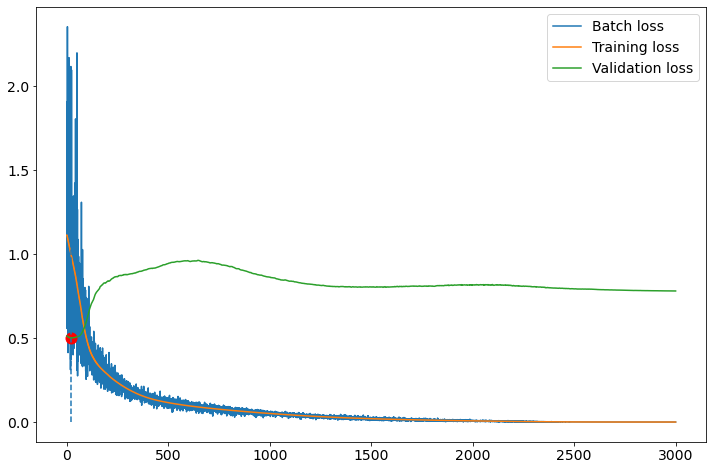

Fold 4:
  Train: index=[ 0  1  2  3  4  5  7  8  9 10 11 12 14 16 17]
  Test:  index=[ 6 13 15]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.573714   1.041854   0.704231     0.704231(0)   0.000500
       100        300   0.300542   0.550997   0.617643     0.617643(99)   0.000500
       200        600   0.349377   0.245482   0.685470     0.605237(130)   0.000500
       300        900   0.127421   0.156791   0.769798     0.605237(130)   0.000500
       400       1200   0.115980   0.120479   0.774591     0.605237(130)   0.000500
       500       1500   0.137640   0.098135   0.761412     0.605237(130)   0.000500
       600       1800   0.069243   0.080773   0.748201     0.605237(130)   0.000500
       700       2100   0.060331   0.067904   0.750383     0.605237(130)   0.000500
       800       2400   0.052045   0.057613   0.757088     0.605237(130)   0.000500
       900       2700   0.063219   0.048466   0.767689     0.605237(1

<Figure size 432x288 with 0 Axes>

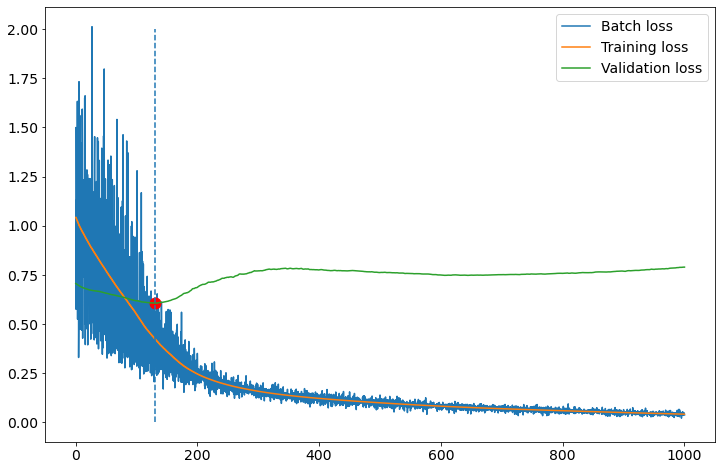

      1100       3300   0.034255   0.032146   0.816890     0.605237(130)   0.000500
      1200       3600   0.024016   0.024874   0.844132     0.605237(130)   0.000500
      1300       3900   0.014404   0.018712   0.887643     0.605237(130)   0.000500
      1400       4200   0.018400   0.013540   0.927087     0.605237(130)   0.000500
      1500       4500   0.006731   0.009423   0.955223     0.605237(130)   0.000500
      1600       4800   0.005522   0.006252   0.978458     0.605237(130)   0.000500
      1700       5100   0.003491   0.003938   0.998949     0.605237(130)   0.000500
      1800       5400   0.002168   0.002351   1.016748     0.605237(130)   0.000500
      1900       5700   0.000348   0.001331   1.029475     0.605237(130)   0.000500
      2000       6000   0.000813   0.000717   1.042226     0.605237(130)   0.000500


<Figure size 432x288 with 0 Axes>

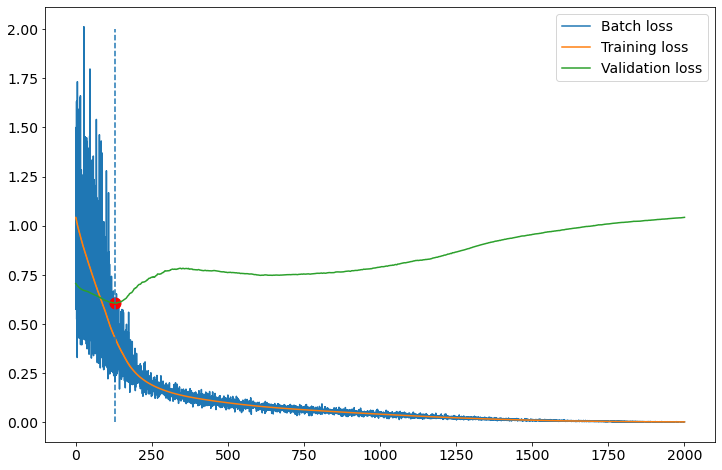

      2100       6300   0.000224   0.000368   1.050860     0.605237(130)   0.000500
      2200       6600   0.000091   0.000176   1.058083     0.605237(130)   0.000500
      2300       6900   0.000041   0.000080   1.063294     0.605237(130)   0.000500
      2400       7200   0.000045   0.000033   1.065654     0.605237(130)   0.000500
      2500       7500   0.000009   0.000012   1.066456     0.605237(130)   0.000500
      2600       7800   0.000009   0.000004   1.066807     0.605237(130)   0.000500
      2700       8100   0.000001   0.000001   1.066778     0.605237(130)   0.000500
      2800       8400   0.000000   0.000000   1.066771     0.605237(130)   0.000500
      2900       8700   0.000000   0.000000   1.066638     0.605237(130)   0.000500
      3000       9000   0.000000   0.000000   1.065852     0.605237(130)   0.000500


<Figure size 432x288 with 0 Axes>

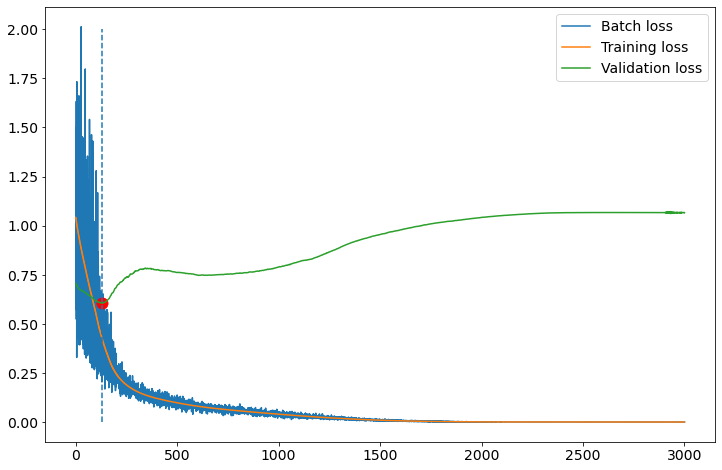

999
Fold 0:
  Train: index=[ 0  1  2  3  5  6  7  8  9 11 12 15 16 17]
  Test:  index=[ 4 10 13 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.003019   1.050079   0.604596     0.603453(0)   0.000500
       100        300   0.354453   0.490664   0.449519     0.449427(99)   0.000500
       200        600   0.188824   0.253858   0.446620     0.434644(142)   0.000500
       300        900   0.118010   0.155954   0.451553     0.434644(142)   0.000500
       400       1200   0.081769   0.101833   0.461527     0.434644(142)   0.000500
       500       1500   0.076961   0.071487   0.482103     0.434644(142)   0.000500
       600       1800   0.059438   0.054314   0.509312     0.434644(142)   0.000500
       700       2100   0.036258   0.043907   0.532820     0.434644(142)   0.000500
       800       2400   0.029252   0.036756   0.557947     0.434644(142)   0.000500
       900       2700   0.040616   0.031186   0.579597     0.4346

<Figure size 432x288 with 0 Axes>

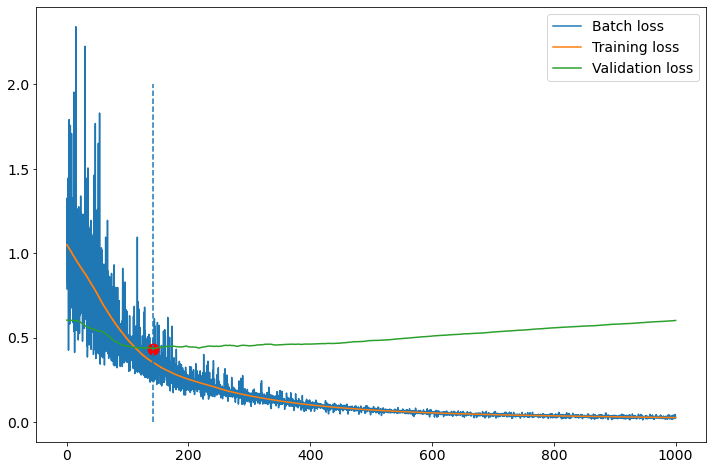

      1100       3300   0.023061   0.021542   0.619134     0.434644(142)   0.000500
      1200       3600   0.015631   0.016917   0.627848     0.434644(142)   0.000500
      1300       3900   0.014274   0.012533   0.634695     0.434644(142)   0.000500
      1400       4200   0.003909   0.008729   0.648138     0.434644(142)   0.000500
      1500       4500   0.006795   0.005675   0.660219     0.434644(142)   0.000500
      1600       4800   0.002541   0.003409   0.669579     0.434644(142)   0.000500
      1700       5100   0.001917   0.001894   0.680988     0.434644(142)   0.000500
      1800       5400   0.001046   0.000976   0.690646     0.434644(142)   0.000500
      1900       5700   0.000705   0.000466   0.700728     0.434644(142)   0.000500
      2000       6000   0.000160   0.000206   0.710214     0.434644(142)   0.000500


<Figure size 432x288 with 0 Axes>

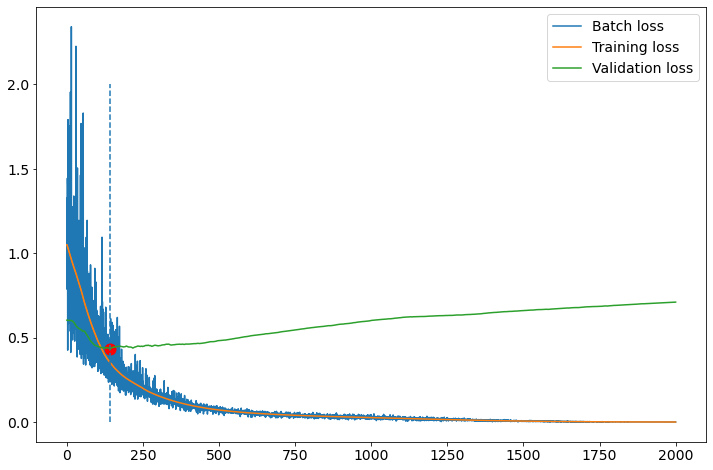

      2100       6300   0.000073   0.000085   0.716816     0.434644(142)   0.000500
      2200       6600   0.000018   0.000033   0.720543     0.434644(142)   0.000500
      2300       6900   0.000011   0.000011   0.722142     0.434644(142)   0.000500
      2400       7200   0.000002   0.000003   0.723146     0.434644(142)   0.000500
      2500       7500   0.000002   0.000001   0.723715     0.434644(142)   0.000500
      2600       7800   0.000000   0.000000   0.723964     0.434644(142)   0.000500
      2700       8100   0.000000   0.000000   0.724096     0.434644(142)   0.000500
      2800       8400   0.000000   0.000000   0.724143     0.434644(142)   0.000500
      2900       8700   0.000000   0.000000   0.724091     0.434644(142)   0.000500
      3000       9000   0.000347   0.000054   0.722759     0.434644(142)   0.000500


<Figure size 432x288 with 0 Axes>

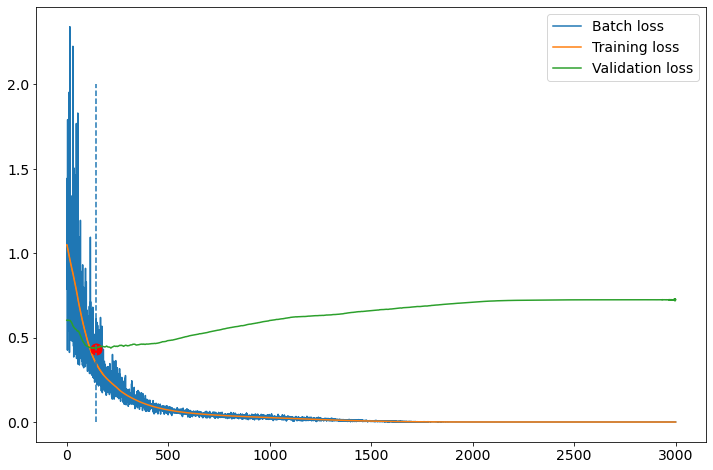

Fold 1:
  Train: index=[ 0  1  3  4  5  8  9 10 11 13 14 15 16 17]
  Test:  index=[ 2  6  7 12]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.619983   1.008880   1.179738     1.179738(0)   0.000500
       100        300   0.304450   0.500945   0.952992     0.952992(99)   0.000500
       200        600   0.245946   0.240614   0.893134     0.890084(180)   0.000500
       300        900   0.174968   0.161058   0.902587     0.890084(180)   0.000500
       400       1200   0.090291   0.120652   0.910291     0.890084(180)   0.000500
       500       1500   0.109739   0.096172   0.909859     0.890084(180)   0.000500
       600       1800   0.069068   0.078817   0.906009     0.890084(180)   0.000500
       700       2100   0.056246   0.065207   0.906634     0.890084(180)   0.000500
       800       2400   0.064520   0.053829   0.906459     0.890084(180)   0.000500
       900       2700   0.035304   0.043788   0.904677     0.890084(1

<Figure size 432x288 with 0 Axes>

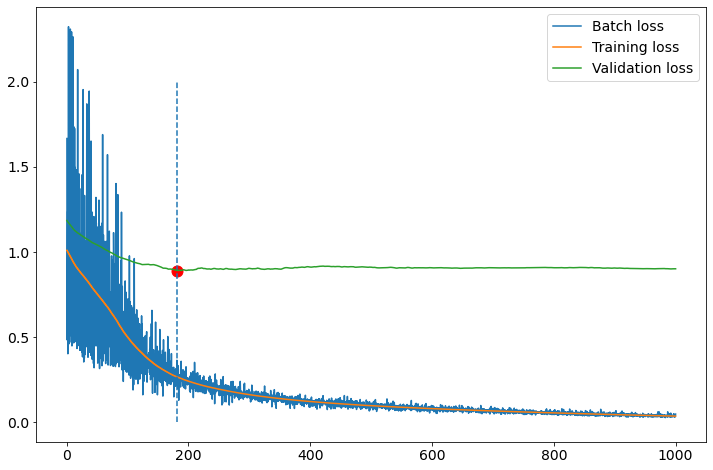

      1100       3300   0.013782   0.027075   0.897481     0.890084(180)   0.000500
      1200       3600   0.018401   0.020377   0.899653     0.890084(180)   0.000500
      1300       3900   0.013835   0.014948   0.903346     0.890084(180)   0.000500
      1400       4200   0.012714   0.010590   0.908048     0.890084(180)   0.000500
      1500       4500   0.008754   0.007250   0.914467     0.890084(180)   0.000500
      1600       4800   0.003995   0.004705   0.922344     0.890084(180)   0.000500
      1700       5100   0.000865   0.002869   0.932455     0.890084(180)   0.000500
      1800       5400   0.001149   0.001655   0.940908     0.890084(180)   0.000500
      1900       5700   0.000993   0.000877   0.948667     0.890084(180)   0.000500
      2000       6000   0.000576   0.000426   0.956659     0.890084(180)   0.000500


<Figure size 432x288 with 0 Axes>

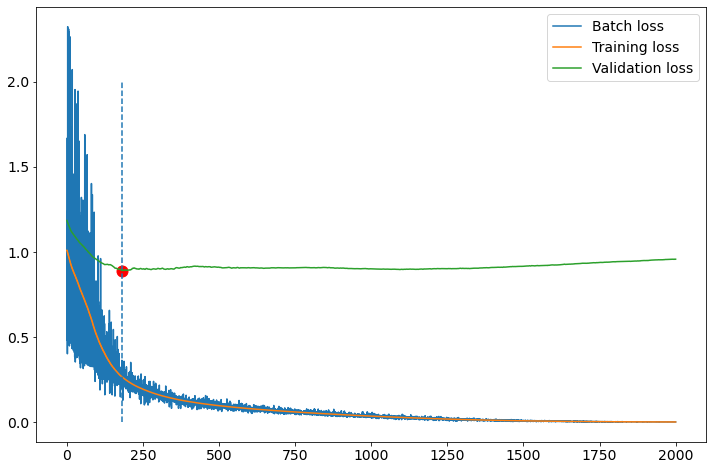

      2100       6300   0.000089   0.000189   0.963216     0.890084(180)   0.000500
      2200       6600   0.000041   0.000074   0.968241     0.890084(180)   0.000500
      2300       6900   0.000020   0.000025   0.971553     0.890084(180)   0.000500
      2400       7200   0.000008   0.000007   0.973515     0.890084(180)   0.000500
      2500       7500   0.000001   0.000002   0.974767     0.890084(180)   0.000500
      2600       7800   0.000001   0.000000   0.975377     0.890084(180)   0.000500
      2700       8100   0.000000   0.000000   0.975676     0.890084(180)   0.000500
      2800       8400   0.000000   0.000000   0.975855     0.890084(180)   0.000500
      2900       8700   0.000000   0.000000   0.975921     0.890084(180)   0.000500
      3000       9000   0.000000   0.000000   0.975944     0.890084(180)   0.000500


<Figure size 432x288 with 0 Axes>

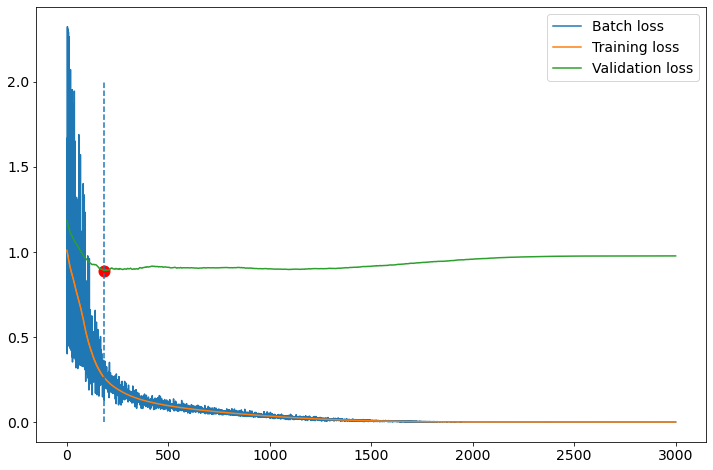

Fold 2:
  Train: index=[ 0  1  2  4  5  6  7  8 10 11 12 13 14 15]
  Test:  index=[ 3  9 16 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.833822   0.855831   1.204325     1.204325(0)   0.000500
       100        300   0.384515   0.469805   0.952098     0.952098(99)   0.000500
       200        600   0.203494   0.232238   0.735969     0.735969(199)   0.000500
       300        900   0.121150   0.152192   0.717816     0.716654(296)   0.000500
       400       1200   0.143075   0.112922   0.700966     0.700869(398)   0.000500
       500       1500   0.084793   0.087490   0.693883     0.693768(494)   0.000500
       600       1800   0.047398   0.069734   0.690410     0.689822(592)   0.000500
       700       2100   0.060539   0.056974   0.691954     0.689816(647)   0.000500
       800       2400   0.051383   0.047095   0.697391     0.689816(647)   0.000500
       900       2700   0.049289   0.038876   0.703454     0.689816(6

<Figure size 432x288 with 0 Axes>

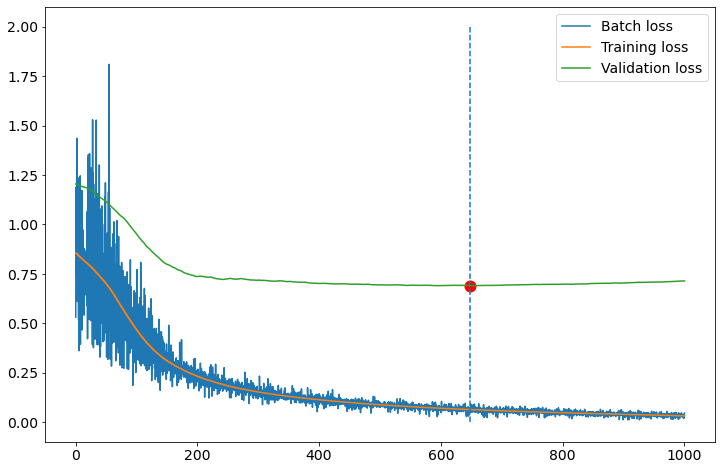

      1100       3300   0.025193   0.025020   0.726546     0.689816(647)   0.000500
      1200       3600   0.014533   0.019434   0.745869     0.689816(647)   0.000500
      1300       3900   0.010928   0.014795   0.765360     0.689816(647)   0.000500
      1400       4200   0.003702   0.010865   0.780269     0.689816(647)   0.000500
      1500       4500   0.008340   0.007573   0.795627     0.689816(647)   0.000500
      1600       4800   0.004287   0.004826   0.809972     0.689816(647)   0.000500
      1700       5100   0.002855   0.002810   0.824543     0.689816(647)   0.000500
      1800       5400   0.001968   0.001528   0.843363     0.689816(647)   0.000500
      1900       5700   0.000135   0.000810   0.859434     0.689816(647)   0.000500
      2000       6000   0.000715   0.000450   0.872071     0.689816(647)   0.000500


<Figure size 432x288 with 0 Axes>

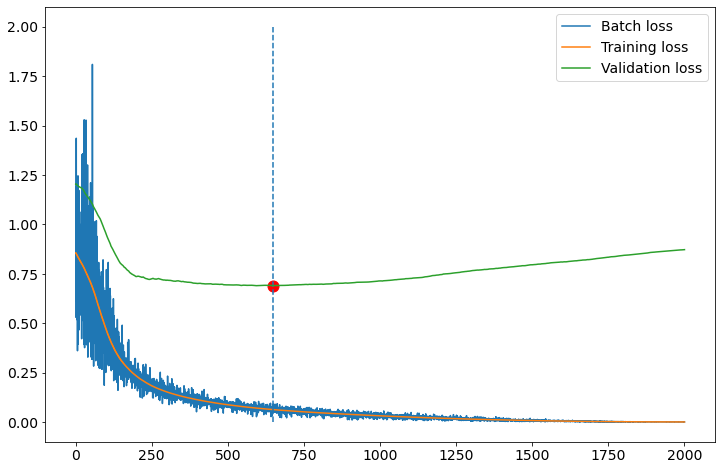

      2100       6300   0.000881   0.000297   0.879965     0.689816(647)   0.000500
      2200       6600   0.000325   0.000221   0.882867     0.689816(647)   0.000500
      2300       6900   0.000357   0.000186   0.883159     0.689816(647)   0.000500
      2400       7200   0.000473   0.000159   0.879667     0.689816(647)   0.000500
      2500       7500   0.000376   0.000135   0.873607     0.689816(647)   0.000500
      2600       7800   0.000342   0.000113   0.866635     0.689816(647)   0.000500
      2700       8100   0.000036   0.000088   0.860118     0.689816(647)   0.000500
      2800       8400   0.000083   0.000061   0.851553     0.689816(647)   0.000500
      2900       8700   0.000008   0.000041   0.843427     0.689816(647)   0.000500
      3000       9000   0.000015   0.000028   0.837217     0.689816(647)   0.000500


<Figure size 432x288 with 0 Axes>

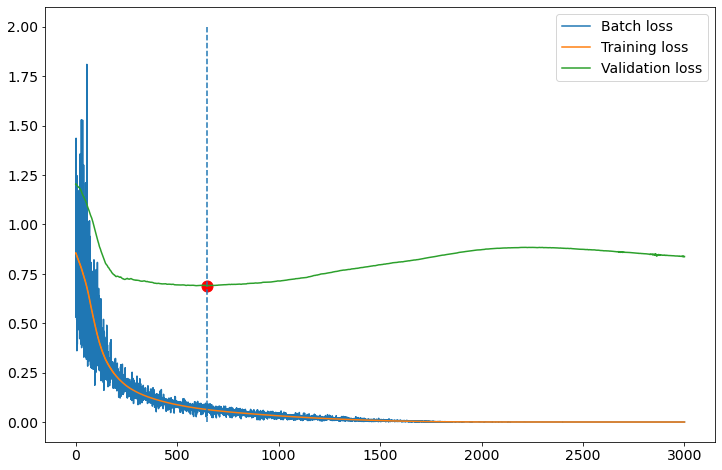

Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  9 10 12 13 14 16 17]
  Test:  index=[ 8 11 15]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.335188   0.924598   1.312523     1.312523(0)   0.000500
       100        300   0.264776   0.430983   1.069838     1.069838(99)   0.000500
       200        600   0.221880   0.228702   1.006987     1.001497(194)   0.000500
       300        900   0.125882   0.157490   1.007200     0.996904(243)   0.000500
       400       1200   0.107442   0.117077   1.020712     0.996904(243)   0.000500
       500       1500   0.073793   0.091886   1.017656     0.996904(243)   0.000500
       600       1800   0.070340   0.074223   1.031373     0.996904(243)   0.000500
       700       2100   0.065229   0.060524   1.049113     0.996904(243)   0.000500
       800       2400   0.037505   0.049944   1.074062     0.996904(243)   0.000500
       900       2700   0.034050   0.041909   1.082813     0.996904(2

<Figure size 432x288 with 0 Axes>

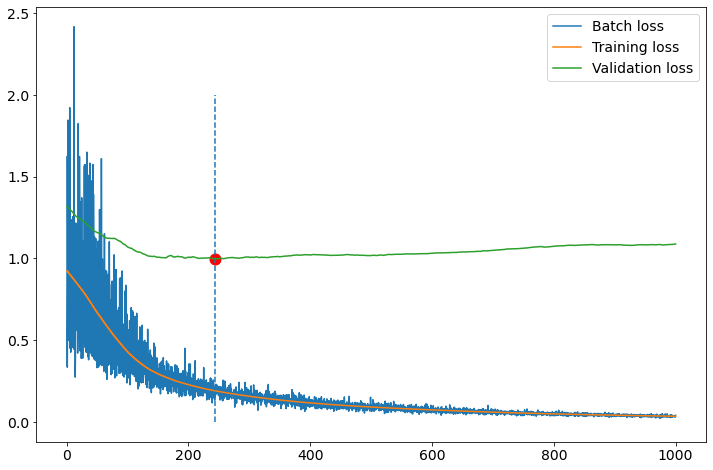

      1100       3300   0.030804   0.030098   1.096715     0.996904(243)   0.000500
      1200       3600   0.026100   0.025826   1.110054     0.996904(243)   0.000500
      1300       3900   0.023531   0.022414   1.122814     0.996904(243)   0.000500
      1400       4200   0.018483   0.019647   1.142048     0.996904(243)   0.000500
      1500       4500   0.007814   0.017387   1.158674     0.996904(243)   0.000500
      1600       4800   0.020933   0.015516   1.180237     0.996904(243)   0.000500
      1700       5100   0.012973   0.013747   1.197335     0.996904(243)   0.000500
      1800       5400   0.011646   0.011908   1.217750     0.996904(243)   0.000500
      1900       5700   0.007473   0.009873   1.237608     0.996904(243)   0.000500
      2000       6000   0.009339   0.007697   1.259058     0.996904(243)   0.000500


<Figure size 432x288 with 0 Axes>

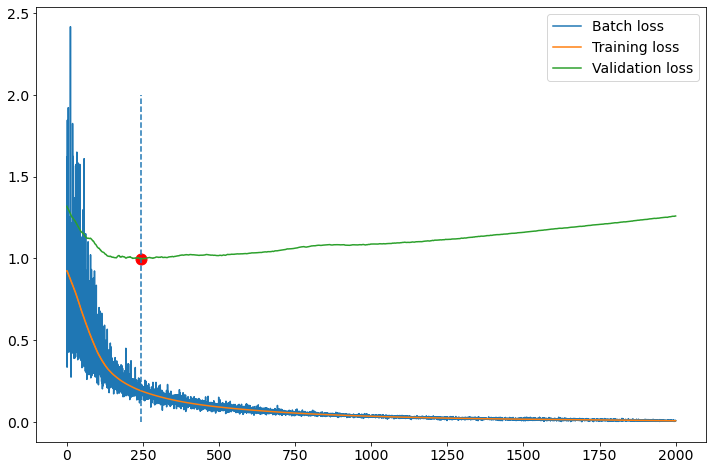

      2100       6300   0.005800   0.005588   1.287647     0.996904(243)   0.000500
      2200       6600   0.004388   0.003760   1.322516     0.996904(243)   0.000500
      2300       6900   0.002168   0.002356   1.354512     0.996904(243)   0.000500
      2400       7200   0.000389   0.001395   1.380328     0.996904(243)   0.000500
      2500       7500   0.000484   0.000780   1.405518     0.996904(243)   0.000500
      2600       7800   0.000339   0.000407   1.428303     0.996904(243)   0.000500
      2700       8100   0.000356   0.000194   1.444271     0.996904(243)   0.000500
      2800       8400   0.000025   0.000081   1.457762     0.996904(243)   0.000500
      2900       8700   0.000019   0.000030   1.465870     0.996904(243)   0.000500
      3000       9000   0.000005   0.000010   1.470393     0.996904(243)   0.000500


<Figure size 432x288 with 0 Axes>

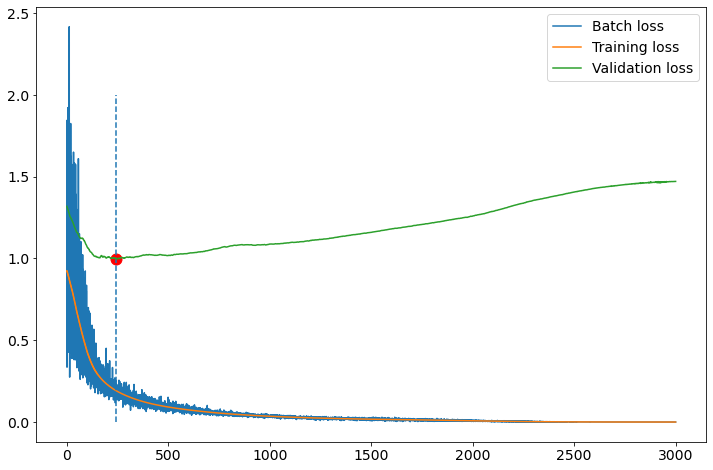

Fold 4:
  Train: index=[ 2  3  4  6  7  8  9 10 11 12 13 14 15 16 17]
  Test:  index=[0 1 5]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.487737   1.007526   0.512077     0.510980(0)   0.000500
       100        300   0.320936   0.424968   0.474496     0.455712(75)   0.000500
       200        600   0.261072   0.238289   0.606569     0.455712(75)   0.000500
       300        900   0.174157   0.152433   0.703854     0.455712(75)   0.000500
       400       1200   0.089954   0.113329   0.749702     0.455712(75)   0.000500
       500       1500   0.099850   0.091312   0.776933     0.455712(75)   0.000500
       600       1800   0.071264   0.076150   0.797687     0.455712(75)   0.000500
       700       2100   0.074372   0.064979   0.804087     0.455712(75)   0.000500
       800       2400   0.071777   0.056132   0.801882     0.455712(75)   0.000500
       900       2700   0.051281   0.048633   0.800472     0.455712(75)   0.000

<Figure size 432x288 with 0 Axes>

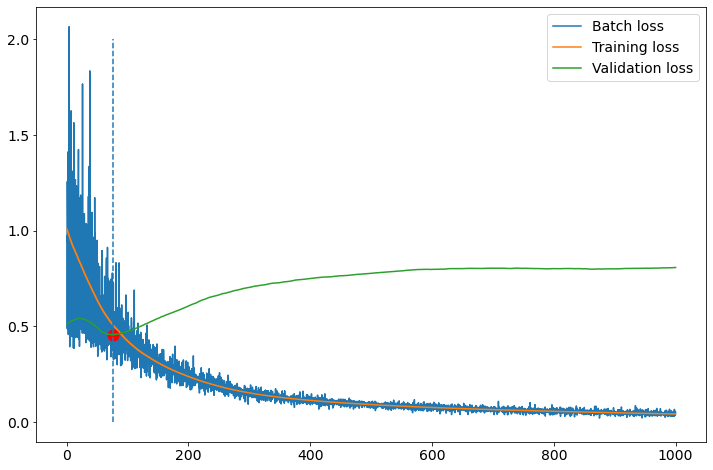

      1100       3300   0.057737   0.036209   0.807421     0.455712(75)   0.000500
      1200       3600   0.032083   0.030967   0.801941     0.455712(75)   0.000500
      1300       3900   0.020134   0.026348   0.797740     0.455712(75)   0.000500
      1400       4200   0.020391   0.021964   0.792276     0.455712(75)   0.000500
      1500       4500   0.028487   0.017690   0.784989     0.455712(75)   0.000500
      1600       4800   0.007550   0.013660   0.790702     0.455712(75)   0.000500
      1700       5100   0.006330   0.010024   0.798454     0.455712(75)   0.000500
      1800       5400   0.009098   0.006862   0.809879     0.455712(75)   0.000500
      1900       5700   0.004693   0.004360   0.825025     0.455712(75)   0.000500
      2000       6000   0.003809   0.002556   0.840470     0.455712(75)   0.000500


<Figure size 432x288 with 0 Axes>

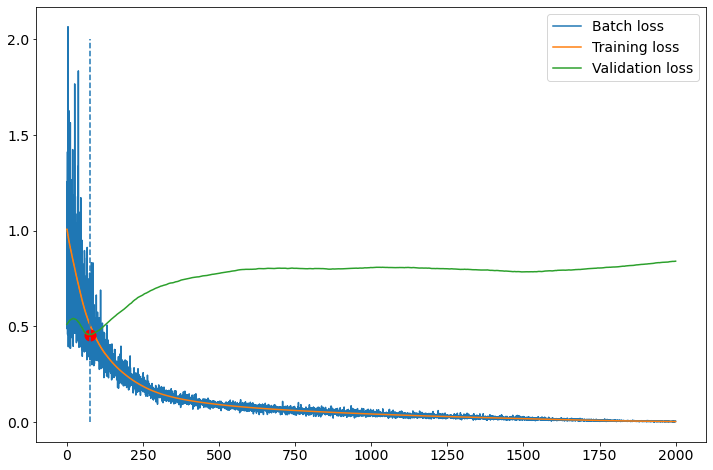

      2100       6300   0.001005   0.001395   0.846305     0.455712(75)   0.000500
      2200       6600   0.000485   0.000696   0.850832     0.455712(75)   0.000500
      2300       6900   0.000386   0.000311   0.853822     0.455712(75)   0.000500
      2400       7200   0.000192   0.000119   0.855940     0.455712(75)   0.000500
      2500       7500   0.000025   0.000039   0.856658     0.455712(75)   0.000500
      2600       7800   0.000009   0.000011   0.856471     0.455712(75)   0.000500
      2700       8100   0.000001   0.000002   0.856206     0.455712(75)   0.000500
      2800       8400   0.000000   0.000000   0.855967     0.455712(75)   0.000500
      2900       8700   0.000000   0.000000   0.855872     0.455712(75)   0.000500
      3000       9000   0.000000   0.000000   0.855831     0.455712(75)   0.000500


<Figure size 432x288 with 0 Axes>

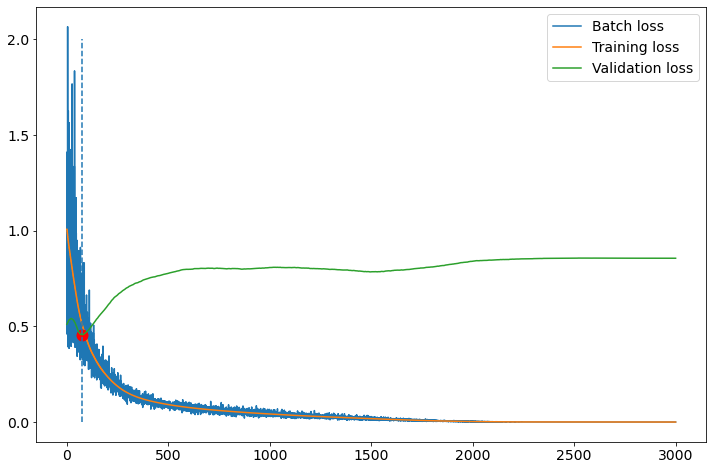

<Figure size 432x288 with 0 Axes>

In [17]:
# Neural Network
kl_surrogate['NN'] = list()
for random_seed in random_seeds:
    print(random_seed)
    kl_surrogate['NN'].append(
        make_nn_surrogate_model(
            train_x.values, klxi_train,
            cv='KFold',
            #cv='LOO',
            #test_X=test_x.values, test_Y=klxi_test,
            num_hidden_layers=hidden_layers,
            lrate=learn_rate,
            batch_size=batch_size,
            nepochs=nepochs,
            seed=random_seed,
            eigenratio=eigenratio,
        )
    )

poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,

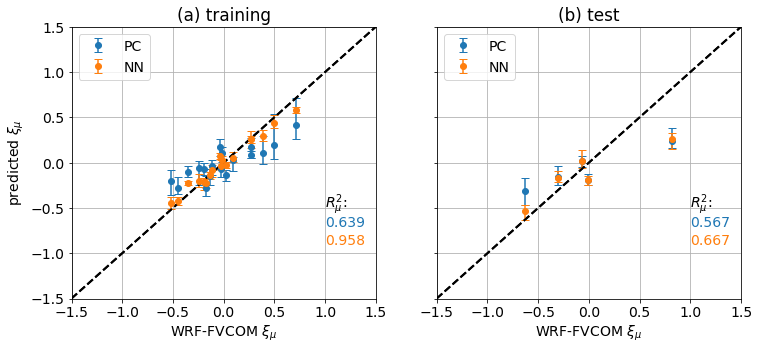

In [18]:
# Checking PC and NN accuracy for sqrt(eigenvalue)-weighted combined
rmse_v = 2
r2_v = -0.5
bnds = 1.5

fig, axs = plt.subplots(1, 2,sharey=True,figsize=(12,5))

for ii in [0,1]:
    
    if ii == 0:
        comparison = '(a) training'
        klxi_model = klxi_train
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,train_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],train_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,train_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
        #zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,train_x.values)
        #klxi_pred = klxi_pred / n_folds
    else:
        comparison = '(b) test'
        
        klxi_model = klxi_test
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,test_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],test_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,test_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        #klxi_pred = zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,test_x.values)
        #klxi_pred = klxi_pred / n_folds
        
    #klxi_pred0 = klxi_preds0.mean(axis=0)
    #klxi_errorbars0 = abs(stack((klxi_preds0.min(axis=0),klxi_preds0.max(axis=0))) - klxi_pred0)
    #klxi_pred = klxi_preds.mean(axis=0)
    #klxi_errorbars = abs(stack((klxi_preds.min(axis=0),klxi_preds.max(axis=0))) - klxi_pred)
    
    model_w = (sqrt(eigenvalues)*klxi_model).sum(axis=1)/sqrt(eigenvalues).sum()
    pred_w = {'NN':  zeros(klxi_preds[:,:,0].shape),
              'PC':  zeros(klxi_preds0[:,:,0].shape)}
    for ss,klxi_pred in enumerate(klxi_preds):
        pred_w['NN'][ss,:] = (sqrt(eigenvalues)*klxi_pred).sum(axis=1)/sqrt(eigenvalues).sum()
    for ss,klxi_pred0 in enumerate(klxi_preds0):
        pred_w['PC'][ss,:] = (sqrt(eigenvalues)*klxi_pred0).sum(axis=1)/sqrt(eigenvalues).sum()
    
    axs[ii].text(bnds-0.5,r2_v,'$R^2_\mu$:')
    for st,surrogate_type in enumerate(['PC','NN']):
        pred_wm = pred_w[surrogate_type].mean(axis=0)
        pred_werror = abs(stack((pred_w[surrogate_type].min(axis=0),
                                 pred_w[surrogate_type].max(axis=0))) - pred_wm)
        py = axs[ii].errorbar(model_w, pred_wm,
                              yerr=pred_werror,
                              fmt='o',
                              capsize=4,
                              label=surrogate_type)
        u = ((model_w - pred_wm)**2).sum()
        v = ((model_w - model_w.mean())**2).sum()
        r2 = 1 - u/v
        axs[ii].text(bnds-0.5,r2_v-(1+st)*0.2,str(round(r2,3)),color=py[0].get_color())
        axs[ii].plot([-bnds,bnds], [-bnds,bnds], 'k--', lw=2)
    axs[ii].set_xlabel(r'WRF-FVCOM $\xi_\mu$')
    if ii == 0:
        axs[ii].set_ylabel(r'predicted $\xi_\mu$')
    axs[ii].set_xlim([-bnds,bnds])
    axs[ii].set_ylim([-bnds,bnds])
    axs[ii].set_title(f'{comparison}')
    axs[ii].legend(loc='upper left')
    axs[ii].grid()
plt.show()

## Global Sensitivity Analysis

In [19]:
total_var_sens = {'PC': {'main': [], 'total': []}, 'NN': {'main': [], 'total': []}}
ew_range = {'PC': [], 'NN': []}

### GSA on PC model

In [20]:
# get the sensitivity for the PC surrogate
for ss, sur in enumerate(kl_surrogate['PC']):
    sens_eig_sobol, pc_range = compute_sensitivities(sur, train_x, sample_size=10000)
    if ss == 0:
        ew_range['PC'] = (sqrt(eigenvalues)*pc_range).sum(axis=1)/sqrt(eigenvalues).sum()
    else:
        ew_range['PC'] = append(ew_range['PC'],(sqrt(eigenvalues)*pc_range).sum(axis=1)/sqrt(eigenvalues).sum())
    
    for sens_label in ['main','total']:
        portion_of_eigen_explain = sens_eig_sobol[sens_label] #/sens_eig_sobol[sens_label].sum(axis=1).reshape(-1,1)
        portion_of_eigen_explain[isnan(portion_of_eigen_explain)] = 0
        total_var_sens_temp = (portion_of_eigen_explain * eigenratio.reshape(-1,1)).sum(axis=0)
        if ss == 0:
            total_var_sens['PC'][sens_label] = total_var_sens_temp[None,:]
        else:
            total_var_sens['PC'][sens_label] = append(total_var_sens['PC'][sens_label],
                                                      total_var_sens_temp[None,:],axis=0)

Initializing SOBOL
Sampling SOBOL


poly shape: (16,)
parameter common shape: (220000,)
output shape: (16, 220000)
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value en

Initializing SOBOL
Sampling SOBOL


/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringl

Initializing SOBOL
Sampling SOBOL


poly shape: (16,)
parameter common shape: (220000,)
output shape: (16, 220000)
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value en

Initializing SOBOL
Sampling SOBOL


/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringl

Initializing SOBOL
Sampling SOBOL


/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringl

Initializing SOBOL
Sampling SOBOL


poly shape: (16,)
parameter common shape: (220000,)
output shape: (16, 220000)
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value en

Initializing SOBOL
Sampling SOBOL


/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringl

Initializing SOBOL
Sampling SOBOL


/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringl

Initializing SOBOL
Sampling SOBOL


/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:94: RuntimeWarning: invalid value encountered in double_scalars
  jtij[id, jd] = ti[id] + ti[jd] - 0.5 * mean(y3 * y3) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:87: RuntimeWarning: invalid value encountered in double_scalars
  si[id] = mean(y1 * y2) / yvar
/home/wpringle/GLM_Analysis/WRF+FVCOM_UQ/GreatLakes_CoupledModelUQ/workflow/surrogate/gsa.py:88: RuntimeWarning: invalid value encountered in double_scalars
  ti[id] = 0.5 * mean(y2 * y2) / yvar
/home/wpringl

### GSA on NN model

In [21]:
# get the sensitivity for the NN surrogate
for ss, sur in enumerate(kl_surrogate['NN']):
    sens_eig_sobol, nn_range = compute_sensitivities(sur, train_x, sample_size=10000)
    if ss == 0:
        ew_range['NN'] = (sqrt(eigenvalues)*nn_range).sum(axis=1)/sqrt(eigenvalues).sum()
    else:
        ew_range['NN'] = append(ew_range['NN'],(sqrt(eigenvalues)*nn_range).sum(axis=1)/sqrt(eigenvalues).sum())

    for sens_label in ['main','total']:
        portion_of_eigen_explain = sens_eig_sobol[sens_label] #/sens_eig_sobol[sens_label].sum(axis=1).reshape(-1,1)
        portion_of_eigen_explain[isnan(portion_of_eigen_explain)] = 0
        total_var_sens_temp = (portion_of_eigen_explain * eigenratio.reshape(-1,1)).sum(axis=0)
        if ss == 0:
            total_var_sens['NN'][sens_label] = total_var_sens_temp[None,:]
        else:
            total_var_sens['NN'][sens_label] = append(total_var_sens['NN'][sens_label],
                                                      total_var_sens_temp[None,:],axis=0)

Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL


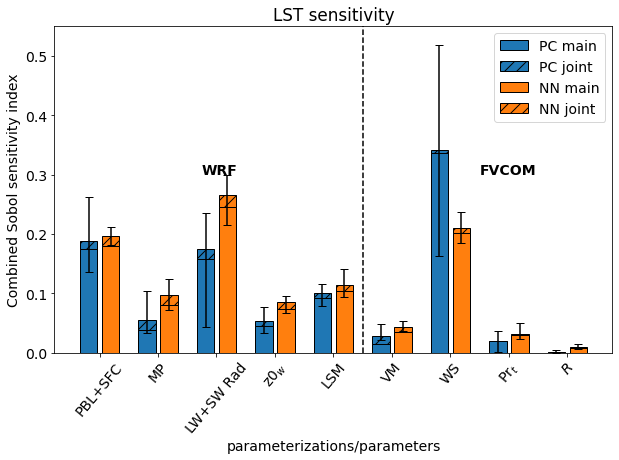

In [22]:
# Plot overall sensitivities by param

# note: make different surrogate models (e.g., different CV and regression for PC 
# and different seed for NN and add error bars to plots)

pname_paper = ['PBL+SFC', 'MP', 'LW+SW Rad', 'z0$_w$', 'LSM', 
               'VM', 'WS', 'Pr$_t$', '$R$']
case_labels = ['main', 'joint']
cases_hatch = [None,'//']
cases_color = ['#1f77b4', '#ff7f0e']
fig = plt.figure(figsize=(10, 6))
ind=arange(1, len(variables)+1)
width = 0.3
cases = [0,1]
for st,surrogate_type in enumerate(['PC','NN']):
    total_var_sens_main = total_var_sens[surrogate_type]['main'].mean(axis=0).reshape(1,-1)
    total_var_sens_total = total_var_sens[surrogate_type]['total'].mean(axis=0).reshape(1,-1)
    sensdata = append(total_var_sens_main,
                     total_var_sens_total-total_var_sens_main,
                     axis=0).transpose()
    errordata = append((total_var_sens_total 
                        - total_var_sens[surrogate_type]['total'].min(axis=0).reshape(1,-1)),
                       (total_var_sens[surrogate_type]['total'].max(axis=0).reshape(1,-1)
                        - total_var_sens_total),axis=0)
    curr = zeros(len(variables))
    for i in cases:
        plt.bar(ind+1.25*(st-0.5)*width,
                sensdata[:, i],
                width=width,
                color=cases_color[st],
                edgecolor='black',
                hatch=cases_hatch[i],
                bottom=curr,
                label=surrogate_type + ' ' + case_labels[i],
        )
        curr += sensdata[:, i]
    plt.errorbar(ind+1.25*(st-0.5)*width,
                 curr,
                 yerr=errordata,
                 fmt=' ',
                 capsize=4,
                 ecolor='k',
    )
plt.plot([5.5,5.5],[0,0.55],'k--')
plt.text(2.75,0.3,'WRF',fontweight='extra bold')
plt.text(7.5,0.3,'FVCOM',fontweight='extra bold')
plt.xticks(ind, pname_paper, rotation=50)
#plt.grid()
plt.ylim([0,0.55])
plt.ylabel('Combined Sobol sensitivity index')
plt.xlabel('parameterizations/parameters')
plt.title('LST sensitivity')
plt.legend()
plt.show()   
    #print(total_var_sens[surrogate_type]['total'])
    #plot_sens(append(total_var_sens[surrogate_type]['main'].reshape(1,-1),
    #                 (total_var_sens[surrogate_type]['total']-total_var_sens[surrogate_type]['main']).reshape(1,-1),
    #                 axis=0
    #                ),
    #          range(len(variables)),[0,1],vis="bar",reverse=True,
    #          par_labels=pname_paper,
    #          case_labels=case_labels,
    #          colors=[],ncol=5,grid_show=False,
    #          xlbl='parameterizations/parameters',ylbl='sensitivity',ylim_max=0.5,
    #          legend_show=1,legend_size=25,maxlegendcol=1,
    #          xdatatick=[], # = arange(1, len(variables)+1),
    #          showplot=True, topsens=[], lbl_size=25, yoffset=0.01, senssort=False,
    #          title='overall eigenmode sensitivities', xticklabel_size=22, xticklabel_rotation=50) 

poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (18,)
output shape: (16, 18)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,)
parameter common shape: (5,)
output shape: (16, 5)
poly shape: (16,

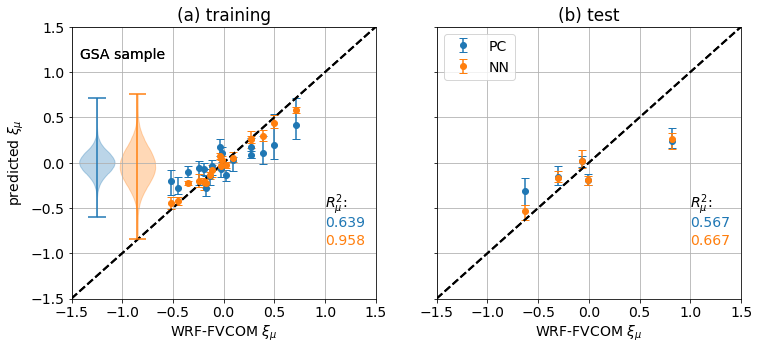

In [23]:
# Checking PC and NN accuracy for sqrt(eigenvalue)-weighted combined including the range
rmse_v = 2
r2_v = -0.5
bnds = 1.5

cases_color = ['#1f77b4', '#ff7f0e']

fig, axs = plt.subplots(1, 2,sharey=True,figsize=(12,5))

for ii in [0,1]:
    
    if ii == 0:
        comparison = '(a) training'
        klxi_model = klxi_train
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,train_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],train_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,train_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
        #zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,train_x.values)
        #klxi_pred = klxi_pred / n_folds
        
    else:
        comparison = '(b) test'
        
        klxi_model = klxi_test
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,test_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],test_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,test_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        #klxi_pred = zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,test_x.values)
        #klxi_pred = klxi_pred / n_folds
        
    #klxi_pred0 = klxi_preds0.mean(axis=0)
    #klxi_errorbars0 = abs(stack((klxi_preds0.min(axis=0),klxi_preds0.max(axis=0))) - klxi_pred0)
    #klxi_pred = klxi_preds.mean(axis=0)
    #klxi_errorbars = abs(stack((klxi_preds.min(axis=0),klxi_preds.max(axis=0))) - klxi_pred)
    
    model_w = (sqrt(eigenvalues)*klxi_model).sum(axis=1)/sqrt(eigenvalues).sum()
    pred_w = {'NN':  zeros(klxi_preds[:,:,0].shape),
              'PC':  zeros(klxi_preds0[:,:,0].shape)}
    for ss,klxi_pred in enumerate(klxi_preds):
        pred_w['NN'][ss,:] = (sqrt(eigenvalues)*klxi_pred).sum(axis=1)/sqrt(eigenvalues).sum()
    for ss,klxi_pred0 in enumerate(klxi_preds0):
        pred_w['PC'][ss,:] = (sqrt(eigenvalues)*klxi_pred0).sum(axis=1)/sqrt(eigenvalues).sum()
    
    axs[ii].text(bnds-0.5,r2_v,'$R^2_\mu$:')
    for st,surrogate_type in enumerate(['PC','NN']):
        pred_wm = pred_w[surrogate_type].mean(axis=0)
        pred_werror = abs(stack((pred_w[surrogate_type].min(axis=0),
                                 pred_w[surrogate_type].max(axis=0))) - pred_wm)
        axs[ii].errorbar(model_w, pred_wm,
                        yerr=pred_werror,
                        fmt='o',
                        capsize=4,
                        label=surrogate_type,
                        color=cases_color[st])
        u = ((model_w - pred_wm)**2).sum()
        v = ((model_w - model_w.mean())**2).sum()
        r2 = 1 - u/v
        axs[ii].text(bnds-0.5,r2_v-(1+st)*0.2,str(round(r2,3)),color=cases_color[st])
        axs[ii].plot([-bnds,bnds], [-bnds,bnds], 'k--', lw=2)
        if ii == 0:
            axs[ii].text(-1,1.15,'GSA sample',horizontalalignment='center')
            vp = axs[ii].violinplot(ew_range[surrogate_type], positions=[-1.25+st*0.4],widths=0.35)
            for part_name in vp:
                vpp = vp[part_name]
                if part_name == 'bodies':
                    for vppp in vpp:
                        vppp.set_facecolor(cases_color[st])
                        vppp.set_edgecolor(cases_color[st])
                else:
                    vpp.set_edgecolor(cases_color[st])
            #axs[ii].errorbar(,st,yerr=array([0.1,0.1]).reshape(-1,1),
            #            fmt='+',capsize=4,color=py[0].get_color())
            
    axs[ii].set_xlabel(r'WRF-FVCOM $\xi_\mu$')
    if ii == 0:
        axs[ii].set_ylabel(r'predicted $\xi_\mu$')
        
    axs[ii].set_xlim([-bnds,bnds])
    axs[ii].set_ylim([-bnds,bnds])
    axs[ii].set_title(f'{comparison}')
    if ii == 1:
        axs[ii].legend(loc='upper left')
    axs[ii].grid()
plt.show()

In [24]:
# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = mean_vector.reshape(ntime2,-1)
eigenmodes_reshape = eigenmodes.reshape(neig,ntime2,-1)

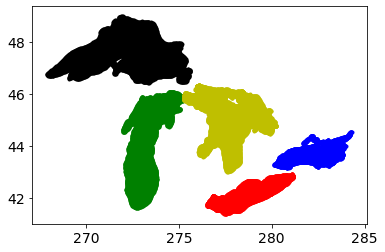

In [25]:
# get the mask for each Lake
lon = train_dict['LST'][0][1].lon.values
lat = train_dict['LST'][0][1].lat.values
superior = (lat > 46.2) & (lon < 275.9)
plt.plot(lon[superior],lat[superior],'k.')
erie = (lat < 43) & (lon > 275)
plt.plot(lon[erie],lat[erie],'r.')
ontario = (lat > 43) & (lat < 44.55) & (lon > 280)
plt.plot(lon[ontario],lat[ontario],'b.')
michigan = (lat < 46.25) & (lon < 275.25)
plt.plot(lon[michigan],lat[michigan],'g.')
huron = ~((michigan) | (superior) | (erie) | (ontario)) & (lon < 282)
plt.plot(lon[huron],lat[huron],'y.')

In [26]:
# get surrogate model for each lake (lake-wide mean)
lake_dict = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }
#surrogate_model_lake = []
#for lake in lake_dict:
#    print(lake)
#    coefficients_lake = get_combined_coefficients(
#        eigenmodes_reshape[:,:,lake_dict[lake]].mean(axis=2), 
#        mean_vector_reshape[:,lake_dict[lake]].mean(axis=1),
#    )
#    surrogate_model_lake.append(ndpoly.from_attributes(
#        exponents=pc_exponents, coefficients=coefficients_lake
#    )
#                               )

Superior
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Huron
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Michigan
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Ontario
Initializing SOBOL
Sampling SOBOL
Initializing SOB

(0.0, 30.0)

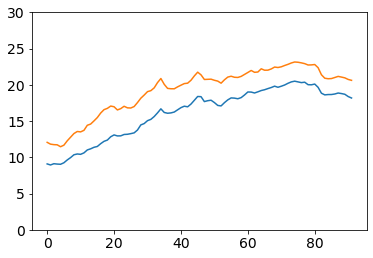

In [27]:
sens_sobol_lake = [None] * (len(lake_dict)+1)
nn_ens_min = [None] * (len(lake_dict)+1)
nn_ens_max = [None] * (len(lake_dict)+1)
for ldx,lake in enumerate(lake_dict):
    print(lake)
    # get the sensitivity for the PC surrogate
    kl_dict = {'eigenmodes': eigenmodes_reshape[:,:,lake_dict[lake]].mean(axis=2),
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape[:,lake_dict[lake]].mean(axis=1),
          }
    for ss, sur in enumerate(kl_surrogate['NN']):
        this_sens, values = compute_sensitivities(sur, train_x, sample_size=10000,
                                                     kl_dict=kl_dict)
        if ss == 0:
            sens_sobol_lake[ldx] = this_sens['total']
            nn_ens_min[ldx] = values.min(axis=0)
            nn_ens_max[ldx] = values.max(axis=0)
        else:
            sens_sobol_lake[ldx] += this_sens['total']
            nn_ens_min[ldx] = fmin(nn_ens_min[ldx],values.min(axis=0))
            nn_ens_max[ldx] = fmax(nn_ens_max[ldx],values.max(axis=0))

    sens_sobol_lake[ldx] = sens_sobol_lake[ldx]/len(kl_surrogate['NN'])
    
# overall
print('overall')
kl_dict = {'eigenmodes': eigenmodes_reshape.mean(axis=2), 
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape.mean(axis=1),
          }
for ss, sur in enumerate(kl_surrogate['NN']):
    this_sens, values = compute_sensitivities(sur, train_x, sample_size=10000,
                                                     kl_dict=kl_dict)
    if ss == 0:
        sens_sobol_lake[-1] = this_sens['total']
        nn_ens_min[-1] = values.min(axis=0)
        nn_ens_max[-1] = values.max(axis=0)
    else:
        sens_sobol_lake[-1] += this_sens['total']
        nn_ens_min[-1] = fmin(nn_ens_min[-1],values.min(axis=0))
        nn_ens_max[-1] = fmax(nn_ens_max[-1],values.max(axis=0))
        
sens_sobol_lake[-1] = sens_sobol_lake[-1]/len(kl_surrogate['NN'])

plt.plot(nn_ens_min[-1])
plt.plot(nn_ens_max[-1])
plt.ylim([0, 30])

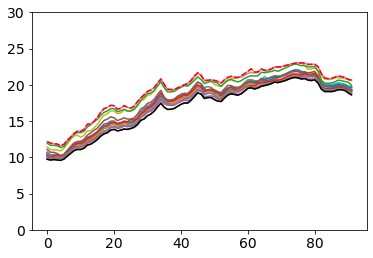

In [28]:
# get max min pf the model training data
ens_min = [None] * (len(lake_dict)+1)
ens_max = [None] * (len(lake_dict)+1)
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    value_temp = run[1].isel(time=tdx).mean(dim='node').values
    
    plt.plot(value_temp)
    plt.ylim([0, 30])
    
    if rdx == 0:
        ens_min[-1] = value_temp
        ens_max[-1] = value_temp
    else:
        ens_min[-1] = minimum(value_temp,ens_min[-1])
        ens_max[-1] = maximum(value_temp,ens_max[-1])
        
    for ldx, lake in enumerate(lake_dict):
        value_temp = run[1].isel(time=tdx,node=lake_dict[lake]).mean(dim='node').values
        if rdx == 0:
            ens_min[ldx] = value_temp
            ens_max[ldx] = value_temp
        else:
            ens_min[ldx] = minimum(value_temp,ens_min[ldx])
            ens_max[ldx] = maximum(value_temp,ens_max[ldx])

plt.plot(ens_min[-1],'k-')
plt.plot(ens_max[-1],'r--')

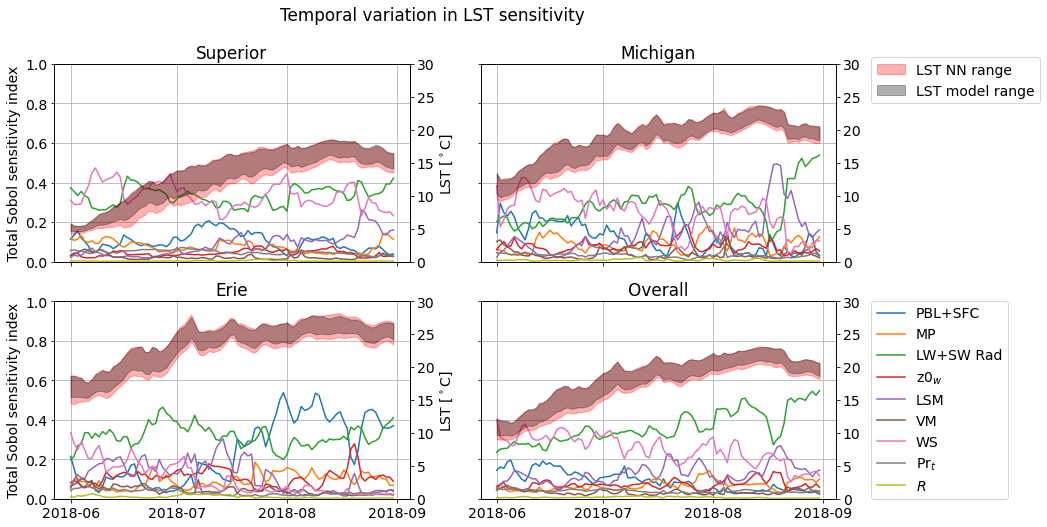

In [29]:
time = train_dict['LST'][0][0]
tdx = (time >= ts) & (time < te)
time = time[tdx]

#fig, axs = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(14,10))
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(14,8))
adx = 0
for ldx, lake in enumerate(lake_dict):
    if lake in ['Huron','Ontario']:
        continue
    ax = axs.flat[adx]
    for pdx,pname in enumerate(pname_paper):
        ax.plot(time,sens_sobol_lake[ldx][:,pdx],label=pname)

    ax.set_title(f'{lake}')
    ax.set_ylim([0,1.0])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.grid()
    
    ax2 = ax.twinx()
    ax2.fill_between(time,nn_ens_min[ldx],nn_ens_max[ldx],color='r',alpha=0.3,label='LST NN range')
    ax2.fill_between(time,ens_min[ldx],ens_max[ldx],color='k',alpha=0.3,label='LST model range')
    #ax2.fill_between(time,pc_ens_min[ldx],pc_ens_max[ldx],color='g',alpha=0.3,label='LST PC range')
    ax2.set_ylim([0,30])
    
    if adx == 2 or adx == 0:
        ax.set_ylabel('Total Sobol sensitivity index')
        ax2.set_ylabel('LST [$^\circ$C]')
    
    adx += 1
    
    #axs.flat[ldx].set_xticks(axs.flat[ldx].get_xticks(), rotation=50)
for pdx,pname in enumerate(pname_paper):
    axs.flat[-1].plot(time,sens_sobol_lake[-1][:,pdx],label=pname)

axs.flat[-1].legend(loc=(1.1,0))
    
ax2 = axs.flat[-1].twinx()
ax2.fill_between(time,nn_ens_min[-1],nn_ens_max[-1],color='r',alpha=0.3,label='LST NN range')
ax2.fill_between(time,ens_min[-1],ens_max[-1],color='k',alpha=0.3,label='LST model range')
#ax2.fill_between(time,pc_ens_min[-1],pc_ens_max[-1],color='g',alpha=0.3,label='LST PC range')
ax2.set_ylim([0,30])

ax2.legend(loc=(1.1,2))

axs.flat[-1].set_title('Overall')
axs.flat[-1].set_ylim([0,1.0])
axs.flat[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs.flat[-1].grid()
    
plt.suptitle('Temporal variation in LST sensitivity')

plt.show()

In [30]:
for ldx,lake in enumerate(lake_dict):
    print(lake)
    print((nn_ens_max[ldx] - nn_ens_min[ldx]).mean())
    

print('overall')
print((nn_ens_max[-1] - nn_ens_min[-1]).mean())

Superior
3.6662254575343525
Huron
3.414906697839638
Michigan
3.2787889380615685
Ontario
3.0868526587598253
Erie
3.5886850690255425
overall
3.092203029630931


In [34]:
point_array = range(0,lon.shape[0],4)
print(point_array)

range(0, 35749, 4)


In [35]:
# get sensitivity for NN surrogate
kl_dict = {'eigenmodes': eigenmodes_reshape.mean(axis=1)[:,point_array], 
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape.mean(axis=0)[point_array],
          }
for ss, sur in enumerate(kl_surrogate['NN']):
    this_sens, _ = compute_sensitivities(sur, train_x, sample_size=1000,
                                                     kl_dict=kl_dict)
    if ss == 0:
        sens_sobol_x_nn = this_sens['total']
    else:
        sens_sobol_x_nn += this_sens['total']
sens_sobol_x_nn = sens_sobol_x_nn/len(kl_surrogate['NN'])

Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL


In [36]:
# only choose top 6
#pnames_sel = append(pname_paper[0:5],pname_paper[6])
pnames_sel = array(pname_paper)[[0,2,4,6]]
print(pnames_sel)

['PBL+SFC' 'LW+SW Rad' 'LSM' 'WS']


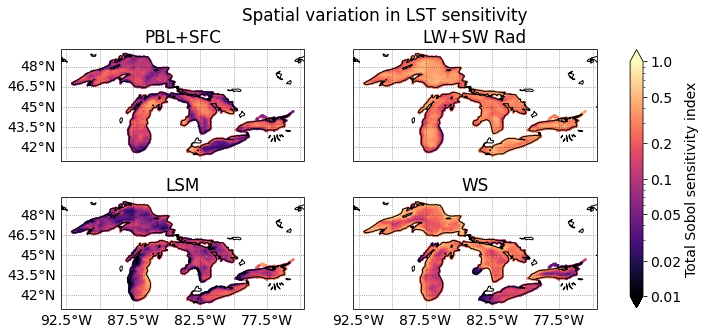

In [53]:
fig, axs = plt.subplots(2, #3, 
                        2, sharey=True, sharex=True, 
                        figsize=(12,5), #(14,10),
                       subplot_kw={'projection': PlateCarree()})
for adx,pname in enumerate(pnames_sel):

    ax = axs.flat[adx]

    # Download and add the states and coastlines
    coast = NaturalEarthFeature(
            category='physical',
            name='coastline',
            facecolor='none',
            scale='50m')
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)
    ax.add_feature(coast)
    
    pdx = pname_paper.index(pname)
    im = ax.scatter(train_dict['LST'][0][1].lon[point_array]-360,
             train_dict['LST'][0][1].lat[point_array],
             c=sens_sobol_x_nn[:,pdx],
             s=2,
             #vmin=0,vmax=1.0,
             transform = PlateCarree(),
             norm=colors.LogNorm(vmin=1e-2,vmax=1.0),
             cmap='magma')     

    ax.set_title(f'{pname}')
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gl.xlabels_top = None
    gl.ylabels_right = None
    if adx < 2: #< 4:
        gl.xlabels_bottom = None
    if adx % 2 == 1:
        gl.ylabels_left = None
        
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), 
                    shrink=0.95, extend='both',label='Total Sobol sensitivity index')
cbar.set_ticks([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])
cbar.set_ticklabels(['0.01','0.02','0.05','0.1','0.2','0.5','1.0'])

plt.suptitle('Spatial variation in LST sensitivity')
plt.show()